In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score


In [2]:
def read_data(pca_or_not=True):
    if pca_or_not:
        dftrain = pd.read_csv('/home/harshvardhan/ml_lab_project/end-semester-project-Programing-Ninja/pca_transformed_train_data_n152.csv')
        dftest = pd.read_csv('/home/harshvardhan/ml_lab_project/end-semester-project-Programing-Ninja/pca_transformed_validation_data_n152.csv')
    else:
        dftrain = pd.read_csv('/home/harshvardhan/ml_lab_project/end-semester-project-Programing-Ninja/MNIST_train.csv')
        dftest = pd.read_csv('/home/harshvardhan/ml_lab_project/end-semester-project-Programing-Ninja/MNIST_validation.csv')
    featurecols = list(dftrain.columns)
    targetcol = 'label'
    featurecols.remove(targetcol)
    print ('length of featurecolumns is', len(featurecols))
    
    Xtrain = np.array(dftrain[featurecols])
    ytrain = np.array(dftrain[targetcol])
    Xtest = np.array(dftest[featurecols])
    ytest = np.array(dftest[targetcol])
    return (Xtrain, ytrain, Xtest, ytest)

In [3]:
Xtrain, ytrain, Xtest, ytest = read_data(pca_or_not=False)
Xtrain_pca, ytrain_pca, Xtest_pca, ytest_pca = read_data(pca_or_not=True)

length of featurecolumns is 785
length of featurecolumns is 152


Multinomial Logistic Regression

In [35]:
class SoftmaxRegression:
    def __init__(self, learning_rate=0.05, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.W = None    #weights is a 2D vector
        self.b = None    # bias is also a 2D vector 

    def _softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Stability trick
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def _one_hot(self, y, num_classes):
        return np.eye(num_classes)[y]

    def _cross_entropy_loss(self, y_true, y_pred):
        return -np.mean(np.sum(y_true * np.log(y_pred + 1e-15), axis=1))

    def fit(self, X, y):
        num_samples, num_features = X.shape
        num_classes = np.max(y) + 1  # assuming labels are 0-indexed

        # Initialize weights and bias
        self.W = np.random.randn(num_features, num_classes) * 0.01
        self.b = np.zeros((1, num_classes))
        #print ('shape of weights is', np.shape(self.W))
        #print ('shape of bias is', np.shape(self.b))

        # One-hot encode labels
        Y_onehot = self._one_hot(y, num_classes)
        #print ('shape of label vector is', np.shape(Y_onehot))

        for epoch in range(self.epochs):
            # Forward pass
            logits = np.dot(X, self.W) + self.b
            probs = self._softmax(logits)
            #print ('shape of logits is', np.shape(logits))
            #print ('shape of probs is', np.shape(probs))

            # Loss (for monitoring)
            loss = self._cross_entropy_loss(Y_onehot, probs)
            #print ('shape of loss vector is', np.shape(loss))

            # Backward pass
            grad_logits = (1./ num_samples) * (Y_onehot - probs) 
            grad_W = -np.dot(X.T, grad_logits)
            grad_b = -np.sum(grad_logits, axis=0, keepdims=True)

            # Update weights
            self.W -= self.learning_rate * grad_W
            self.b -= self.learning_rate * grad_b

            if epoch % 100 == 0 or epoch == self.epochs - 1:
                print(f"Epoch {epoch}: Loss = {loss:.4f}")

    def predict_proba(self, X):
        logits = np.dot(X, self.W) + self.b
        return self._softmax(logits)

    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)


In [36]:
model = SoftmaxRegression()
model.fit(Xtrain_pca, ytrain_pca)



Epoch 0: Loss = 18.3886
Epoch 100: Loss = 2.6979
Epoch 200: Loss = 2.7055
Epoch 300: Loss = 2.4990
Epoch 400: Loss = 4.4203
Epoch 500: Loss = 5.2700
Epoch 600: Loss = 2.6050
Epoch 700: Loss = 3.1614
Epoch 800: Loss = 2.3539
Epoch 900: Loss = 2.7137
Epoch 999: Loss = 2.7720


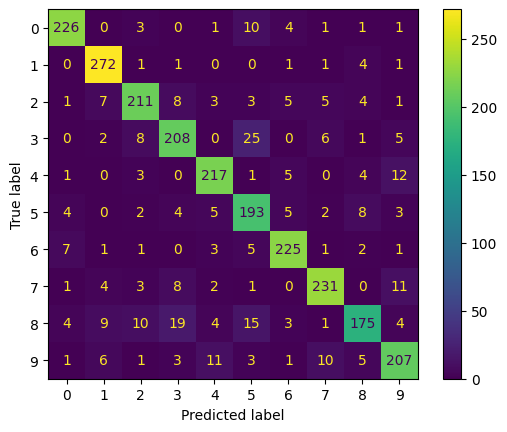

In [37]:
ypred_pca = model.predict(Xtest_pca)
ConfusionMatrixDisplay(confusion_matrix(ytest_pca, ypred_pca)).plot()

In [33]:
model2 = SoftmaxRegression()
model2.fit(Xtrain, ytrain)

Epoch 0: Loss = 25.2302
Epoch 100: Loss = 7.4322
Epoch 200: Loss = 2.8961
Epoch 300: Loss = 3.2072
Epoch 400: Loss = 2.9358
Epoch 500: Loss = 2.2765
Epoch 600: Loss = 3.4296
Epoch 700: Loss = 2.1136
Epoch 800: Loss = 2.0801
Epoch 900: Loss = 2.3882
Epoch 999: Loss = 2.3036


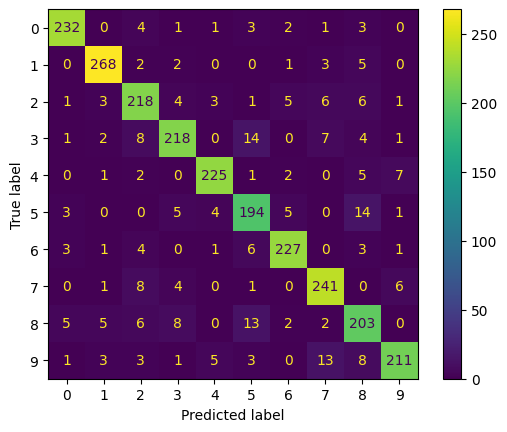

In [34]:
ypred = model2.predict(Xtest)
ConfusionMatrixDisplay(confusion_matrix(ytest, ypred)).plot()

\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\

In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# --- 1. Decision Tree Classes (Copied from your code, no changes) ---

class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, gain=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.gain = gain

class Leaf:
    def __init__(self, value=None):
        self.value = value

class DecisionTree:
    def __init__(self, max_depth=3, reg_lambda=0.8, reg_gamma=0.2):
        self.max_depth = max_depth
        self.reg_lambda = reg_lambda
        self.reg_gamma = reg_gamma
        self.root = None #The root node

    def fit(self, X, r, h):
        """
        Fit the tree. 'r' is the gradient (residuals), 'h' is the hessian.
        This part of your code is generic and works perfectly for multiclass
        as long as we pass in the gradient/hessian for a single class at a time.
        """
        self.root = self._grow_tree(X,r,h,depth=0)

    def _calculate_leaf_value(self, r, h):
        # This formula is correct for XGBoost, regardless of loss function
        return -np.sum(r)/(np.sum(h)+self.reg_lambda)
    
    def _find_best_split(self, X, r, h):
        m, n = X.shape
        best_gain = -float('inf')
        best_feature_index = None
        best_threshold = None

        R_parent = np.sum(r)
        H_parent = np.sum(h)
        parent_score = (R_parent**2)/(H_parent + self.reg_lambda)

        for feature_index in range(n):
            feature_values = X[:, feature_index]
            # Use a simpler quantile strategy to avoid empty splits
            thresholds = np.unique(np.quantile(feature_values, q=np.linspace(0.01,0.99,10)))
            
            for threshold in thresholds:
                left_mask = X[:, feature_index] <= threshold
                right_mask = ~left_mask

                if np.sum(left_mask) < 2 or np.sum(right_mask) < 2:
                    continue # Ensure splits are meaningful

                r_left, h_left = r[left_mask], h[left_mask]
                r_right, h_right = r[right_mask], h[right_mask]

                R_left, H_left = np.sum(r_left), np.sum(h_left)
                R_right, H_right = np.sum(r_right), np.sum(h_right)

                left_score = (R_left**2)/(H_left + self.reg_lambda)
                right_score = (R_right**2)/(H_right + self.reg_lambda)

                gain = 0.5*(left_score+right_score-parent_score)

                if gain > best_gain:
                    best_gain = gain
                    best_feature_index = feature_index
                    best_threshold = threshold

        return best_feature_index, best_threshold, best_gain
    
    def _grow_tree(self, X, r, h, depth):
        if depth == self.max_depth:
            return Leaf(value=self._calculate_leaf_value(r, h))
        
        feature_index, threshold, gain = self._find_best_split(X,r,h)

        if gain <= self.reg_gamma or feature_index is None:
            return Leaf(value=self._calculate_leaf_value(r,h))
        
        node = Node(feature_index=feature_index, threshold=threshold, gain=gain)

        left_mask = X[:, feature_index] <= threshold
        right_mask = ~left_mask
        node.left = self._grow_tree(X[left_mask], r[left_mask], h[left_mask], depth + 1)
        node.right = self._grow_tree(X[right_mask], r[right_mask], h[right_mask], depth + 1)

        return node
    
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if isinstance(node, Leaf):
            return node.value
        if x[node.feature_index] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

# --- 2. NEW: Multiclass XGBoost Classifier ---

class XGBoostMulticlassClassifier:
    def __init__(self, n_estimators=150, initial_learning_rate=1, decay_rate=0.01, max_depth=4, reg_lambda=1.0, reg_gamma=0.1, verbose=True, early_stopping_rounds=20):
        self.n_estimators = n_estimators
        self.initial_learning_rate = initial_learning_rate
        self.decay_rate = decay_rate
        self.reg_lambda = reg_lambda
        self.max_depth = max_depth
        self.reg_gamma = reg_gamma
        self.verbose = verbose
        self.early_stopping_rounds = early_stopping_rounds
        
        # Multiclass-specific attributes
        self.n_classes = None
        self.trees = [] # Will be a list of lists: self.trees[iter][class_k]
        self.learning_rates = []
        self.best_score = -float('inf')
        self.best_iteration = 0

    def _softmax(self, x):
        """ Numerically stable softmax """
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / np.sum(e_x, axis=1, keepdims=True)

    def _one_hot_encode(self, y):
        """ One-hot encodes the target variable y """
        self.n_classes = np.max(y) + 1
        return np.eye(self.n_classes)[y]

    def fit(self, X, y, eval_set=None):
        X = np.asarray(X)
        y = np.asarray(y)

        # Determine number of classes and one-hot encode the target
        y_hot = self._one_hot_encode(y)
        n_samples = X.shape[0]

        # Initialize predictions
        # We start with raw scores (logits) as zeros
        pred = np.zeros((n_samples, self.n_classes))

        val_pred = None
        Xval, yval = None, None
        epochs_without_improvement = 0

        if self.early_stopping_rounds is not None:
            if eval_set is None:
                raise ValueError("eval_set must be provided for early stopping.")
            Xval, yval = np.asarray(eval_set[0]), np.asarray(eval_set[1])
            val_pred = np.zeros((Xval.shape[0], self.n_classes))

        self.trees = []
        self.learning_rates = []
        self.best_iteration = 0
        self.best_score = -float('inf')

        for i in range(self.n_estimators):
            current_lr = self.initial_learning_rate / (1 + self.decay_rate * i)
            
            # --- Multiclass Gradient/Hessian Calculation ---
            # 1. Get current probabilities
            prob = self._softmax(pred)
            
            # 2. Calculate Gradient (Residuals)
            # grad = prob - y_hot
            grad = prob - y_hot
            
            # 3. Calculate Hessian
            # This is the diagonal approximation: prob * (1 - prob)
            hess = prob * (1 - prob)
            # ------------------------------------------------

            # This iteration will build self.n_classes trees
            trees_for_iteration = []
            
            # --- Fit one tree for each class ---
            for k in range(self.n_classes):
                tree = DecisionTree(
                    max_depth=self.max_depth,
                    reg_lambda=self.reg_lambda,
                    reg_gamma=self.reg_gamma
                )
                
                # Fit this tree on the gradients/hessians for class k
                tree.fit(X, grad[:, k], hess[:, k])
                trees_for_iteration.append(tree)
                
                # Update the raw predictions
                update = tree.predict(X)
                pred[:, k] += current_lr * update
            
            self.trees.append(trees_for_iteration)
            self.learning_rates.append(current_lr)

            # --- Early Stopping Logic (for Multiclass) ---
            if self.early_stopping_rounds is not None:
                # Update validation predictions
                for k in range(self.n_classes):
                    val_update = trees_for_iteration[k].predict(Xval)
                    val_pred[:, k] += current_lr * val_update
                
                # Get validation accuracy
                val_preds_classes = np.argmax(val_pred, axis=1)
                val_accuracy = accuracy_score(yval, val_preds_classes)

                if val_accuracy > self.best_score:
                    self.best_score = val_accuracy
                    self.best_iteration = i + 1
                    epochs_without_improvement = 0
                else:
                    epochs_without_improvement += 1

                if self.verbose and ((i + 1) % 10 == 0 or (i + 1) == self.n_estimators):
                    print(f"  [Estimator {i + 1}] LR: {current_lr:.5f} | Val Acc: {val_accuracy:.4f} (Best: {self.best_score:.4f} at {self.best_iteration})")
                
                if epochs_without_improvement >= self.early_stopping_rounds:
                    if self.verbose:
                        print(f"\nStopping early. Best iteration at {self.best_iteration} with accuracy: {self.best_score:.4f}")
                    break
            
            elif self.verbose and ((i + 1) % 10 == 0 or (i + 1) == 1 or (i + 1) == self.n_estimators):
                print(f"  [Estimator {i + 1}/{self.n_estimators}] LR: {current_lr:.5f} | trained.")
        
        # Prune trees to the best iteration
        if self.early_stopping_rounds is not None and self.best_iteration > 0:
            self.trees = self.trees[:self.best_iteration]
            self.learning_rates = self.learning_rates[:self.best_iteration]

    def predict_proba(self, X):
        X = np.asarray(X)
        
        # Start with zero initial predictions
        pred = np.zeros((X.shape[0], self.n_classes))

        for trees_for_iteration, lr in zip(self.trees, self.learning_rates):
            for k in range(self.n_classes):
                pred[:, k] += lr * trees_for_iteration[k].predict(X)
                
        return self._softmax(pred)
        
    def predict(self, X):
        X = np.asarray(X)
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

# --- 3. Script to Run the Model ---

def read_multiclass_data(trainfile, validationfile):
    """
    Reads the data, assuming the target column is 'label'.
    This function is designed to work with your new PCA-transformed files.
    """
    dftrain = pd.read_csv(trainfile)
    dfval = pd.read_csv(validationfile)

    # Get all column names *except* 'label'
    featurecols = [col for col in dftrain.columns if col != 'label']
    targetcol = 'label' 

    Xtrain = dftrain[featurecols]
    ytrain = dftrain[targetcol]
    
    Xval = dfval[featurecols]
    yval = dfval[targetcol]

    return (Xtrain, ytrain, Xval, yval)

# --- Main execution ---
# if __name__ == "__main__":
#     # Define file paths
#     base_path = r"/home/harshvardhan/ml_lab_project/end-semester-project-Programing-Ninja/"
#     n_components = 152
    
#     train_file = base_path + f"pca_transformed_train_data_n{n_components}.csv"
#     test_file = base_path + f"pca_transformed_test_data_n{n_components}.csv"

#     print("Loading data...")
#     # Using the test file as our validation set
#     Xtrain, ytrain, Xval, yval = read_multiclass_data(train_file, test_file)
#     print("Data loaded.")
    
#     model = XGBoostMulticlassClassifier(
#             n_estimators=150,
#             max_depth=3, 
#             reg_lambda=1.0, 
#             reg_gamma=0.1, 
#             initial_learning_rate=1,
#             decay_rate=0.01,
#             early_stopping_rounds=15,
#             verbose=True
#         )

#     print("\nStarting model training...")
#     model.fit(Xtrain, ytrain, eval_set=(Xval, yval))
#     print("Training complete.")

#     print("\nMaking predictions on validation set...")
#     ypred = model.predict(Xval)
#     accuracy = accuracy_score(yval, ypred)

#     print(f"\n--- Multiclass Validation Results ---")
#     print(f"Final Accuracy: {accuracy:.4f}")

#     # Plot confusion matrix
#     print("Displaying confusion matrix...")
#     fig, ax = plt.subplots(figsize=(10, 10))
#     ConfusionMatrixDisplay(confusion_matrix(yval, ypred)).plot(ax=ax)
#     plt.title('Multiclass XGBoost Confusion Matrix')
#     plt.show()

In [42]:
model3 = XGBoostMulticlassClassifier()
model3.fit(Xtrain, ytrain, eval_set=(Xtest, ytest))


  [Estimator 10] LR: 0.91743 | Val Acc: 0.0000 (Best: 0.0000 at 1)


KeyboardInterrupt: 

In [ ]:
ypred = model3.predict(Xtest)
ConfusionMatrixDisplay(confusion_matrix(ytest, ypred)).plot()

In [16]:
model4 = XGBoostMulticlassClassifier()
model4.fit(Xtrain_pca, ytrain_pca, eval_set=(Xtest_pca, ytest_pca))

  [Estimator 10] LR: 0.91743 | Val Acc: 0.8503 (Best: 0.8503 at 10)
  [Estimator 20] LR: 0.84034 | Val Acc: 0.8659 (Best: 0.8675 at 19)
  [Estimator 30] LR: 0.77519 | Val Acc: 0.8683 (Best: 0.8691 at 26)
  [Estimator 40] LR: 0.71942 | Val Acc: 0.8679 (Best: 0.8691 at 26)
  [Estimator 50] LR: 0.67114 | Val Acc: 0.8695 (Best: 0.8703 at 49)


KeyboardInterrupt: 

In [ ]:
ypred_pca = model3.predict(Xtest)
ConfusionMatrixDisplay(confusion_matrix(ytest_pca, ypred_pca)).plot()

XGB BY LIBRARY

In [5]:
!pip install xgboost


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 6.8 MB/s eta 0:00:0000:0100:01


In [6]:
import xgboost as xgb

In [7]:
model = xgb.XGBClassifier(
            objective='multi:softmax',  # Use 'multi:softmax' for multiclass
            num_class=10,               # Specify the number of classes (0-9)
            n_estimators=150,
            max_depth=4, 
            reg_lambda=1.0,             # L2 regularization (your reg_lambda)
            gamma=0.1,                  # Your reg_gamma (for pruning)
            learning_rate=0.3,          # Default is 0.3. Your 1.0 was very high.
            early_stopping_rounds=15,   # Use the library's early stopping
            n_jobs=-1                   # Use all available CPU cores
        )

In [8]:
model.fit(Xtrain, ytrain, 
              eval_set=[(Xtest, ytest)],
              verbose=True)

[0]	validation_0-mlogloss:1.46027


sh: 1: nvidia-smi: not found


[1]	validation_0-mlogloss:1.12140
[2]	validation_0-mlogloss:0.90872
[3]	validation_0-mlogloss:0.75243
[4]	validation_0-mlogloss:0.63734
[5]	validation_0-mlogloss:0.55212
[6]	validation_0-mlogloss:0.48206
[7]	validation_0-mlogloss:0.42874
[8]	validation_0-mlogloss:0.38479
[9]	validation_0-mlogloss:0.34801
[10]	validation_0-mlogloss:0.31958
[11]	validation_0-mlogloss:0.29468
[12]	validation_0-mlogloss:0.27476
[13]	validation_0-mlogloss:0.25529
[14]	validation_0-mlogloss:0.23921
[15]	validation_0-mlogloss:0.22379
[16]	validation_0-mlogloss:0.21311
[17]	validation_0-mlogloss:0.20316
[18]	validation_0-mlogloss:0.19306
[19]	validation_0-mlogloss:0.18469
[20]	validation_0-mlogloss:0.17845
[21]	validation_0-mlogloss:0.17158
[22]	validation_0-mlogloss:0.16543
[23]	validation_0-mlogloss:0.15874
[24]	validation_0-mlogloss:0.15424
[25]	validation_0-mlogloss:0.15012
[26]	validation_0-mlogloss:0.14609
[27]	validation_0-mlogloss:0.14327
[28]	validation_0-mlogloss:0.14025
[29]	validation_0-mlogloss:0.

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=15,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=-1, num_class=10, ...)

In [9]:
ypred = model.predict(Xtest)

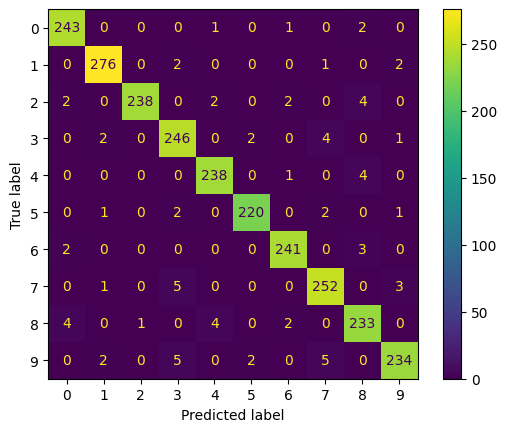

In [10]:
ConfusionMatrixDisplay(confusion_matrix(ytest, ypred)).plot()

In [19]:
accuracy = accuracy_score(ytest, ypred)
f1_macro = f1_score(ytest, ypred, average='macro')
f1_weighted = f1_score(ytest_pca, ypred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")

Accuracy: 0.9688
F1 Score (Macro): 0.9688
F1 Score (Weighted): 0.9688


In [11]:
model2 = xgb.XGBClassifier(
            objective='multi:softmax',  # Use 'multi:softmax' for multiclass
            num_class=10,               # Specify the number of classes (0-9)
            n_estimators=150,
            max_depth=4, 
            reg_lambda=1.0,             # L2 regularization (your reg_lambda)
            gamma=0.1,                  # Your reg_gamma (for pruning)
            learning_rate=0.3,          # Default is 0.3. Your 1.0 was very high.
            early_stopping_rounds=15,   # Use the library's early stopping
            n_jobs=-1                   # Use all available CPU cores
        )

In [12]:
model2.fit(Xtrain_pca, ytrain_pca, 
              eval_set=[(Xtest_pca, ytest_pca)],
              verbose=True)



[0]	validation_0-mlogloss:1.59051
[1]	validation_0-mlogloss:1.31599
[2]	validation_0-mlogloss:1.13059
[3]	validation_0-mlogloss:0.99268
[4]	validation_0-mlogloss:0.88950
[5]	validation_0-mlogloss:0.80599
[6]	validation_0-mlogloss:0.73906
[7]	validation_0-mlogloss:0.68402
[8]	validation_0-mlogloss:0.63871
[9]	validation_0-mlogloss:0.60194
[10]	validation_0-mlogloss:0.56905
[11]	validation_0-mlogloss:0.54233
[12]	validation_0-mlogloss:0.51587
[13]	validation_0-mlogloss:0.49579
[14]	validation_0-mlogloss:0.47448
[15]	validation_0-mlogloss:0.45684
[16]	validation_0-mlogloss:0.44087
[17]	validation_0-mlogloss:0.42649
[18]	validation_0-mlogloss:0.41302
[19]	validation_0-mlogloss:0.40205
[20]	validation_0-mlogloss:0.38930
[21]	validation_0-mlogloss:0.38078
[22]	validation_0-mlogloss:0.37269
[23]	validation_0-mlogloss:0.36552
[24]	validation_0-mlogloss:0.35762
[25]	validation_0-mlogloss:0.35021
[26]	validation_0-mlogloss:0.34319
[27]	validation_0-mlogloss:0.33751
[28]	validation_0-mlogloss:0.3

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=15,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=150,
              n_jobs=-1, num_class=10, ...)

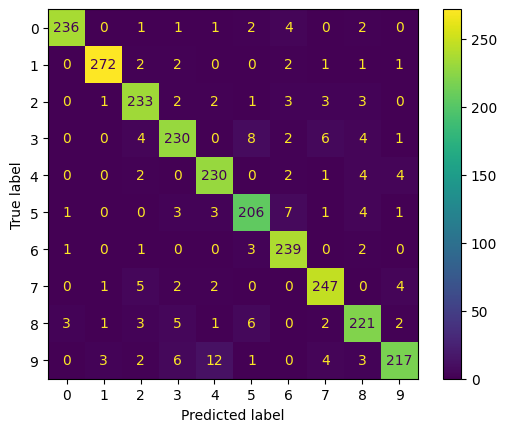

In [14]:
ypred_pca = model2.predict(Xtest_pca)
ConfusionMatrixDisplay(confusion_matrix(ytest_pca, ypred_pca)).plot()

In [20]:
accuracy = accuracy_score(ytest_pca, ypred_pca)
f1_macro = f1_score(ytest_pca, ypred_pca, average='macro')
f1_weighted = f1_score(ytest_pca, ypred_pca, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"F1 Score (Weighted): {f1_weighted:.4f}")

Accuracy: 0.9328
F1 Score (Macro): 0.9320
F1 Score (Weighted): 0.9327


Algorithmic sampling XGBoost

In [21]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import matplotlib.pyplot as plt
import random # We'll use this for feature sampling

# --- 1. Decision Tree Classes (Modified for Column Sampling) ---

class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, gain=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.gain = gain

class Leaf:
    def __init__(self, value=None):
        self.value = value

class DecisionTree:
    def __init__(self, max_depth=3, reg_lambda=0.8, reg_gamma=0.2):
        self.max_depth = max_depth
        self.reg_lambda = reg_lambda
        self.reg_gamma = reg_gamma
        self.root = None 

    def fit(self, X, r, h, n_features_to_sample):
        """
        Fit the tree. 'r' is the gradient, 'h' is the hessian.
        --- NEW: Now accepts 'n_features_to_sample' ---
        """
        self.root = self._grow_tree(X, r, h, 0, n_features_to_sample)

    def _calculate_leaf_value(self, r, h):
        # This is our fix from before
        return -np.sum(r)/(np.sum(h)+self.reg_lambda)
    
    def _find_best_split(self, X, r, h, n_features_to_sample):
        """ --- NEW: Now accepts 'n_features_to_sample' --- """
        m, n = X.shape
        best_gain = -float('inf')
        best_feature_index = None
        best_threshold = None

        R_parent = np.sum(r)
        H_parent = np.sum(h)
        parent_score = (R_parent**2)/(H_parent + self.reg_lambda)

        # --- OPTIMIZATION: Feature Sampling (col_sample_ratio) ---
        # Instead of 'for feature_index in range(n):'
        all_indices = list(range(n))
        # Get a random subset of feature indices to check
        feature_indices_to_check = random.sample(all_indices, n_features_to_sample)
        # --------------------------------------------------------
        
        for feature_index in feature_indices_to_check:
            feature_values = X[:, feature_index]
            thresholds = np.unique(np.quantile(feature_values, q=np.linspace(0.01,0.99,10)))
            
            for threshold in thresholds:
                left_mask = X[:, feature_index] <= threshold
                right_mask = ~left_mask

                if np.sum(left_mask) < 2 or np.sum(right_mask) < 2:
                    continue 

                r_left, h_left = r[left_mask], h[left_mask]
                r_right, h_right = r[right_mask], h[right_mask]

                R_left, H_left = np.sum(r_left), np.sum(h_left)
                R_right, H_right = np.sum(r_right), np.sum(h_right)

                left_score = (R_left**2)/(H_left + self.reg_lambda)
                right_score = (R_right**2)/(H_right + self.reg_lambda)

                gain = 0.5*(left_score+right_score-parent_score)

                if gain > best_gain:
                    best_gain = gain
                    best_feature_index = feature_index
                    best_threshold = threshold

        return best_feature_index, best_threshold, best_gain
    
    def _grow_tree(self, X, r, h, depth, n_features_to_sample):
        """ --- NEW: Pass 'n_features_to_sample' down --- """
        if depth == self.max_depth:
            return Leaf(value=self._calculate_leaf_value(r, h))
        
        feature_index, threshold, gain = self._find_best_split(X, r, h, n_features_to_sample)

        if gain <= self.reg_gamma or feature_index is None:
            return Leaf(value=self._calculate_leaf_value(r,h))
        
        node = Node(feature_index=feature_index, threshold=threshold, gain=gain)

        left_mask = X[:, feature_index] <= threshold
        right_mask = ~left_mask
        
        # Check for empty splits
        if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
             return Leaf(value=self._calculate_leaf_value(r,h))

        node.left = self._grow_tree(X[left_mask], r[left_mask], h[left_mask], depth + 1, n_features_to_sample)
        node.right = self._grow_tree(X[right_mask], r[right_mask], h[right_mask], depth + 1, n_features_to_sample)

        return node
    
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if isinstance(node, Leaf):
            return node.value
        if node.left and x[node.feature_index] <= node.threshold:
            return self._traverse_tree(x, node.left)
        elif node.right:
            return self._traverse_tree(x, node.right)
        return 0


# --- 2. Multiclass XGBoost Classifier (Modified for Sampling) ---

class XGBoostMulticlassClassifier:
    def __init__(self, n_estimators=150, initial_learning_rate=1, decay_rate=0.01, 
                 max_depth=4, reg_lambda=1.0, reg_gamma=0.1, 
                 verbose=True, early_stopping_rounds=20,
                 # --- OPTIMIZATION: New sampling parameters ---
                 subsample_ratio=0.8, col_sample_ratio=0.8):
        
        self.n_estimators = n_estimators
        self.initial_learning_rate = initial_learning_rate
        self.decay_rate = decay_rate
        self.reg_lambda = reg_lambda
        self.max_depth = max_depth
        self.reg_gamma = reg_gamma
        self.verbose = verbose
        self.early_stopping_rounds = early_stopping_rounds
        # --- Store new params ---
        self.subsample_ratio = subsample_ratio
        self.col_sample_ratio = col_sample_ratio
        
        self.n_classes = None
        self.trees = [] 
        self.learning_rates = []
        self.best_score = -float('inf')
        self.best_iteration = 0

    def _softmax(self, x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / np.sum(e_x, axis=1, keepdims=True)

    def _one_hot_encode(self, y):
        y_int = y.astype(int)
        self.n_classes = np.max(y_int) + 1
        return np.eye(self.n_classes)[y_int]

    def fit(self, X, y, eval_set=None):
        X = np.asarray(X)
        y = np.asarray(y)
        y_hot = self._one_hot_encode(y)
        n_samples, n_features = X.shape

        # --- OPTIMIZATION: Calculate sampling numbers once ---
        n_samples_to_sample = int(n_samples * self.subsample_ratio)
        n_features_to_sample = int(n_features * self.col_sample_ratio)
        # ----------------------------------------------------

        pred = np.zeros((n_samples, self.n_classes))
        val_pred = None
        Xval, yval = None, None
        epochs_without_improvement = 0

        if self.early_stopping_rounds is not None:
            if eval_set is None:
                raise ValueError("eval_set must be provided for early stopping.")
            Xval, yval = np.asarray(eval_set[0]), np.asarray(eval_set[1])
            val_pred = np.zeros((Xval.shape[0], self.n_classes))

        self.trees = []
        self.learning_rates = []
        self.best_iteration = 0
        self.best_score = -float('inf')
        
        print(f"--- Optimizations Enabled ---")
        print(f"Row Sampling: Using {n_samples_to_sample} of {n_samples} samples per tree.")
        print(f"Column Sampling: Using {n_features_to_sample} of {n_features} features per split.")
        print("-------------------------------")


        for i in range(self.n_estimators):
            current_lr = self.initial_learning_rate / (1 + self.decay_rate * i)
            
            prob = self._softmax(pred)
            grad = prob - y_hot
            hess = prob * (1 - prob)

            # --- OPTIMIZATION: Subsampling (Stochastic Boosting) ---
            # Get a random subset of row indices
            sample_indices = np.random.choice(n_samples, n_samples_to_sample, replace=False)
            
            # Get the sampled data
            X_sample = X[sample_indices]
            grad_sample = grad[sample_indices]
            hess_sample = hess[sample_indices]
            # ------------------------------------------------------

            trees_for_iteration = []
            
            for k in range(self.n_classes):
                if self.verbose and (i + 1) % 10 == 0:
                    print(f"    - Building tree for class {k}...")
                
                tree = DecisionTree(
                    max_depth=self.max_depth,
                    reg_lambda=self.reg_lambda,
                    reg_gamma=self.reg_gamma
                )
                
                # --- NEW: Pass sampled data and feature count to fit ---
                tree.fit(X_sample, grad_sample[:, k], hess_sample[:, k], n_features_to_sample)
                trees_for_iteration.append(tree)
                
                # Update predictions on the *full* (non-sampled) dataset
                update = tree.predict(X)
                pred[:, k] += current_lr * update
            
            self.trees.append(trees_for_iteration)
            self.learning_rates.append(current_lr)

            # --- Early Stopping Logic (unchanged) ---
            if self.early_stopping_rounds is not None:
                for k in range(self.n_classes):
                    val_update = trees_for_iteration[k].predict(Xval)
                    val_pred[:, k] += current_lr * val_update
                
                val_preds_classes = np.argmax(val_pred, axis=1)
                val_accuracy = accuracy_score(yval, val_preds_classes)

                if val_accuracy > self.best_score:
                    self.best_score = val_accuracy
                    self.best_iteration = i + 1
                    epochs_without_improvement = 0
                else:
                    epochs_without_improvement += 1

                if self.verbose and ((i + 1) % 10 == 0 or (i + 1) == self.n_estimators):
                    print(f"  [Estimator {i + 1}] LR: {current_lr:.5f} | Val Acc: {val_accuracy:.4f} (Best: {self.best_score:.4f} at {self.best_iteration})")
                
                if epochs_without_improvement >= self.early_stopping_rounds:
                    if self.verbose:
                        print(f"\nStopping early. Best iteration at {self.best_iteration} with accuracy: {self.best_score:.4f}")
                    break
            
            elif self.verbose and ((i + 1) % 10 == 0 or (i + 1) == 1 or (i + 1) == self.n_estimators):
                print(f"  [Estimator {i + 1}/{self.n_estimators}] LR: {current_lr:.5f} | trained.")
        
        if self.early_stopping_rounds is not None and self.best_iteration > 0:
            self.trees = self.trees[:self.best_iteration]
            self.learning_rates = self.learning_rates[:self.best_iteration]

    def predict_proba(self, X):
        X = np.asarray(X)
        pred = np.zeros((X.shape[0], self.n_classes))
        for trees_for_iteration, lr in zip(self.trees, self.learning_rates):
            for k in range(self.n_classes):
                pred[:, k] += lr * trees_for_iteration[k].predict(X)
        return self._softmax(pred)
        
    def predict(self, X):
        X = np.asarray(X)
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

# --- 3. Script to Run the Model ---

def read_multiclass_data(trainfile, validationfile):
    dftrain = pd.read_csv(trainfile)
    dfval = pd.read_csv(validationfile)
    featurecols = [col for col in dftrain.columns if col != 'label']
    targetcol = 'label' 
    Xtrain = dftrain[featurecols]
    ytrain = dftrain[targetcol]
    Xval = dfval[featurecols]
    yval = dfval[targetcol]
    return (Xtrain, ytrain, Xval, yval)

# --- Main execution ---
# if __name__ == "__main__":
#     base_path = r"/home/harshvardhan/ml_lab_project/end-semester-project-Programing-Ninja/"
#     n_components = 152
#     train_file = base_path + f"pca_transformed_train_data_n{n_components}.csv"
#     test_file = base_path + f"pca_transformed_test_data_n{n_components}.csv"

#     print("Loading data...")
#     Xtrain, ytrain, Xval, yval = read_multiclass_data(train_file, test_file)
#     print("Data loaded.")
    
#     # --- OPTIMIZATION: Tune parameters for speed ---
#     model = XGBoostMulticlassClassifier(
#             n_estimators=150,       
#             max_depth=3,            # --- FASTER: Reduced depth (3 or 4 is good) ---
#             reg_lambda=1.0, 
#             reg_gamma=0.1, 
#             initial_learning_rate=0.8, # Learning rate is a bit lower for stability
#             decay_rate=0.01,
#             early_stopping_rounds=15, 
#             verbose=True,
#             subsample_ratio=0.7,    # --- FASTER: Use 70% of data per tree ---
#             col_sample_ratio=0.7    # --- FASTER: Use 70% of features per split ---
#         )

#     print("\nStarting model training (with Sampling)...")
#     model.fit(Xtrain, ytrain, eval_set=(Xval, yval))
#     print("Training complete.")

#     print("\nMaking predictions on validation set...")
#     ypred = model.predict(Xval)
    
#     accuracy = accuracy_score(yval, ypred)
#     f1_macro = f1_score(yval, ypred, average='macro')
    
#     print(f"\n--- Multiclass Validation Results (with Sampling) ---")
#     print(f"Final Accuracy: {accuracy:.4f}")
#     print(f"Macro F1 Score: {f1_macro:.4f}")

#     print("Displaying confusion matrix...")
#     fig, ax = plt.subplots(figsize=(10, 10))
#     ConfusionMatrixDisplay(confusion_matrix(yval, ypred)).plot(ax=ax)
#     plt.title('Custom Multiclass XGBoost Confusion Matrix (with Sampling)')
#     plt.show()

In [22]:
model = XGBoostMulticlassClassifier(
            n_estimators=150,       
            max_depth=3,            # --- FASTER: Reduced depth (3 or 4 is good) ---
            reg_lambda=1.0, 
            reg_gamma=0.1, 
            initial_learning_rate=0.8, # Learning rate is a bit lower for stability
            decay_rate=0.01,
            early_stopping_rounds=15, 
            verbose=True,
            subsample_ratio=0.7,    # --- FASTER: Use 70% of data per tree ---
            col_sample_ratio=0.7    # --- FASTER: Use 70% of features per split ---
        )

--- Optimizations Enabled ---
Row Sampling: Using 7001 of 10002 samples per tree.
Column Sampling: Using 106 of 152 features per split.
-------------------------------
    - Building tree for class 0...
    - Building tree for class 1...
    - Building tree for class 2...
    - Building tree for class 3...
    - Building tree for class 4...
    - Building tree for class 5...
    - Building tree for class 6...
    - Building tree for class 7...
    - Building tree for class 8...
    - Building tree for class 9...
  [Estimator 10] LR: 0.73394 | Val Acc: 0.8383 (Best: 0.8383 at 10)
    - Building tree for class 0...
    - Building tree for class 1...
    - Building tree for class 2...
    - Building tree for class 3...
    - Building tree for class 4...
    - Building tree for class 5...
    - Building tree for class 6...
    - Building tree for class 7...
    - Building tree for class 8...
    - Building tree for class 9...
  [Estimator 20] LR: 0.67227 | Val Acc: 0.8487 (Best: 0.8543 at 

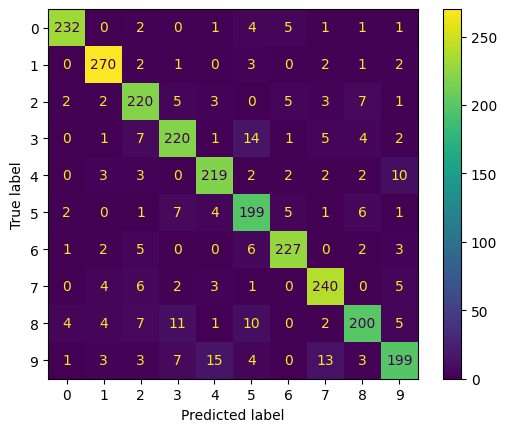

In [23]:
model.fit(Xtrain_pca, ytrain_pca, eval_set=(Xtest_pca, ytest_pca))
ypred_pca = model.predict(Xtest_pca)
ConfusionMatrixDisplay(confusion_matrix(ytest_pca, ypred_pca)).plot()


In [24]:
accuracy = accuracy_score(ytest_pca, ypred_pca)
f1_macro = f1_score(ytest_pca, ypred_pca, average='macro')
print(f"Final Accuracy: {accuracy:.4f}")
print(f"Macro F1 Score: {f1_macro:.4f}")

Final Accuracy: 0.8908
Macro F1 Score: 0.8894


In [25]:
class MyStandardScaler:
    """
    A from-scratch implementation of StandardScaler.
    """
    def __init__(self):
        self.mean_ = None
        self.std_ = None

    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0) + 1e-9 

    def transform(self, X):
        if self.mean_ is None or self.std_ is None:
            raise ValueError("Must fit() the scaler before transforming.")
        return (X - self.mean_) / self.std_

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

# --- 2. From-Scratch "True" MULTICLASS SVM (Crammer-Singer) ---
class MyTrueMulticlassSVM:
    """
    A from-scratch implementation of a multiclass SVM using the
    Crammer-Singer formulation, trained with mini-batch gradient descent.
    """
    def __init__(self, learning_rate=0.001, lambda_p=0.01, n_iters=100, batch_size=64):
        self.lr = learning_rate
        self.lambda_p = lambda_p
        self.n_iters = n_iters
        self.batch_size = batch_size
        self.W = None # Weight matrix, shape (n_features, n_classes)
        self.B = None # Bias vector, shape (n_classes,)
        self.classes_ = None
        self.n_classes_ = 0

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)
        self.n_classes_ = len(self.classes_)
        
        # Initialize weights and biases
        self.W = np.zeros((n_features, self.n_classes_))
        self.B = np.zeros(self.n_classes_)
        
        # Map class labels (e.g., 0, 1...9) to indices (0, 1...9)
        # This is crucial because our y_train is labels, not indices
        class_to_index = {c: i for i, c in enumerate(self.classes_)}
        y_indices = np.array([class_to_index[label] for label in y])

        print(f"--- Training True Multiclass SVM for {self.n_classes_} classes ---")
        
        for epoch in range(self.n_iters):
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            y_shuffled = y_indices[indices]
            
            for i in range(0, n_samples, self.batch_size):
                X_batch = X_shuffled[i : i + self.batch_size]
                y_batch = y_shuffled[i : i + self.batch_size]
                batch_n_samples = X_batch.shape[0]

                # --- 1. Calculate Scores ---
                # scores = (n_samples, n_classes)
                scores = X_batch @ self.W + self.B
                
                # --- 2. Calculate Multiclass Hinge Loss Gradient ---
                
                # Get the score of the correct class for each sample
                correct_class_scores = scores[np.arange(batch_n_samples), y_batch].reshape(-1, 1)
                
                # Calculate the margin: score(k) - score(y_i) + 1
                margins = scores - correct_class_scores + 1.0
                
                # We don't count the margin for the correct class itself
                margins[np.arange(batch_n_samples), y_batch] = 0
                
                # Find the *single most violating* class for each sample
                # This is the 'k' that gives max(0, score(k) - score(y_i) + 1)
                violating_class_indices = np.argmax(margins, axis=1)
                
                # Get the actual margin values for those violating classes
                max_margins = margins[np.arange(batch_n_samples), violating_class_indices]
                
                # Find which samples are "missed" (margin > 0)
                missed_mask = max_margins > 0
                num_missed = np.sum(missed_mask)

                if num_missed == 0:
                    continue # This batch is perfectly classified

                # Get the data for only the missed samples
                X_missed = X_batch[missed_mask]
                y_true_missed = y_batch[missed_mask]
                y_violating_missed = violating_class_indices[missed_mask]
                
                # --- 3. Compute Gradients (Vectorized) ---
                dW = np.zeros_like(self.W)
                dB = np.zeros_like(self.B)
                
                # This is a fast, vectorized way to do:
                # for i in num_missed:
                #   dW[:, y_true_missed[i]] -= X_missed[i]
                #   dW[:, y_violating_missed[i]] += X_missed[i]
                np.subtract.at(dW.T, y_true_missed, X_missed)
                np.add.at(dW.T, y_violating_missed, X_missed)

                # And for the bias:
                # for i in num_missed:
                #   dB[y_true_missed[i]] -= 1
                #   dB[y_violating_missed[i]] += 1
                np.subtract.at(dB, y_true_missed, 1)
                np.add.at(dB, y_violating_missed, 1)
                
                # Average the gradients over the *number of missed samples*
                dW /= num_missed
                dB /= num_missed
                
                # Add regularization gradient
                dW += self.lambda_p * self.W
                
                # --- 4. Update Weights ---
                self.W -= self.lr * dW
                self.B -= self.lr * dB

    def predict(self, X):
        """
        Predicts by finding the class with the highest score.
        """
        if self.W is None or self.B is None:
            raise ValueError("Must fit() the model before predicting.")
            
        # Calculate scores: (n_samples, n_classes)
        scores = X @ self.W + self.B
        
        # Find the index of the highest score for each sample
        highest_score_index = np.argmax(scores, axis=1)
        
        # Map those indices back to the actual class labels
        return self.classes_[highest_score_index]


In [26]:
scaler = MyStandardScaler()
Xtrain_pca_scaled = scaler.fit_transform(Xtrain_pca)
Xval_pca_scaled = scaler.transform(Xtest_pca)

In [30]:
model = MyTrueMulticlassSVM(
        learning_rate=0.01,  # A slightly higher LR might be needed
        lambda_p=0.01,       # Regularization
        n_iters=1000,         # More epochs for this complex model
        batch_size=128
    )

In [31]:
model.fit(Xtrain_pca_scaled, ytrain_pca)
ypred_pca = model.predict(Xval_pca_scaled)

--- Training True Multiclass SVM for 10 classes ---


In [32]:
accuracy = accuracy_score(ytest_pca, ypred_pca)
f1 = f1_score(ytest_pca, ypred_pca, average='macro')
print(f"True Multiclass SVM Accuracy: {accuracy:.4f}")
print(f"True Multiclass SVM Macro F1 Score: {f1:.4f}")

True Multiclass SVM Accuracy: 0.9048
True Multiclass SVM Macro F1 Score: 0.9032


In [33]:
scaler = MyStandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xval_scaled = scaler.transform(Xtest)

In [34]:
model = MyTrueMulticlassSVM(
        learning_rate=0.01,  # A slightly higher LR might be needed
        lambda_p=0.01,       # Regularization
        n_iters=1000,         # More epochs for this complex model
        batch_size=128
    )

In [35]:
model.fit(Xtrain_scaled, ytrain)
ypred_pca = model.predict(Xval_scaled)

--- Training True Multiclass SVM for 10 classes ---


In [36]:
accuracy = accuracy_score(ytest, ypred)
f1 = f1_score(ytest, ypred, average='macro')
print(f"True Multiclass SVM Accuracy: {accuracy:.4f}")
print(f"True Multiclass SVM Macro F1 Score: {f1:.4f}")

True Multiclass SVM Accuracy: 0.9688
True Multiclass SVM Macro F1 Score: 0.9688


In [37]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

# We can still use scikit-learn for metrics, just not for the models.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

# --- 1. From-Scratch StandardScaler ---
class MyStandardScaler:
    """
    A from-scratch implementation of StandardScaler.
    """
    def __init__(self):
        self.mean_ = None
        self.std_ = None

    def fit(self, X):
        """Calculates the mean and standard deviation of each feature."""
        # axis=0 calculates the mean/std for each column (feature)
        self.mean_ = np.mean(X, axis=0)
        # Add a small epsilon to avoid division by zero if a feature has zero variance
        self.std_ = np.std(X, axis=0) + 1e-9 

    def transform(self, X):
        """Applies the z-score normalization."""
        if self.mean_ is None or self.std_ is None:
            raise ValueError("Must fit() the scaler before transforming.")
        return (X - self.mean_) / self.std_

    def fit_transform(self, X):
        """A convenience function to fit and then transform."""
        self.fit(X)
        return self.transform(X)

# --- 2. From-Scratch K-Nearest Neighbors ---
class MyKNeighborsClassifier:
    """
    A from-scratch implementation of KNN.
    Note: This is a "lazy" learner. Fit() is fast, predict() is slow.
    """
    def __init__(self, k=5):
        self.k = k
        self.X_train_ = None
        self.y_train_ = None

    def fit(self, X, y):
        """ "Training" for KNN is just storing the data."""
        self.X_train_ = X
        self.y_train_ = y

    def predict(self, X_test):
        """
        Predicts the class for each sample in X_test.
        This will be slow as it's a pure Python loop.
        """
        if self.X_train_ is None or self.y_train_ is None:
            raise ValueError("Must fit() the model before predicting.")
        
        predictions = [self._predict_one(x) for x in X_test]
        return np.array(predictions)

    def _predict_one(self, x_test):
        """Helper function to predict a single data point."""
        
        # 1. Calculate Euclidean distances from x_test to all training points
        distances = [np.linalg.norm(x_test - x_train) for x_train in self.X_train_]
        
        # 2. Get the indices of the 'k' nearest neighbors
        k_nearest_indices = np.argsort(distances)[:self.k]
        
        # 3. Get the labels of those neighbors
        k_nearest_labels = [self.y_train_[i] for i in k_nearest_indices]
        
        # 4. Return the most common label (majority vote)
        # np.bincount is a fast way to count integer occurrences
        most_common = np.bincount(k_nearest_labels).argmax()
        return most_common

# --- 3. From-Scratch Gaussian Naive Bayes ---
class MyGaussianNB:
    """
    A from-scratch implementation of Gaussian Naive Bayes.
    This implementation is fully vectorized for fast predictions.
    """
    def __init__(self):
        self.classes_ = None
        self.means_ = {}  # A dict to store means: {class_k: [mean_f1, ...]}
        self.vars_ = {}   # A dict to store variances: {class_k: [var_f1, ...]}
        self.priors_ = {} # A dict to store prior probs: {class_k: P(k)}

    def fit(self, X, y):
        """
        Calculates the means, variances, and priors for each class.
        """
        self.classes_ = np.unique(y)
        n_samples, n_features = X.shape
        
        for c in self.classes_:
            # Get all samples belonging to class 'c'
            X_c = X[y == c]
            
            # Calculate and store mean, var, and prior
            self.means_[c] = np.mean(X_c, axis=0)
            self.vars_[c] = np.var(X_c, axis=0) + 1e-9 # Epsilon for stability
            self.priors_[c] = X_c.shape[0] / float(n_samples)

    def predict(self, X_test):
        """
        Predicts the class for each sample in X_test using vectorized operations.
        """
        if self.classes_ is None:
            raise ValueError("Must fit() the model before predicting.")
            
        # We will store the log-posteriors for each class in this array
        # Shape: (n_test_samples, n_classes)
        posteriors = np.zeros((X_test.shape[0], len(self.classes_)))
        
        # Calculate posteriors for each class
        for idx, c in enumerate(self.classes_):
            # Get pre-calculated parameters
            prior = np.log(self.priors_[c])
            mean = self.means_[c]
            var = self.vars_[c]
            
            # This is the vectorized log of the Gaussian PDF (Probability Density Function)
            # We calculate it for all test samples at once.
            log_pdf_likelihoods = -0.5 * np.sum(np.log(2 * np.pi * var)) \
                                  -0.5 * np.sum(((X_test - mean)**2 / var), axis=1)
            
            # P(C|X) = P(X|C) * P(C). In log-space: log(P(C|X)) = log(P(X|C)) + log(P(C))
            posteriors[:, idx] = prior + log_pdf_likelihoods
            
        # Return the class (not the index) with the highest log-posterior probability
        return self.classes_[np.argmax(posteriors, axis=1)]


# --- 4. Data Loading Function ---
def read_multiclass_data(trainfile, validationfile):
    dftrain = pd.read_csv(trainfile)
    dfval = pd.read_csv(validationfile)
    featurecols = [col for col in dftrain.columns if col != 'label']
    targetcol = 'label' 
    Xtrain = dftrain[featurecols].values
    ytrain = dftrain[targetcol].values
    Xval = dfval[featurecols].values
    yval = dfval[targetcol].values
    return (Xtrain, ytrain, Xval, yval)



In [ ]:
models = {
        "1. From-Scratch GaussianNB": MyGaussianNB(),
        "2. From-Scratch KNN (k=5)": MyKNeighborsClassifier(k=5),
    }

In [ ]:
results = []

for name, model in models.items():
        print(f"Training {name}...")
        start_time = time.time()
        
        # Fit on scaled data
        model.fit(Xtrain_scaled, ytrain)
        
        
        print(f"Predicting with {name}...")
        # Predict on scaled data
        ypred = model.predict(Xtest_scaled)
        predict_time = time.time() - start_time_pred
        
        # Calculate metrics
        accuracy = accuracy_score(yval, ypred)
        f1 = f1_score(yval, ypred, average='macro')
        
        results.append((name, accuracy, f1, train_time, predict_time))

In [ ]:
for name, model in models.items():
        print(f"Training {name}...")
        start_time = time.time()
        
        # Fit on scaled data
        model.fit(Xtrain_scaled, ytrain)
        
        train_time = time.time() - start_time
        
        print(f"Predicting with {name}...")
        start_time_pred = time.time()
        # Predict on scaled data
        ypred = model.predict(Xval_scaled)
        predict_time = time.time() - start_time_pred
        
        # Calculate metrics
        accuracy = accuracy_score(yval, ypred)
        f1 = f1_score(yval, ypred, average='macro')
        
        results.append((name, accuracy, f1, train_time, predict_time))

Loading all datasets...
All data loaded.

--- STARTING FROM-SCRATCH MODEL BAKE-OFF ---

--- Training: GNB on Original ---
    - Fitting model (785 features)...
    - Predicting...

--- Training: GNB on PCA ---
    - Fitting model (152 features)...
    - Predicting...

--- Training: KNN (k=3) on PCA ---
    - Fitting scaler...
    - Fitting model (152 features)...
    - Predicting...
    - KNN predicting sample 100/2499...
    - KNN predicting sample 200/2499...
    - KNN predicting sample 300/2499...
    - KNN predicting sample 400/2499...
    - KNN predicting sample 500/2499...
    - KNN predicting sample 600/2499...
    - KNN predicting sample 700/2499...
    - KNN predicting sample 800/2499...
    - KNN predicting sample 900/2499...
    - KNN predicting sample 1000/2499...
    - KNN predicting sample 1100/2499...
    - KNN predicting sample 1200/2499...
    - KNN predicting sample 1300/2499...
    - KNN predicting sample 1400/2499...
    - KNN predicting sample 1500/2499...
    - KN

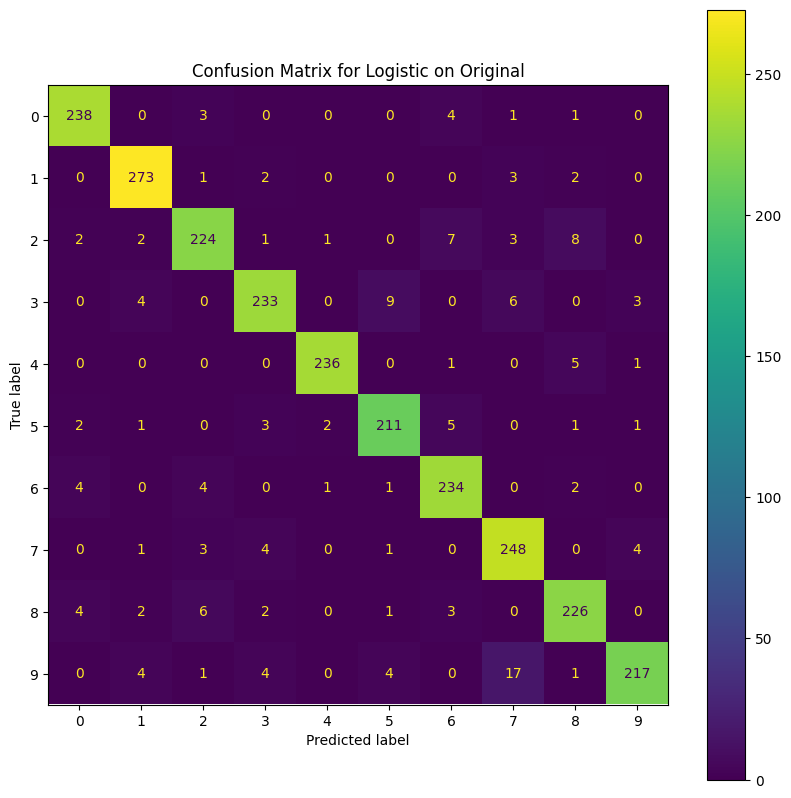

In [39]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import itertools

# --- 1. Import all metrics and models ---
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

# ---
# --- (A) FROM-SCRATCH PREPROCESSING ---
# ---
class MyStandardScaler:
    """ A from-scratch implementation of StandardScaler. """
    def __init__(self):
        self.mean_ = None
        self.std_ = None

    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0) + 1e-9 

    def transform(self, X):
        if self.mean_ is None or self.std_ is None:
            raise ValueError("Must fit() the scaler before transforming.")
        return (X - self.mean_) / self.std_

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

# ---
# --- (B) FROM-SCRATCH MODELS ---
# ---

class MyKNeighborsClassifier:
    """ From-scratch KNN. Fit() is fast, predict() is very slow. """
    def __init__(self, k=5):
        self.k = k
        self.X_train_ = None
        self.y_train_ = None

    def fit(self, X, y):
        self.X_train_ = X
        self.y_train_ = y

    def predict(self, X_test):
        predictions = []
        for i, x in enumerate(X_test):
            if (i + 1) % 100 == 0:
                print(f"    - KNN predicting sample {i+1}/{X_test.shape[0]}...")
            predictions.append(self._predict_one(x))
        return np.array(predictions)

    def _predict_one(self, x_test):
        distances = [np.linalg.norm(x_test - x_train) for x_train in self.X_train_]
        k_nearest_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = [self.y_train_[i] for i in k_nearest_indices]
        most_common = np.bincount(k_nearest_labels).argmax()
        return most_common

class MyGaussianNB:
    """ From-scratch Gaussian Naive Bayes. """
    def __init__(self):
        self.classes_ = None
        self.means_ = {}
        self.vars_ = {}
        self.priors_ = {}

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_samples, n_features = X.shape
        
        for c in self.classes_:
            X_c = X[y == c]
            self.means_[c] = np.mean(X_c, axis=0)
            self.vars_[c] = np.var(X_c, axis=0) + 1e-9
            self.priors_[c] = X_c.shape[0] / float(n_samples)

    def predict(self, X_test):
        posteriors = np.zeros((X_test.shape[0], len(self.classes_)))
        
        for idx, c in enumerate(self.classes_):
            prior = np.log(self.priors_[c])
            mean = self.means_[c]
            var = self.vars_[c]
            
            log_pdf_likelihoods = -0.5 * np.sum(np.log(2 * np.pi * var)) \
                                  -0.5 * np.sum(((X_test - mean)**2 / var), axis=1)
            
            posteriors[:, idx] = prior + log_pdf_likelihoods
            
        return self.classes_[np.argmax(posteriors, axis=1)]

class MyTrueMulticlassSVM:
    """ From-scratch 'True' Multiclass SVM (Crammer-Singer). """
    def __init__(self, learning_rate=0.01, lambda_p=0.01, n_iters=1000, batch_size=128):
        self.lr, self.lambda_p, self.n_iters, self.batch_size = learning_rate, lambda_p, n_iters, batch_size
        self.W, self.B, self.classes_, self.n_classes_ = None, None, None, 0

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)
        self.n_classes_ = len(self.classes_)
        
        self.W, self.B = np.zeros((n_features, self.n_classes_)), np.zeros(self.n_classes_)
        
        class_to_index = {c: i for i, c in enumerate(self.classes_)}
        y_indices = np.array([class_to_index[label] for label in y])

        print(f"    - Training True SVM for {self.n_iters} epochs...")
        for epoch in range(self.n_iters):
            if (epoch + 1) % 100 == 0:
                print(f"    - Epoch {epoch+1}/{self.n_iters}")
            
            indices = np.arange(n_samples); np.random.shuffle(indices)
            X_shuffled, y_shuffled = X[indices], y_indices[indices]
            
            for i in range(0, n_samples, self.batch_size):
                X_batch, y_batch = X_shuffled[i : i + self.batch_size], y_shuffled[i : i + self.batch_size]
                batch_n_samples = X_batch.shape[0]

                scores = X_batch @ self.W + self.B
                correct_class_scores = scores[np.arange(batch_n_samples), y_batch].reshape(-1, 1)
                
                margins = scores - correct_class_scores + 1.0
                margins[np.arange(batch_n_samples), y_batch] = 0
                
                violating_class_indices = np.argmax(margins, axis=1)
                max_margins = margins[np.arange(batch_n_samples), violating_class_indices]
                
                missed_mask = max_margins > 0; num_missed = np.sum(missed_mask)
                if num_missed == 0: continue
                
                X_missed, y_true_missed, y_violating_missed = X_batch[missed_mask], y_batch[missed_mask], violating_class_indices[missed_mask]
                
                dW, dB = np.zeros_like(self.W), np.zeros_like(self.B)
                np.subtract.at(dW.T, y_true_missed, X_missed); np.add.at(dW.T, y_violating_missed, X_missed)
                np.subtract.at(dB, y_true_missed, 1); np.add.at(dB, y_violating_missed, 1)
                
                dW, dB = (dW / num_missed) + (self.lambda_p * self.W), dB / num_missed
                self.W -= self.lr * dW; self.B -= self.lr * dB

    def predict(self, X):
        scores = X @ self.W + self.B
        return self.classes_[np.argmax(scores, axis=1)]

class MyMultinomialLogisticRegression:
    """ From-scratch Softmax Regression. """
    def __init__(self, learning_rate=0.01, lambda_p=0.01, n_iters=1000, batch_size=128):
        self.lr, self.lambda_p, self.n_iters, self.batch_size = learning_rate, lambda_p, n_iters, batch_size
        self.W, self.B, self.classes_, self.n_classes_ = None, None, None, 0

    def _softmax(self, x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True)); return e_x / np.sum(e_x, axis=1, keepdims=True)
    
    def _one_hot(self, y_indices, n_classes):
        one_hot = np.zeros((y_indices.shape[0], n_classes)); one_hot[np.arange(y_indices.shape[0]), y_indices] = 1; return one_hot

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)
        self.n_classes_ = len(self.classes_)
        
        self.W, self.B = np.zeros((n_features, self.n_classes_)), np.zeros(self.n_classes_)
        
        class_to_index = {c: i for i, c in enumerate(self.classes_)}
        y_indices = np.array([class_to_index[label] for label in y])
        
        print(f"    - Training Logistic Regression for {self.n_iters} epochs...")
        for epoch in range(self.n_iters):
            if (epoch + 1) % 100 == 0:
                print(f"    - Epoch {epoch+1}/{self.n_iters}")
                
            indices = np.arange(n_samples); np.random.shuffle(indices)
            X_shuffled, y_shuffled_indices = X[indices], y_indices[indices]
            
            for i in range(0, n_samples, self.batch_size):
                X_batch, y_batch_indices = X_shuffled[i : i + self.batch_size], y_shuffled_indices[i : i + self.batch_size]
                batch_n_samples = X_batch.shape[0]
                
                scores = X_batch @ self.W + self.B
                probabilities = self._softmax(scores)
                
                y_one_hot = self._one_hot(y_batch_indices, self.n_classes_)
                grad_scores = probabilities - y_one_hot
                
                dW = (X_batch.T @ grad_scores) / batch_n_samples + (self.lambda_p * self.W)
                dB = np.sum(grad_scores, axis=0) / batch_n_samples
                
                self.W -= self.lr * dW; self.B -= self.lr * dB

    def predict_proba(self, X):
        scores = X @ self.W + self.B; return self._softmax(scores)

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]

class MyVotingClassifier:
    """
    A from-scratch ensemble voter.
    It takes *predictions* from other models to make a final decision.
    """
    def __init__(self):
        pass # No training needed

    def predict(self, list_of_prediction_arrays):
        """
        Predicts based on a list of prediction arrays (e.g., [ypred_svm, ypred_gnb])
        """
        # Stack predictions: (n_samples, n_models)
        stacked_preds = np.column_stack(list_of_prediction_arrays)
        
        # Find the most common prediction (mode) for each row
        # This is a fast, from-scratch way to get the mode
        predictions = np.apply_along_axis(
            lambda x: np.bincount(x).argmax(), 
            axis=1, 
            arr=stacked_preds.astype(int) # bincount requires integers
        )
        return predictions

# ---
# --- (C) DATA LOADING & PIPELINE ---
# ---

def load_all_data(base_path, pca_components):
    """ Loads all 4 required data files. """
    print("Loading all datasets...")
    
    # --- File Paths ---
    train_orig_file = base_path + "MNIST_train.csv"
    test_orig_file = base_path + "MNIST_validation.csv"
    train_pca_file = base_path + f"pca_transformed_train_data_n{pca_components}.csv"
    test_pca_file = base_path + f"pca_transformed_validation_data_n{pca_components}.csv"
    
    # --- Load Original Data ---
    df_train_orig = pd.read_csv(train_orig_file)
    Xtrain = df_train_orig.drop(columns=["label"]).values
    ytrain = df_train_orig["label"].values.astype(int)
    
    df_test_orig = pd.read_csv(test_orig_file)
    Xtest = df_test_orig.drop(columns=["label"]).values
    ytest = df_test_orig["label"].values.astype(int)
    
    # --- Load PCA Data ---
    df_train_pca = pd.read_csv(train_pca_file)
    Xtrain_pca = df_train_pca.drop(columns=["label"]).values
    ytrain_pca = df_train_pca["label"].values.astype(int)
    
    df_test_pca = pd.read_csv(test_pca_file)
    Xtest_pca = df_test_pca.drop(columns=["label"]).values
    ytest_pca = df_test_pca["label"].values.astype(int)
    
    print("All data loaded.")
    
    # Return data in a structured dictionary
    return {
        "Original": (Xtrain, ytrain, Xtest, ytest),
        "PCA": (Xtrain_pca, ytrain_pca, Xtest_pca, ytest_pca)
    }

# ---
# --- (D) MAIN EXECUTION ---
# ---

if __name__ == "__main__":
    
    # --- 1. Setup ---
    base_path = r"/home/harshvardhan/ml_lab_project/end-semester-project-Programing-Ninja/"
    n_components = 152
    
    # Load all 4 datasets
    all_data = load_all_data(base_path, n_components)

    # --- 2. Model Configuration ---
    # This is the "control panel" for the bake-off.
    # We define all 8 experiments here.
    MODEL_CONFIGS = [
        {
            "name": "GNB on Original",
            "model": MyGaussianNB(),
            "data_key": "Original",
            "use_scaler": False # GNB computes its own variance
        },
        {
            "name": "GNB on PCA",
            "model": MyGaussianNB(),
            "data_key": "PCA",
            "use_scaler": False
        },
        {
            "name": "KNN (k=3) on PCA",
            "model": MyKNeighborsClassifier(k=3), # Using k=3 for speed
            "data_key": "PCA",
            "use_scaler": True
        },
        {
            "name": "Logistic on PCA",
            "model": MyMultinomialLogisticRegression(learning_rate=0.1, n_iters=1000),
            "data_key": "PCA",
            "use_scaler": True
        },
        {
            "name": "SVM on PCA",
            "model": MyTrueMulticlassSVM(learning_rate=0.01, n_iters=1000),
            "data_key": "PCA",
            "use_scaler": True
        },
        {
            "name": "Logistic on Original",
            "model": MyMultinomialLogisticRegression(learning_rate=0.1, n_iters=1000),
            "data_key": "Original",
            "use_scaler": True
        },
        {
            "name": "SVM on Original",
            "model": MyTrueMulticlassSVM(learning_rate=0.01, n_iters=1000),
            "data_key": "Original",
            "use_scaler": True
        },
        {
            "name": "KNN (k=3) on Original",
            "model": MyKNeighborsClassifier(k=3),
            "data_key": "Original",
            "use_scaler": True,
            "warning": "--- This will be VERY, VERY SLOW ---"
        },
    ]

    # --- 3. Run Bake-Off ---
    all_results = []
    all_predictions = {} # Store predictions for our ensemble

    print("\n--- STARTING FROM-SCRATCH MODEL BAKE-OFF ---")

    for config in MODEL_CONFIGS:
        name = config["name"]
        print(f"\n--- Training: {name} ---")
        if "warning" in config:
            print(f"!!! {config['warning']} !!!")
        
        # Get the right data
        Xtrain, ytrain, Xtest, ytest = all_data[config["data_key"]]
        
        # Scale if needed
        if config["use_scaler"]:
            print("    - Fitting scaler...")
            scaler = MyStandardScaler()
            Xtrain_proc = scaler.fit_transform(Xtrain)
            Xtest_proc = scaler.transform(Xtest)
        else:
            Xtrain_proc = Xtrain
            Xtest_proc = Xtest
            
        # --- Train ---
        model = config["model"]
        print(f"    - Fitting model ({Xtrain_proc.shape[1]} features)...")
        start_time_train = time.time()
        model.fit(Xtrain_proc, ytrain)
        train_time = time.time() - start_time_train
        
        # --- Predict ---
        print("    - Predicting...")
        start_time_pred = time.time()
        ypred = model.predict(Xtest_proc)
        predict_time = time.time() - start_time_pred
        
        # --- Score ---
        accuracy = accuracy_score(ytest, ypred)
        f1 = f1_score(ytest, ypred, average='macro')
        
        # Store results
        all_results.append({
            "name": name,
            "acc": accuracy,
            "f1": f1,
            "train_time": train_time,
            "pred_time": predict_time
        })
        
        # Store predictions for the voter
        all_predictions[name] = ypred

    # --- 4. Run Ensemble ---
    print("\n--- Training: Ensemble (Voting Classifier) ---")
    
    # We will ensemble the top 3 *PCA-based* models (for diversity and speed)
    # You can change this to any combination you want
    try:
        ensemble_preds_list = [
            all_predictions["GNB on PCA"],
            all_predictions["Logistic on PCA"],
            all_predictions["SVM on PCA"]
        ]
        
        # We know the true labels from any PCA test set
        ytest_ensemble = all_data["PCA"][3] 

        voter = MyVotingClassifier()
        start_time_pred = time.time()
        ypred_ensemble = voter.predict(ensemble_preds_list)
        predict_time = time.time() - start_time_pred
        
        # Score the ensemble
        accuracy = accuracy_score(ytest_ensemble, ypred_ensemble)
        f1 = f1_score(ytest_ensemble, ypred_ensemble, average='macro')
        
        all_results.append({
            "name": "Ensemble (GNB+Log+SVM on PCA)",
            "acc": accuracy,
            "f1": f1,
            "train_time": 0, # Voting is prediction-only
            "pred_time": predict_time
        })
    except KeyError:
        print("    - Could not run ensemble. Base models (GNB, Logistic, SVM on PCA) not found.")


    # --- 5. Print Final Leaderboard ---
    all_results.sort(key=lambda x: x["f1"], reverse=True) # Sort by F1

    print("\n\n--- FINAL BAKE-OFF LEADERBOARD (Sorted by F1 Score) ---")
    print(f"{'Model':<35} | {'Accuracy':<10} | {'F1 (Macro)':<10} | {'Train (s)':<10} | {'Predict (s)':<10}")
    print("-" * 90)
    
    for res in all_results:
        print(f"{res['name']:<35} | {res['acc']:<10.4f} | {res['f1']:<10.4f} | {res['train_time']:<10.2f} | {res['pred_time']:<10.2f}")

    # --- 6. Show Confusion Matrix for the Winner ---
    if all_results:
        winner_name = all_results[0]["name"]
        print(f"\n--- Displaying Confusion Matrix for WINNER: {winner_name} ---")
        
        # Find the correct ypred and ytest for the winner
        if "Ensemble" in winner_name:
            ypred_winner = ypred_ensemble
            ytest_winner = all_data["PCA"][3] # Ensemble was on PCA test
        else:
            ypred_winner = all_predictions[winner_name]
            data_key = [c["data_key"] for c in MODEL_CONFIGS if c["name"] == winner_name][0]
            ytest_winner = all_data[data_key][3]
            
        fig, ax = plt.subplots(figsize=(10, 10))
        ConfusionMatrixDisplay(confusion_matrix(ytest_winner, ypred_winner)).plot(ax=ax)
        plt.title(f'Confusion Matrix for {winner_name}')
        plt.show()

Loading all datasets...
All data loaded.

--- STARTING FROM-SCRATCH MODEL BAKE-OFF ---

--- Training: Logistic on Original ---
    - Fitting scaler...
    - Fitting model (785 features)...
    - Training Logistic Regression for 1000 epochs...
    - Epoch 100/1000
    - Epoch 200/1000
    - Epoch 300/1000
    - Epoch 400/1000
    - Epoch 500/1000
    - Epoch 600/1000
    - Epoch 700/1000
    - Epoch 800/1000
    - Epoch 900/1000
    - Epoch 1000/1000
    - Predicting...

--- Training: SVM on Original ---
    - Fitting scaler...
    - Fitting model (785 features)...
    - Training True SVM for 1000 epochs...
    - Epoch 100/1000
    - Epoch 200/1000
    - Epoch 300/1000
    - Epoch 400/1000
    - Epoch 500/1000
    - Epoch 600/1000
    - Epoch 700/1000
    - Epoch 800/1000
    - Epoch 900/1000
    - Epoch 1000/1000
    - Predicting...

--- Training: KNN (k=3) on Original ---
!!! --- This will be VERY, VERY SLOW --- !!!
    - Fitting scaler...
    - Fitting model (785 features)...
    - P

/tmp/ipykernel_4959/1348368189.py:94: RuntimeWarning: divide by zero encountered in log
  log_pdf_likelihoods = np.sum(np.log(numerator / denominator), axis=1)



--- Training: Logistic on PCA ---
    - Fitting scaler...
    - Fitting model (152 features)...
    - Training Logistic Regression for 1000 epochs...
    - Epoch 100/1000
    - Epoch 200/1000
    - Epoch 300/1000
    - Epoch 400/1000
    - Epoch 500/1000
    - Epoch 600/1000
    - Epoch 700/1000
    - Epoch 800/1000
    - Epoch 900/1000
    - Epoch 1000/1000
    - Predicting...

--- Training: SVM on PCA ---
    - Fitting scaler...
    - Fitting model (152 features)...
    - Training True SVM for 1000 epochs...
    - Epoch 100/1000
    - Epoch 200/1000
    - Epoch 300/1000
    - Epoch 400/1000
    - Epoch 500/1000
    - Epoch 600/1000
    - Epoch 700/1000
    - Epoch 800/1000
    - Epoch 900/1000
    - Epoch 1000/1000
    - Predicting...

--- Training: GNB on PCA ---
    - Fitting model (152 features)...
    - Predicting...

--- Training: KNN (k=3) on PCA ---
    - Fitting scaler...
    - Fitting model (152 features)...
    - Predicting...
    - KNN predicting sample 100/2499...
    - 

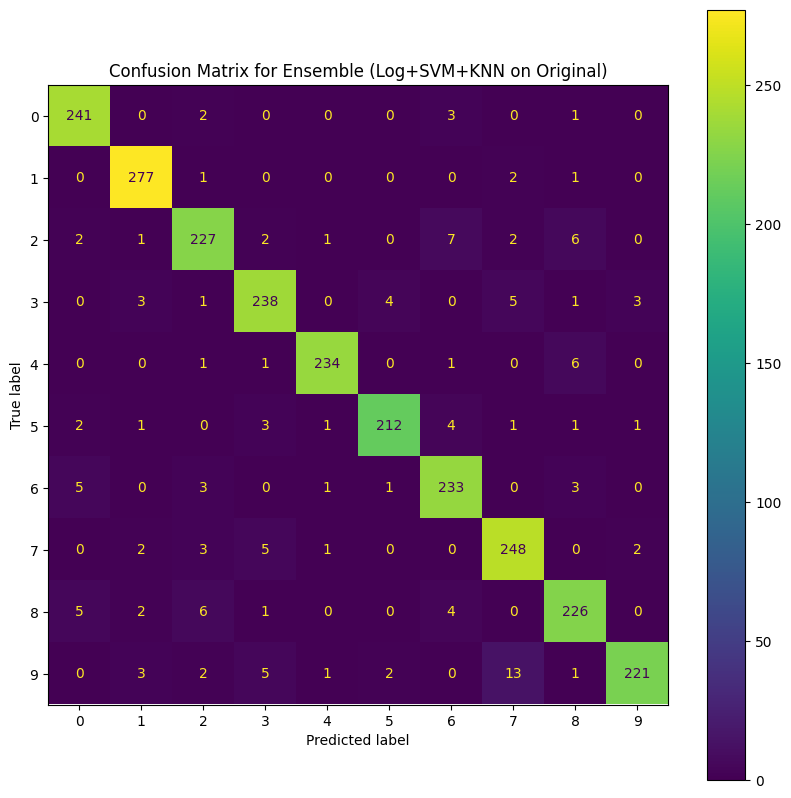

In [41]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import itertools

# --- 1. Import all metrics and models ---
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

# ---
# --- (A) FROM-SCRATCH PREPROCESSING ---
# ---
class MyStandardScaler:
    """ A from-scratch implementation of StandardScaler. """
    def __init__(self):
        self.mean_ = None
        self.std_ = None

    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0) + 1e-9 

    def transform(self, X):
        if self.mean_ is None or self.std_ is None:
            raise ValueError("Must fit() the scaler before transforming.")
        return (X - self.mean_) / self.std_

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

# ---
# --- (B) FROM-SCRATCH MODELS ---
# ---

class MyKNeighborsClassifier:
    """ From-scratch KNN. Fit() is fast, predict() is very slow. """
    def __init__(self, k=5):
        self.k = k
        self.X_train_ = None
        self.y_train_ = None

    def fit(self, X, y):
        self.X_train_ = X
        self.y_train_ = y

    def predict(self, X_test):
        predictions = []
        for i, x in enumerate(X_test):
            if (i + 1) % 100 == 0:
                print(f"    - KNN predicting sample {i+1}/{X_test.shape[0]}...")
            predictions.append(self._predict_one(x))
        return np.array(predictions)

    def _predict_one(self, x_test):
        # Optimized distance calculation
        distances = np.sum((self.X_train_ - x_test)**2, axis=1)
        k_nearest_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = self.y_train_[k_nearest_indices]
        most_common = np.bincount(k_nearest_labels).argmax()
        return most_common

class MyGaussianNB:
    """ From-scratch Gaussian Naive Bayes. """
    def __init__(self):
        self.classes_ = None
        self.means_ = {}
        self.vars_ = {}
        self.priors_ = {}

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_samples, n_features = X.shape
        
        for c in self.classes_:
            X_c = X[y == c]
            self.means_[c] = np.mean(X_c, axis=0)
            self.vars_[c] = np.var(X_c, axis=0) + 1e-9
            self.priors_[c] = X_c.shape[0] / float(n_samples)

    def predict(self, X_test):
        posteriors = np.zeros((X_test.shape[0], len(self.classes_)))
        
        for idx, c in enumerate(self.classes_):
            prior = np.log(self.priors_[c])
            mean = self.means_[c]
            var = self.vars_[c]
            
            # Vectorized log probability calculation
            numerator = np.exp(-((X_test - mean)**2) / (2 * var))
            denominator = np.sqrt(2 * np.pi * var)
            
            # Use np.sum on log probabilities to avoid underflow
            log_pdf_likelihoods = np.sum(np.log(numerator / denominator), axis=1)
            
            posteriors[:, idx] = prior + log_pdf_likelihoods
            
        return self.classes_[np.argmax(posteriors, axis=1)]

class MyTrueMulticlassSVM:
    """ From-scratch 'True' Multiclass SVM (Crammer-Singer). """
    def __init__(self, learning_rate=0.01, lambda_p=0.01, n_iters=1000, batch_size=128):
        self.lr, self.lambda_p, self.n_iters, self.batch_size = learning_rate, lambda_p, n_iters, batch_size
        self.W, self.B, self.classes_, self.n_classes_ = None, None, None, 0

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)
        self.n_classes_ = len(self.classes_)
        
        self.W, self.B = np.zeros((n_features, self.n_classes_)), np.zeros(self.n_classes_)
        
        class_to_index = {c: i for i, c in enumerate(self.classes_)}
        y_indices = np.array([class_to_index[label] for label in y])

        print(f"    - Training True SVM for {self.n_iters} epochs...")
        for epoch in range(self.n_iters):
            if (epoch + 1) % 100 == 0:
                print(f"    - Epoch {epoch+1}/{self.n_iters}")
            
            indices = np.arange(n_samples); np.random.shuffle(indices)
            X_shuffled, y_shuffled = X[indices], y_indices[indices]
            
            for i in range(0, n_samples, self.batch_size):
                X_batch, y_batch = X_shuffled[i : i + self.batch_size], y_shuffled[i : i + self.batch_size]
                batch_n_samples = X_batch.shape[0]

                scores = X_batch @ self.W + self.B
                correct_class_scores = scores[np.arange(batch_n_samples), y_batch].reshape(-1, 1)
                
                margins = scores - correct_class_scores + 1.0
                margins[np.arange(batch_n_samples), y_batch] = 0
                
                violating_class_indices = np.argmax(margins, axis=1)
                max_margins = margins[np.arange(batch_n_samples), violating_class_indices]
                
                missed_mask = max_margins > 0; num_missed = np.sum(missed_mask)
                if num_missed == 0: continue
                
                X_missed, y_true_missed, y_violating_missed = X_batch[missed_mask], y_batch[missed_mask], violating_class_indices[missed_mask]
                
                dW, dB = np.zeros_like(self.W), np.zeros_like(self.B)
                np.subtract.at(dW.T, y_true_missed, X_missed); np.add.at(dW.T, y_violating_missed, X_missed)
                np.subtract.at(dB, y_true_missed, 1); np.add.at(dB, y_violating_missed, 1)
                
                dW, dB = (dW / num_missed) + (self.lambda_p * self.W), dB / num_missed
                self.W -= self.lr * dW; self.B -= self.lr * dB

    def predict(self, X):
        scores = X @ self.W + self.B
        return self.classes_[np.argmax(scores, axis=1)]

class MyMultinomialLogisticRegression:
    """ From-scratch Softmax Regression. """
    def __init__(self, learning_rate=0.01, lambda_p=0.01, n_iters=1000, batch_size=128):
        self.lr, self.lambda_p, self.n_iters, self.batch_size = learning_rate, lambda_p, n_iters, batch_size
        self.W, self.B, self.classes_, self.n_classes_ = None, None, None, 0

    def _softmax(self, x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True)); return e_x / np.sum(e_x, axis=1, keepdims=True)
    
    def _one_hot(self, y_indices, n_classes):
        one_hot = np.zeros((y_indices.shape[0], n_classes)); one_hot[np.arange(y_indices.shape[0]), y_indices] = 1; return one_hot

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)
        self.n_classes_ = len(self.classes_)
        
        self.W, self.B = np.zeros((n_features, self.n_classes_)), np.zeros(self.n_classes_)
        
        class_to_index = {c: i for i, c in enumerate(self.classes_)}
        y_indices = np.array([class_to_index[label] for label in y])
        
        print(f"    - Training Logistic Regression for {self.n_iters} epochs...")
        for epoch in range(self.n_iters):
            if (epoch + 1) % 100 == 0:
                print(f"    - Epoch {epoch+1}/{self.n_iters}")
                
            indices = np.arange(n_samples); np.random.shuffle(indices)
            X_shuffled, y_shuffled_indices = X[indices], y_indices[indices]
            
            for i in range(0, n_samples, self.batch_size):
                X_batch, y_batch_indices = X_shuffled[i : i + self.batch_size], y_shuffled_indices[i : i + self.batch_size]
                batch_n_samples = X_batch.shape[0]
                
                scores = X_batch @ self.W + self.B
                probabilities = self._softmax(scores)
                
                y_one_hot = self._one_hot(y_batch_indices, self.n_classes_)
                grad_scores = probabilities - y_one_hot
                
                dW = (X_batch.T @ grad_scores) / batch_n_samples + (self.lambda_p * self.W)
                dB = np.sum(grad_scores, axis=0) / batch_n_samples
                
                self.W -= self.lr * dW; self.B -= self.lr * dB

    def predict_proba(self, X):
        scores = X @ self.W + self.B; return self._softmax(scores)

    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]

class MyVotingClassifier:
    """
    A from-scratch ensemble voter.
    It takes *predictions* from other models to make a final decision.
    """
    def __init__(self):
        pass # No training needed

    def predict(self, list_of_prediction_arrays):
        """
        Predicts based on a list of prediction arrays (e.g., [ypred_svm, ypred_gnb])
        """
        # Stack predictions: (n_samples, n_models)
        stacked_preds = np.column_stack(list_of_prediction_arrays)
        
        # Find the most common prediction (mode) for each row
        predictions = np.apply_along_axis(
            lambda x: np.bincount(x).argmax(), 
            axis=1, 
            arr=stacked_preds.astype(int) # bincount requires integers
        )
        return predictions

# ---
# --- (C) DATA LOADING & PIPELINE ---
# ---

def load_all_data(base_path, pca_components):
    """ Loads all 4 required data files. """
    print("Loading all datasets...")
    
    # --- File Paths ---
    train_orig_file = base_path + "MNIST_train.csv"
    test_orig_file = base_path + "MNIST_validation.csv"
    train_pca_file = base_path + f"pca_transformed_train_data_n{pca_components}.csv"
    test_pca_file = base_path + f"pca_transformed_validation_data_n{pca_components}.csv"
    
    # --- Load Original Data ---
    df_train_orig = pd.read_csv(train_orig_file)
    Xtrain = df_train_orig.drop(columns=["label"]).values
    ytrain = df_train_orig["label"].values.astype(int)
    
    df_test_orig = pd.read_csv(test_orig_file)
    Xtest = df_test_orig.drop(columns=["label"]).values
    ytest = df_test_orig["label"].values.astype(int)
    
    # --- Load PCA Data ---
    df_train_pca = pd.read_csv(train_pca_file)
    Xtrain_pca = df_train_pca.drop(columns=["label"]).values
    ytrain_pca = df_train_pca["label"].values.astype(int)
    
    df_test_pca = pd.read_csv(test_pca_file)
    Xtest_pca = df_test_pca.drop(columns=["label"]).values
    ytest_pca = df_test_pca["label"].values.astype(int)
    
    print("All data loaded.")
    
    # Return data in a structured dictionary
    return {
        "Original": (Xtrain, ytrain, Xtest, ytest),
        "PCA": (Xtrain_pca, ytrain_pca, Xtest_pca, ytest_pca)
    }

# ---
# --- (D) MAIN EXECUTION ---
# ---

if __name__ == "__main__":
    
    # --- 1. Setup ---
    base_path = r"/home/harshvardhan/ml_lab_project/end-semester-project-Programing-Ninja/"
    n_components = 152
    
    # Load all 4 datasets
    all_data = load_all_data(base_path, n_components)

    # --- 2. Model Configuration ---
    # We use k=3 for KNN on Original to speed it up
    MODEL_CONFIGS = [
        {
            "name": "Logistic on Original",
            "model": MyMultinomialLogisticRegression(learning_rate=0.1, n_iters=1000),
            "data_key": "Original",
            "use_scaler": True
        },
        {
            "name": "SVM on Original",
            "model": MyTrueMulticlassSVM(learning_rate=0.01, n_iters=1000),
            "data_key": "Original",
            "use_scaler": True
        },
        {
            "name": "KNN (k=3) on Original",
            "model": MyKNeighborsClassifier(k=3),
            "data_key": "Original",
            "use_scaler": True,
            "warning": "--- This will be VERY, VERY SLOW ---"
        },
        {
            "name": "GNB on Original",
            "model": MyGaussianNB(),
            "data_key": "Original",
            "use_scaler": False
        },
        {
            "name": "Logistic on PCA",
            "model": MyMultinomialLogisticRegression(learning_rate=0.1, n_iters=1000),
            "data_key": "PCA",
            "use_scaler": True
        },
        {
            "name": "SVM on PCA",
            "model": MyTrueMulticlassSVM(learning_rate=0.01, n_iters=1000),
            "data_key": "PCA",
            "use_scaler": True
        },
        {
            "name": "GNB on PCA",
            "model": MyGaussianNB(),
            "data_key": "PCA",
            "use_scaler": False
        },
        {
            "name": "KNN (k=3) on PCA",
            "model": MyKNeighborsClassifier(k=3),
            "data_key": "PCA",
            "use_scaler": True
        }
    ]

    # --- 3. Run Bake-Off ---
    all_results = []
    all_predictions = {} # Store predictions for our ensemble

    print("\n--- STARTING FROM-SCRATCH MODEL BAKE-OFF ---")

    for config in MODEL_CONFIGS:
        name = config["name"]
        print(f"\n--- Training: {name} ---")
        if "warning" in config:
            print(f"!!! {config['warning']} !!!")
        
        Xtrain, ytrain, Xtest, ytest = all_data[config["data_key"]]
        
        if config["use_scaler"]:
            print("    - Fitting scaler...")
            scaler = MyStandardScaler()
            Xtrain_proc = scaler.fit_transform(Xtrain)
            Xtest_proc = scaler.transform(Xtest)
        else:
            Xtrain_proc = Xtrain
            Xtest_proc = Xtest
            
        model = config["model"]
        print(f"    - Fitting model ({Xtrain_proc.shape[1]} features)...")
        start_time_train = time.time()
        model.fit(Xtrain_proc, ytrain)
        train_time = time.time() - start_time_train
        
        print("    - Predicting...")
        start_time_pred = time.time()
        ypred = model.predict(Xtest_proc)
        predict_time = time.time() - start_time_pred
        
        accuracy = accuracy_score(ytest, ypred)
        f1 = f1_score(ytest, ypred, average='macro')
        
        all_results.append({
            "name": name, "acc": accuracy, "f1": f1,
            "train_time": train_time, "pred_time": predict_time
        })
        all_predictions[name] = ypred

    # --- 4. Run Ensembles ---
    print("\n--- Building Ensembles ---")
    voter = MyVotingClassifier()
    
    # --- Ensemble 1: Top 3 PCA Models ---
    try:
        ensemble_preds_pca = [
            all_predictions["Logistic on PCA"],
            all_predictions["SVM on PCA"],
            all_predictions["GNB on PCA"] # GNB is diverse
        ]
        ytest_pca = all_data["PCA"][3] 
        
        start_time_pred = time.time()
        ypred_ensemble_pca = voter.predict(ensemble_preds_pca)
        predict_time = time.time() - start_time_pred
        
        accuracy = accuracy_score(ytest_pca, ypred_ensemble_pca)
        f1 = f1_score(ytest_pca, ypred_ensemble_pca, average='macro')
        
        all_results.append({
            "name": "Ensemble (Log+SVM+GNB on PCA)",
            "acc": accuracy, "f1": f1, "train_time": 0, "pred_time": predict_time
        })
    except KeyError:
        print("    - Could not run PCA ensemble. Base models not found.")

    # --- NEW Ensemble 2: Top 3 Original Data Models ---
    try:
        ensemble_preds_orig = [
            all_predictions["Logistic on Original"],
            all_predictions["SVM on Original"],
            all_predictions["KNN (k=3) on Original"]
        ]
        ytest_orig = all_data["Original"][3] 

        start_time_pred = time.time()
        ypred_ensemble_orig = voter.predict(ensemble_preds_orig)
        predict_time = time.time() - start_time_pred
        
        accuracy = accuracy_score(ytest_orig, ypred_ensemble_orig)
        f1 = f1_score(ytest_orig, ypred_ensemble_orig, average='macro')
        
        all_results.append({
            "name": "Ensemble (Log+SVM+KNN on Original)",
            "acc": accuracy, "f1": f1, "train_time": 0, "pred_time": predict_time
        })
    except KeyError:
        print("    - Could not run Original Data ensemble. Base models not found.")


    # --- 5. Print Final Leaderboard ---
    all_results.sort(key=lambda x: x["f1"], reverse=True) # Sort by F1

    print("\n\n--- FINAL BAKE-OFF LEADERBOARD (Sorted by F1 Score) ---")
    print(f"{'Model':<40} | {'Accuracy':<10} | {'F1 (Macro)':<10} | {'Train (s)':<10} | {'Predict (s)':<10}")
    print("-" * 95)
    
    for res in all_results:
        print(f"{res['name']:<40} | {res['acc']:<10.4f} | {res['f1']:<10.4f} | {res['train_time']:<10.2f} | {res['pred_time']:<10.2f}")

    # --- 6. Show Confusion Matrix for the Winner ---
    if all_results:
        winner_name = all_results[0]["name"]
        print(f"\n--- Displaying Confusion Matrix for WINNER: {winner_name} ---")
        
        # Find the correct ypred and ytest for the winner
        if winner_name == "Ensemble (Log+SVM+KNN on Original)":
            ypred_winner = ypred_ensemble_orig
            ytest_winner = all_data["Original"][3]
        elif winner_name == "Ensemble (Log+SVM+GNB on PCA)":
            ypred_winner = ypred_ensemble_pca
            ytest_winner = all_data["PCA"][3]
        else:
            ypred_winner = all_predictions[winner_name]
            data_key = [c["data_key"] for c in MODEL_CONFIGS if c["name"] == winner_name][0]
            ytest_winner = all_data[data_key][3]
            
        fig, ax = plt.subplots(figsize=(10, 10))
        ConfusionMatrixDisplay(confusion_matrix(ytest_winner, ypred_winner)).plot(ax=ax)
        plt.title(f'Confusion Matrix for {winner_name}')
        plt.show()

In [42]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

# We can still use scikit-learn for metrics, just not for the models.
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split # To create our validation set

# ---
# --- (A) FROM-SCRATCH MODELS (Copied from our pipeline) ---
# ---

class MyStandardScaler:
    def __init__(self): self.mean_, self.std_ = None, None
    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0) + 1e-9 
    def transform(self, X): return (X - self.mean_) / self.std_
    def fit_transform(self, X): self.fit(X); return self.transform(X)

class MyKNeighborsClassifier:
    def __init__(self, k=5):
        self.k = k
        self.X_train_, self.y_train_ = None, None
    def fit(self, X, y):
        self.X_train_ = X; self.y_train_ = y
    def predict(self, X_test):
        return np.array([self._predict_one(x) for x in X_test])
    def _predict_one(self, x_test):
        distances = np.sum((self.X_train_ - x_test)**2, axis=1)
        k_nearest_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = self.y_train_[k_nearest_indices]
        return np.bincount(k_nearest_labels).argmax()

class MyTrueMulticlassSVM:
    def __init__(self, learning_rate=0.01, lambda_p=0.01, n_iters=1000, batch_size=128):
        self.lr, self.lambda_p, self.n_iters, self.batch_size = learning_rate, lambda_p, n_iters, batch_size
        self.W, self.B, self.classes_, self.n_classes_ = None, None, None, 0
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes_, self.n_classes_ = np.unique(y), len(np.unique(y))
        self.W, self.B = np.zeros((n_features, self.n_classes_)), np.zeros(self.n_classes_)
        class_to_index = {c: i for i, c in enumerate(self.classes_)}
        y_indices = np.array([class_to_index[label] for label in y])
        for epoch in range(self.n_iters):
            if (epoch + 1) % 250 == 0: # Print progress
                print(f"    - SVM Epoch {epoch+1}/{self.n_iters}")
            indices = np.arange(n_samples); np.random.shuffle(indices)
            X_shuffled, y_shuffled = X[indices], y_indices[indices]
            for i in range(0, n_samples, self.batch_size):
                X_batch, y_batch = X_shuffled[i:i+self.batch_size], y_shuffled[i:i+self.batch_size]
                batch_n_samples = X_batch.shape[0]
                scores = X_batch @ self.W + self.B
                correct_class_scores = scores[np.arange(batch_n_samples), y_batch].reshape(-1, 1)
                margins = scores - correct_class_scores + 1.0
                margins[np.arange(batch_n_samples), y_batch] = 0
                violating_class_indices = np.argmax(margins, axis=1)
                max_margins = margins[np.arange(batch_n_samples), violating_class_indices]
                missed_mask = max_margins > 0; num_missed = np.sum(missed_mask)
                if num_missed == 0: continue
                X_missed, y_true_missed, y_violating_missed = X_batch[missed_mask], y_batch[missed_mask], violating_class_indices[missed_mask]
                dW, dB = np.zeros_like(self.W), np.zeros_like(self.B)
                np.subtract.at(dW.T, y_true_missed, X_missed); np.add.at(dW.T, y_violating_missed, X_missed)
                np.subtract.at(dB, y_true_missed, 1); np.add.at(dB, y_violating_missed, 1)
                dW, dB = (dW / num_missed) + (self.lambda_p * self.W), dB / num_missed
                self.W -= self.lr * dW; self.B -= self.lr * dB
    def predict(self, X):
        scores = X @ self.W + self.B
        return self.classes_[np.argmax(scores, axis=1)]

class MyMultinomialLogisticRegression:
    def __init__(self, learning_rate=0.01, lambda_p=0.01, n_iters=1000, batch_size=128):
        self.lr, self.lambda_p, self.n_iters, self.batch_size = learning_rate, lambda_p, n_iters, batch_size
        self.W, self.B, self.classes_, self.n_classes_ = None, None, None, 0
    def _softmax(self, x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True)); return e_x / np.sum(e_x, axis=1, keepdims=True)
    def _one_hot(self, y_indices, n_classes):
        one_hot = np.zeros((y_indices.shape[0], n_classes)); one_hot[np.arange(y_indices.shape[0]), y_indices] = 1; return one_hot
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes_, self.n_classes_ = np.unique(y), len(np.unique(y))
        self.W, self.B = np.zeros((n_features, self.n_classes_)), np.zeros(self.n_classes_)
        class_to_index = {c: i for i, c in enumerate(self.classes_)}
        y_indices = np.array([class_to_index[label] for label in y])
        for epoch in range(self.n_iters):
            if (epoch + 1) % 250 == 0: # Print progress
                print(f"    - LR Epoch {epoch+1}/{self.n_iters}")
            indices = np.arange(n_samples); np.random.shuffle(indices)
            X_shuffled, y_shuffled_indices = X[indices], y_indices[indices]
            for i in range(0, n_samples, self.batch_size):
                X_batch, y_batch_indices = X_shuffled[i:i+self.batch_size], y_shuffled_indices[i:i+self.batch_size]
                batch_n_samples = X_batch.shape[0]
                scores = X_batch @ self.W + self.B
                probabilities = self._softmax(scores)
                y_one_hot = self._one_hot(y_batch_indices, self.n_classes_)
                grad_scores = probabilities - y_one_hot
                dW = (X_batch.T @ grad_scores) / batch_n_samples + (self.lambda_p * self.W)
                dB = np.sum(grad_scores, axis=0) / batch_n_samples
                self.W -= self.lr * dW; self.B -= self.lr * dB
    def predict(self, X):
        scores = X @ self.W + self.B
        return self.classes_[np.argmax(self._softmax(scores), axis=1)]

# ---
# --- (B) HYPERPARAMETER TUNING SCRIPT ---
# ---

if __name__ == "__main__":
    
    # --- 1. Load Original Data ---
    base_path = r"/home/harshvardhan/ml_lab_project/end-semester-project-Programing-Ninja/"
    train_orig_file = base_path + "MNIST_train.csv"
    
    print("Loading original training data...")
    df_train_orig = pd.read_csv(train_orig_file)
    X_orig = df_train_orig.drop(columns=["label"]).values
    y_orig = df_train_orig["label"].values.astype(int)

    # --- 2. Create Train/Validation Split ---
    # We split our training data to create a validation set.
    # We tune on 80% and validate on 20%.
    print("Creating 80/20 train/validation split...")
    X_train_tune, X_val_tune, y_train_tune, y_val_tune = train_test_split(
        X_orig, y_orig, test_size=0.2, random_state=42, stratify=y_orig
    )
    
    # --- 3. Scale Data ---
    # We fit the scaler ONLY on the 80% tune_train split
    print("Scaling data...")
    scaler = MyStandardScaler()
    X_train_tune_scaled = scaler.fit_transform(X_train_tune)
    X_val_tune_scaled = scaler.transform(X_val_tune)

    
    # This dictionary will hold the best-found parameters
    best_params = {}
    
    # --- 4. Tune KNN ---
    # (Note: This is slow because of prediction)
    print("\n--- Tuning MyKNeighborsClassifier ---")
    knn_grid = [3, 5] # Try k=3 and k=5
    best_knn_f1 = -1
    best_knn_k = -1
    
    for k in knn_grid:
        print(f"  - Testing k={k}...")
        model_knn = MyKNeighborsClassifier(k=k)
        
        start_time = time.time()
        model_knn.fit(X_train_tune_scaled, y_train_tune)
        print(f"    - Fit complete (Time: {time.time() - start_time:.2f}s)")
        
        start_time = time.time()
        ypred_knn = model_knn.predict(X_val_tune_scaled)
        print(f"    - Predict complete (Time: {time.time() - start_time:.2f}s)")
        
        f1 = f1_score(y_val_tune, ypred_knn, average='macro')
        print(f"    - k={k} -> F1 Score: {f1:.4f}")
        
        if f1 > best_knn_f1:
            best_knn_f1 = f1
            best_knn_k = k
            
    best_params['knn'] = {'k': best_knn_k}
    print(f"  > Best KNN: k={best_knn_k} (F1: {best_knn_f1:.4f})")

    # --- 5. Tune Logistic Regression ---
    print("\n--- Tuning MyMultinomialLogisticRegression ---")
    # Grid: Try different learning rates and regularization strengths
    log_grid = [
        {'learning_rate': 0.1, 'lambda_p': 0.01, 'n_iters': 1000},
        {'learning_rate': 0.1, 'lambda_p': 0.001, 'n_iters': 1000},
        {'learning_rate': 0.05, 'lambda_p': 0.01, 'n_iters': 1000}
    ]
    best_log_f1 = -1
    best_log_params = {}
    
    for params in log_grid:
        print(f"  - Testing LR={params['learning_rate']}, Lambda={params['lambda_p']}...")
        model_log = MyMultinomialLogisticRegression(**params)
        
        start_time = time.time()
        model_log.fit(X_train_tune_scaled, y_train_tune)
        print(f"    - Fit complete (Time: {time.time() - start_time:.2f}s)")
        
        start_time = time.time()
        ypred_log = model_log.predict(X_val_tune_scaled)
        print(f"    - Predict complete (Time: {time.time() - start_time:.2f}s)")
        
        f1 = f1_score(y_val_tune, ypred_log, average='macro')
        print(f"    - Params -> F1 Score: {f1:.4f}")
        
        if f1 > best_log_f1:
            best_log_f1 = f1
            best_log_params = params
            
    best_params['logistic'] = best_log_params
    print(f"  > Best Logistic: {best_log_params} (F1: {best_log_f1:.4f})")

    # --- 6. Tune SVM ---
    print("\n--- Tuning MyTrueMulticlassSVM ---")
    # Grid: Try different learning rates and regularization strengths
    svm_grid = [
        {'learning_rate': 0.01, 'lambda_p': 0.01, 'n_iters': 1000},
        {'learning_rate': 0.01, 'lambda_p': 0.001, 'n_iters': 1000},
        {'learning_rate': 0.005, 'lambda_p': 0.01, 'n_iters': 1000}
    ]
    best_svm_f1 = -1
    best_svm_params = {}
    
    for params in svm_grid:
        print(f"  - Testing LR={params['learning_rate']}, Lambda={params['lambda_p']}...")
        model_svm = MyTrueMulticlassSVM(**params)
        
        start_time = time.time()
        model_svm.fit(X_train_tune_scaled, y_train_tune)
        print(f"    - Fit complete (Time: {time.time() - start_time:.2f}s)")
        
        start_time = time.time()
        ypred_svm = model_svm.predict(X_val_tune_scaled)
        print(f"    - Predict complete (Time: {time.time() - start_time:.2f}s)")
        
        f1 = f1_score(y_val_tune, ypred_svm, average='macro')
        print(f"    - Params -> F1 Score: {f1:.4f}")
        
        if f1 > best_svm_f1:
            best_svm_f1 = f1
            best_svm_params = params
            
    best_params['svm'] = best_svm_params
    print(f"  > Best SVM: {best_svm_params} (F1: {best_svm_f1:.4f})")

    # --- 7. Final Report ---
    print("\n\n--- HYPERPARAMETER TUNING COMPLETE ---")
    print("Best parameters found:")
    print(f"  KNN:      {best_params['knn']}")
    print(f"  Logistic: {best_params['logistic']}")
    print(f"  SVM:      {best_params['svm']}")
    print("\n > Next step: Use these parameters in the 'model_evaluation_pipeline.py' script!")

Loading original training data...
Creating 80/20 train/validation split...
Scaling data...

--- Tuning MyKNeighborsClassifier ---
  - Testing k=3...
    - Fit complete (Time: 0.00s)
    - Predict complete (Time: 28.79s)
    - k=3 -> F1 Score: 0.8989
  - Testing k=5...
    - Fit complete (Time: 0.00s)
    - Predict complete (Time: 29.18s)
    - k=5 -> F1 Score: 0.9062
  > Best KNN: k=5 (F1: 0.9062)

--- Tuning MyMultinomialLogisticRegression ---
  - Testing LR=0.1, Lambda=0.01...
    - LR Epoch 250/1000
    - LR Epoch 500/1000
    - LR Epoch 750/1000
    - LR Epoch 1000/1000
    - Fit complete (Time: 16.52s)
    - Predict complete (Time: 0.00s)
    - Params -> F1 Score: 0.9312
  - Testing LR=0.1, Lambda=0.001...
    - LR Epoch 250/1000
    - LR Epoch 500/1000
    - LR Epoch 750/1000
    - LR Epoch 1000/1000
    - Fit complete (Time: 16.61s)
    - Predict complete (Time: 0.00s)
    - Params -> F1 Score: 0.9247
  - Testing LR=0.05, Lambda=0.01...
    - LR Epoch 250/1000
    - LR Epoch 500

Loading all datasets...
All data loaded.

--- STARTING **TUNED** MODEL BAKE-OFF (Original Data Only) ---

--- Training: Logistic on Original ---
    - Fitting scaler...
    - Fitting model (785 features)...
    - Training Logistic Regression for 1000 epochs...
    - Epoch 250/1000
    - Epoch 500/1000
    - Epoch 750/1000
    - Epoch 1000/1000
    - Predicting...

--- Training: SVM on Original ---
    - Fitting scaler...
    - Fitting model (785 features)...
    - Training True SVM for 1000 epochs...
    - Epoch 250/1000
    - Epoch 500/1000
    - Epoch 750/1000
    - Epoch 1000/1000
    - Predicting...

--- Training: KNN (k=5) on Original ---
!!! --- This will be VERY, VERY SLOW --- !!!
    - Fitting scaler...
    - Fitting model (785 features)...
    - Predicting...
    - KNN predicting sample 100/2499...
    - KNN predicting sample 200/2499...
    - KNN predicting sample 300/2499...
    - KNN predicting sample 400/2499...
    - KNN predicting sample 500/2499...
    - KNN predicting 

/tmp/ipykernel_4959/2871698970.py:64: RuntimeWarning: divide by zero encountered in log
  log_pdf_likelihoods = np.sum(np.log(numerator / denominator), axis=1)



--- Building **Tuned** Ensemble ---


--- FINAL **TUNED** BAKE-OFF LEADERBOARD (Sorted by F1 Score) ---
Model                                              | Accuracy   | F1 (Macro) | Train (s)  | Predict (s)
-----------------------------------------------------------------------------------------------
Ensemble (Log+SVM+KNN on Original) - TUNED         | 0.9428     | 0.9426     | 0.00       | 0.00      
Logistic on Original                               | 0.9380     | 0.9378     | 57.90      | 0.00      
KNN (k=5) on Original                              | 0.9208     | 0.9199     | 0.00       | 42.01     
SVM on Original                                    | 0.9152     | 0.9147     | 55.31      | 0.00      
GNB on Original                                    | 0.6815     | 0.6592     | 0.05       | 0.17      

--- Displaying Confusion Matrix for WINNER: Ensemble (Log+SVM+KNN on Original) - TUNED ---


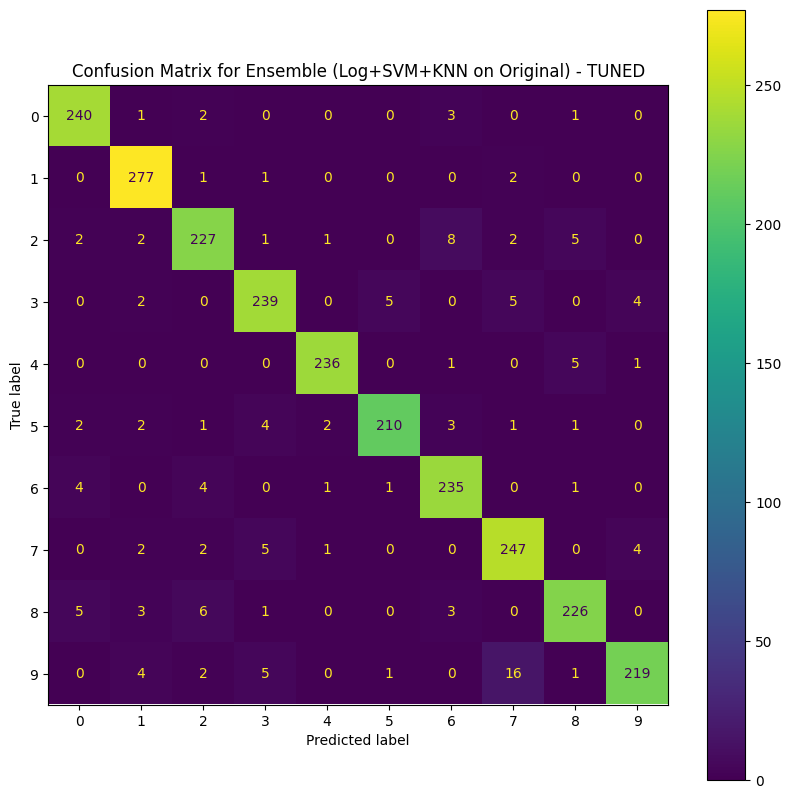

In [44]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import itertools

# --- 1. Import all metrics and models ---
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

# ---
# --- (A) FROM-SCRATCH PREPROCESSING ---
# ---
class MyStandardScaler:
    """ A from-scratch implementation of StandardScaler. """
    def __init__(self): self.mean_, self.std_ = None, None
    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0) + 1e-9 
    def transform(self, X): return (X - self.mean_) / self.std_
    def fit_transform(self, X): self.fit(X); return self.transform(X)

# ---
# --- (B) FROM-SCRATCH MODELS ---
# ---

class MyKNeighborsClassifier:
    """ From-scratch KNN. Fit() is fast, predict() is very slow. """
    def __init__(self, k=5):
        self.k = k
        self.X_train_, self.y_train_ = None, None
    def fit(self, X, y):
        self.X_train_ = X; self.y_train_ = y
    def predict(self, X_test):
        predictions = []
        for i, x in enumerate(X_test):
            if (i + 1) % 100 == 0:
                print(f"    - KNN predicting sample {i+1}/{X_test.shape[0]}...")
            predictions.append(self._predict_one(x))
        return np.array(predictions)
    def _predict_one(self, x_test):
        distances = np.sum((self.X_train_ - x_test)**2, axis=1)
        k_nearest_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = self.y_train_[k_nearest_indices]
        return np.bincount(k_nearest_labels).argmax()

class MyGaussianNB:
    """ From-scratch Gaussian Naive Bayes. """
    def __init__(self): self.classes_, self.means_, self.vars_, self.priors_ = None, {}, {}, {}
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_samples, n_features = X.shape
        for c in self.classes_:
            X_c = X[y == c]
            self.means_[c] = np.mean(X_c, axis=0)
            self.vars_[c] = np.var(X_c, axis=0) + 1e-9
            self.priors_[c] = X_c.shape[0] / float(n_samples)
    def predict(self, X_test):
        posteriors = np.zeros((X_test.shape[0], len(self.classes_)))
        for idx, c in enumerate(self.classes_):
            prior = np.log(self.priors_[c])
            mean = self.means_[c]; var = self.vars_[c]
            numerator = np.exp(-((X_test - mean)**2) / (2 * var))
            denominator = np.sqrt(2 * np.pi * var)
            log_pdf_likelihoods = np.sum(np.log(numerator / denominator), axis=1)
            posteriors[:, idx] = prior + log_pdf_likelihoods
        return self.classes_[np.argmax(posteriors, axis=1)]

class MyTrueMulticlassSVM:
    """ From-scratch 'True' Multiclass SVM (Crammer-Singer). """
    def __init__(self, learning_rate=0.01, lambda_p=0.01, n_iters=1000, batch_size=128):
        self.lr, self.lambda_p, self.n_iters, self.batch_size = learning_rate, lambda_p, n_iters, batch_size
        self.W, self.B, self.classes_, self.n_classes_ = None, None, None, 0
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes_, self.n_classes_ = np.unique(y), len(np.unique(y))
        self.W, self.B = np.zeros((n_features, self.n_classes_)), np.zeros(self.n_classes_)
        class_to_index = {c: i for i, c in enumerate(self.classes_)}
        y_indices = np.array([class_to_index[label] for label in y])
        print(f"    - Training True SVM for {self.n_iters} epochs...")
        for epoch in range(self.n_iters):
            if (epoch + 1) % 250 == 0:
                print(f"    - Epoch {epoch+1}/{self.n_iters}")
            indices = np.arange(n_samples); np.random.shuffle(indices)
            X_shuffled, y_shuffled = X[indices], y_indices[indices]
            for i in range(0, n_samples, self.batch_size):
                X_batch, y_batch = X_shuffled[i:i+self.batch_size], y_shuffled[i:i+self.batch_size]
                batch_n_samples = X_batch.shape[0]
                scores = X_batch @ self.W + self.B
                correct_class_scores = scores[np.arange(batch_n_samples), y_batch].reshape(-1, 1)
                margins = scores - correct_class_scores + 1.0
                margins[np.arange(batch_n_samples), y_batch] = 0
                violating_class_indices = np.argmax(margins, axis=1)
                max_margins = margins[np.arange(batch_n_samples), violating_class_indices]
                missed_mask = max_margins > 0; num_missed = np.sum(missed_mask)
                if num_missed == 0: continue
                X_missed, y_true_missed, y_violating_missed = X_batch[missed_mask], y_batch[missed_mask], violating_class_indices[missed_mask]
                dW, dB = np.zeros_like(self.W), np.zeros_like(self.B)
                np.subtract.at(dW.T, y_true_missed, X_missed); np.add.at(dW.T, y_violating_missed, X_missed)
                np.subtract.at(dB, y_true_missed, 1); np.add.at(dB, y_violating_missed, 1)
                dW, dB = (dW / num_missed) + (self.lambda_p * self.W), dB / num_missed
                self.W -= self.lr * dW; self.B -= self.lr * dB
    def predict(self, X):
        scores = X @ self.W + self.B
        return self.classes_[np.argmax(scores, axis=1)]

class MyMultinomialLogisticRegression:
    """ From-scratch Softmax Regression. """
    def __init__(self, learning_rate=0.01, lambda_p=0.01, n_iters=1000, batch_size=128):
        self.lr, self.lambda_p, self.n_iters, self.batch_size = learning_rate, lambda_p, n_iters, batch_size
        self.W, self.B, self.classes_, self.n_classes_ = None, None, None, 0
    def _softmax(self, x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True)); return e_x / np.sum(e_x, axis=1, keepdims=True)
    def _one_hot(self, y_indices, n_classes):
        one_hot = np.zeros((y_indices.shape[0], n_classes)); one_hot[np.arange(y_indices.shape[0]), y_indices] = 1; return one_hot
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes_, self.n_classes_ = np.unique(y), len(np.unique(y))
        self.W, self.B = np.zeros((n_features, self.n_classes_)), np.zeros(self.n_classes_)
        class_to_index = {c: i for i, c in enumerate(self.classes_)}
        y_indices = np.array([class_to_index[label] for label in y])
        print(f"    - Training Logistic Regression for {self.n_iters} epochs...")
        for epoch in range(self.n_iters):
            if (epoch + 1) % 250 == 0:
                print(f"    - Epoch {epoch+1}/{self.n_iters}")
            indices = np.arange(n_samples); np.random.shuffle(indices)
            X_shuffled, y_shuffled_indices = X[indices], y_indices[indices]
            for i in range(0, n_samples, self.batch_size):
                X_batch, y_batch_indices = X_shuffled[i:i+self.batch_size], y_shuffled_indices[i:i+self.batch_size]
                batch_n_samples = X_batch.shape[0]
                scores = X_batch @ self.W + self.B
                probabilities = self._softmax(scores)
                y_one_hot = self._one_hot(y_batch_indices, self.n_classes_)
                grad_scores = probabilities - y_one_hot
                dW = (X_batch.T @ grad_scores) / batch_n_samples + (self.lambda_p * self.W)
                dB = np.sum(grad_scores, axis=0) / batch_n_samples
                self.W -= self.lr * dW; self.B -= self.lr * dB
    def predict(self, X):
        return self.classes_[np.argmax(self._softmax(X @ self.W + self.B), axis=1)]

class MyVotingClassifier:
    """ A from-scratch ensemble voter. """
    def __init__(self): pass
    def predict(self, list_of_prediction_arrays):
        stacked_preds = np.column_stack(list_of_prediction_arrays)
        return np.apply_along_axis(
            lambda x: np.bincount(x).argmax(), 
            axis=1, 
            arr=stacked_preds.astype(int)
        )
# ---
# --- (C) DATA LOADING & PIPELINE ---
# ---
def load_all_data(base_path, pca_components):
    """ Loads all 4 required data files. """
    print("Loading all datasets...")
    train_orig_file = base_path + "MNIST_train.csv"
    test_orig_file = base_path + "MNIST_validation.csv"
    train_pca_file = base_path + f"pca_transformed_train_data_n{pca_components}.csv"
    test_pca_file = base_path + f"pca_transformed_validation_data_n{pca_components}.csv"
    
    df_train_orig = pd.read_csv(train_orig_file)
    Xtrain, ytrain = df_train_orig.drop(columns=["label"]).values, df_train_orig["label"].values.astype(int)
    
    df_test_orig = pd.read_csv(test_orig_file)
    Xtest, ytest = df_test_orig.drop(columns=["label"]).values, df_test_orig["label"].values.astype(int)
    
    df_train_pca = pd.read_csv(train_pca_file)
    Xtrain_pca, ytrain_pca = df_train_pca.drop(columns=["label"]).values, df_train_pca["label"].values.astype(int)
    
    df_test_pca = pd.read_csv(test_pca_file)
    Xtest_pca, ytest_pca = df_test_pca.drop(columns=["label"]).values, df_test_pca["label"].values.astype(int)
    
    print("All data loaded.")
    return {
        "Original": (Xtrain, ytrain, Xtest, ytest),
        "PCA": (Xtrain_pca, ytrain_pca, Xtest_pca, ytest_pca)
    }

# ---
# --- (D) MAIN EXECUTION ---
# ---
if __name__ == "__main__":
    
    # --- 1. Setup ---
    base_path = r"/home/harshvardhan/ml_lab_project/end-semester-project-Programing-Ninja/"
    n_components = 152
    all_data = load_all_data(base_path, n_components)

    # --- 2. Model Configuration ---
    # !!! THESE ARE THE NEW TUNED PARAMETERS YOU FOUND !!!
    MODEL_CONFIGS = [
        {
            "name": "Logistic on Original",
            "model": MyMultinomialLogisticRegression(learning_rate=0.1, lambda_p=0.01, n_iters=1000),
            "data_key": "Original", "use_scaler": True
        },
        {
            "name": "SVM on Original",
            "model": MyTrueMulticlassSVM(learning_rate=0.01, lambda_p=0.001, n_iters=1000),
            "data_key": "Original", "use_scaler": True
        },
        {
            "name": "KNN (k=5) on Original",
            "model": MyKNeighborsClassifier(k=5), # k=5 was the winner
            "data_key": "Original", "use_scaler": True,
            "warning": "--- This will be VERY, VERY SLOW ---"
        },
        {
            "name": "GNB on Original",
            "model": MyGaussianNB(),
            "data_key": "Original", "use_scaler": False
        },
    ]

    # --- 3. Run Bake-Off ---
    all_results = []
    all_predictions = {} 
    print("\n--- STARTING **TUNED** MODEL BAKE-OFF (Original Data Only) ---")

    for config in MODEL_CONFIGS:
        name = config["name"]
        print(f"\n--- Training: {name} ---")
        if "warning" in config: print(f"!!! {config['warning']} !!!")
        
        Xtrain, ytrain, Xtest, ytest = all_data[config["data_key"]]
        
        if config["use_scaler"]:
            print("    - Fitting scaler...")
            scaler = MyStandardScaler()
            Xtrain_proc = scaler.fit_transform(Xtrain)
            Xtest_proc = scaler.transform(Xtest)
        else:
            Xtrain_proc = Xtrain; Xtest_proc = Xtest
            
        model = config["model"]
        print(f"    - Fitting model ({Xtrain_proc.shape[1]} features)...")
        start_time_train = time.time()
        model.fit(Xtrain_proc, ytrain)
        train_time = time.time() - start_time_train
        
        print("    - Predicting...")
        start_time_pred = time.time()
        ypred = model.predict(Xtest_proc)
        predict_time = time.time() - start_time_pred
        
        accuracy = accuracy_score(ytest, ypred)
        f1 = f1_score(ytest, ypred, average='macro')
        
        all_results.append({
            "name": name, "acc": accuracy, "f1": f1,
            "train_time": train_time, "pred_time": predict_time
        })
        all_predictions[name] = ypred

    # --- 4. Run Tuned Ensemble ---
    print("\n--- Building **Tuned** Ensemble ---")
    voter = MyVotingClassifier()
    
    try:
        ensemble_preds_orig = [
            all_predictions["Logistic on Original"],
            all_predictions["SVM on Original"],
            all_predictions["KNN (k=5) on Original"]
        ]
        ytest_orig = all_data["Original"][3] 

        start_time_pred = time.time()
        ypred_ensemble_orig = voter.predict(ensemble_preds_orig)
        predict_time = time.time() - start_time_pred
        
        accuracy = accuracy_score(ytest_orig, ypred_ensemble_orig)
        f1 = f1_score(ytest_orig, ypred_ensemble_orig, average='macro')
        
        all_results.append({
            "name": "Ensemble (Log+SVM+KNN on Original) - TUNED",
            "acc": accuracy, "f1": f1, "train_time": 0, "pred_time": predict_time
        })
    except KeyError as e:
        print(f"    - Could not run Tuned Original Data ensemble. Missing model: {e}")

    # --- 5. Print Final Leaderboard ---
    all_results.sort(key=lambda x: x["f1"], reverse=True)
    print("\n\n--- FINAL **TUNED** BAKE-OFF LEADERBOARD (Sorted by F1 Score) ---")
    print(f"{'Model':<50} | {'Accuracy':<10} | {'F1 (Macro)':<10} | {'Train (s)':<10} | {'Predict (s)':<10}")
    print("-" * 95)
    for res in all_results:
        print(f"{res['name']:<50} | {res['acc']:<10.4f} | {res['f1']:<10.4f} | {res['train_time']:<10.2f} | {res['pred_time']:<10.2f}")

    # --- 6. Show Confusion Matrix for the Winner ---
    if all_results:
        winner_name = all_results[0]["name"]
        print(f"\n--- Displaying Confusion Matrix for WINNER: {winner_name} ---")
        
        if "Ensemble" in winner_name:
            ypred_winner = ypred_ensemble_orig
            ytest_winner = all_data["Original"][3]
        else:
            ypred_winner = all_predictions[winner_name]
            ytest_winner = all_data["Original"][3]
            
        fig, ax = plt.subplots(figsize=(10, 10))
        ConfusionMatrixDisplay(confusion_matrix(ytest_winner, ypred_winner)).plot(ax=ax)
        plt.title(f'Confusion Matrix for {winner_name}')
        plt.show()

In [45]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# --- (A) FROM-SCRATCH MODELS (Paste all 4 classes: MyStandardScaler, MyKNeighborsClassifier, MyTrueMulticlassSVM, MyMultinomialLogisticRegression) ---

class MyStandardScaler:
    def __init__(self): self.mean_, self.std_ = None, None
    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0) + 1e-9 
    def transform(self, X): return (X - self.mean_) / self.std_
    def fit_transform(self, X): self.fit(X); return self.transform(X)

class MyKNeighborsClassifier:
    def __init__(self, k=5):
        self.k = k
        self.X_train_, self.y_train_ = None, None
    def fit(self, X, y):
        self.X_train_ = X; self.y_train_ = y
    def predict(self, X_test):
        # Optimized predict for tuning (still slow, but better)
        predictions = []
        for i, x in enumerate(X_test):
            if (i + 1) % 1000 == 0:
                print(f"    - KNN predicting sample {i+1}/{X_test.shape[0]}...")
            predictions.append(self._predict_one(x))
        return np.array(predictions)
    def _predict_one(self, x_test):
        distances = np.sum((self.X_train_ - x_test)**2, axis=1)
        k_nearest_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = self.y_train_[k_nearest_indices]
        return np.bincount(k_nearest_labels).argmax()

class MyTrueMulticlassSVM:
    def __init__(self, learning_rate=0.01, lambda_p=0.01, n_iters=1000, batch_size=128):
        self.lr, self.lambda_p, self.n_iters, self.batch_size = learning_rate, lambda_p, n_iters, batch_size
        self.W, self.B, self.classes_, self.n_classes_ = None, None, None, 0
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes_, self.n_classes_ = np.unique(y), len(np.unique(y))
        self.W, self.B = np.zeros((n_features, self.n_classes_)), np.zeros(self.n_classes_)
        class_to_index = {c: i for i, c in enumerate(self.classes_)}
        y_indices = np.array([class_to_index[label] for label in y])
        for epoch in range(self.n_iters):
            if (epoch + 1) % 500 == 0: # Print progress
                print(f"    - SVM Epoch {epoch+1}/{self.n_iters}")
            indices = np.arange(n_samples); np.random.shuffle(indices)
            X_shuffled, y_shuffled = X[indices], y_indices[indices]
            for i in range(0, n_samples, self.batch_size):
                X_batch, y_batch = X_shuffled[i:i+self.batch_size], y_shuffled[i:i+self.batch_size]
                batch_n_samples = X_batch.shape[0]
                scores = X_batch @ self.W + self.B
                correct_class_scores = scores[np.arange(batch_n_samples), y_batch].reshape(-1, 1)
                margins = scores - correct_class_scores + 1.0
                margins[np.arange(batch_n_samples), y_batch] = 0
                violating_class_indices = np.argmax(margins, axis=1)
                max_margins = margins[np.arange(batch_n_samples), violating_class_indices]
                missed_mask = max_margins > 0; num_missed = np.sum(missed_mask)
                if num_missed == 0: continue
                X_missed, y_true_missed, y_violating_missed = X_batch[missed_mask], y_batch[missed_mask], violating_class_indices[missed_mask]
                dW, dB = np.zeros_like(self.W), np.zeros_like(self.B)
                np.subtract.at(dW.T, y_true_missed, X_missed); np.add.at(dW.T, y_violating_missed, X_missed)
                np.subtract.at(dB, y_true_missed, 1); np.add.at(dB, y_violating_missed, 1)
                dW, dB = (dW / num_missed) + (self.lambda_p * self.W), dB / num_missed
                self.W -= self.lr * dW; self.B -= self.lr * dB
    def predict(self, X):
        scores = X @ self.W + self.B
        return self.classes_[np.argmax(scores, axis=1)]

class MyMultinomialLogisticRegression:
    def __init__(self, learning_rate=0.01, lambda_p=0.01, n_iters=1000, batch_size=128):
        self.lr, self.lambda_p, self.n_iters, self.batch_size = learning_rate, lambda_p, n_iters, batch_size
        self.W, self.B, self.classes_, self.n_classes_ = None, None, None, 0
    def _softmax(self, x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True)); return e_x / np.sum(e_x, axis=1, keepdims=True)
    def _one_hot(self, y_indices, n_classes):
        one_hot = np.zeros((y_indices.shape[0], n_classes)); one_hot[np.arange(y_indices.shape[0]), y_indices] = 1; return one_hot
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes_, self.n_classes_ = np.unique(y), len(np.unique(y))
        self.W, self.B = np.zeros((n_features, self.n_classes_)), np.zeros(self.n_classes_)
        class_to_index = {c: i for i, c in enumerate(self.classes_)}
        y_indices = np.array([class_to_index[label] for label in y])
        for epoch in range(self.n_iters):
            if (epoch + 1) % 500 == 0: # Print progress
                print(f"    - LR Epoch {epoch+1}/{self.n_iters}")
            indices = np.arange(n_samples); np.random.shuffle(indices)
            X_shuffled, y_shuffled_indices = X[indices], y_indices[indices]
            for i in range(0, n_samples, self.batch_size):
                X_batch, y_batch_indices = X_shuffled[i:i+self.batch_size], y_shuffled_indices[i:i+self.batch_size]
                batch_n_samples = X_batch.shape[0]
                scores = X_batch @ self.W + self.B
                probabilities = self._softmax(scores)
                y_one_hot = self._one_hot(y_batch_indices, self.n_classes_)
                grad_scores = probabilities - y_one_hot
                dW = (X_batch.T @ grad_scores) / batch_n_samples + (self.lambda_p * self.W)
                dB = np.sum(grad_scores, axis=0) / batch_n_samples
                self.W -= self.lr * dW; self.B -= self.lr * dB
    def predict(self, X):
        return self.classes_[np.argmax(self._softmax(X @ self.W + self.B), axis=1)]

# ---
# --- (B) HYPERPARAMETER TUNING SCRIPT (ROUND 2) ---
# ---

if __name__ == "__main__":
    
    # --- 1. Load Original Data ---
    base_path = r"/home/harshvardhan/ml_lab_project/end-semester-project-Programing-Ninja/"
    train_orig_file = base_path + "MNIST_train.csv"
    
    print("Loading original training data...")
    df_train_orig = pd.read_csv(train_orig_file)
    X_orig = df_train_orig.drop(columns=["label"]).values
    y_orig = df_train_orig["label"].values.astype(int)

    # --- 2. Create Train/Validation Split ---
    print("Creating 80/20 train/validation split...")
    X_train_tune, X_val_tune, y_train_tune, y_val_tune = train_test_split(
        X_orig, y_orig, test_size=0.2, random_state=42, stratify=y_orig
    )
    
    # --- 3. Scale Data ---
    print("Scaling data...")
    scaler = MyStandardScaler()
    X_train_tune_scaled = scaler.fit_transform(X_train_tune)
    X_val_tune_scaled = scaler.transform(X_val_tune)

    best_params = {}
    
    # --- 4. Tune KNN (Round 2) ---
    print("\n--- Tuning MyKNeighborsClassifier (Round 2) ---")
    # Old grid: [3, 5]. Winner: 5.
    # New grid explores higher values.
    knn_grid = [5, 7, 9] 
    best_knn_f1 = -1
    best_knn_k = -1
    
    for k in knn_grid:
        print(f"  - Testing k={k}...")
        model_knn = MyKNeighborsClassifier(k=k)
        
        start_time = time.time()
        model_knn.fit(X_train_tune_scaled, y_train_tune)
        print(f"    - Fit complete (Time: {time.time() - start_time:.2f}s)")
        
        start_time = time.time()
        ypred_knn = model_knn.predict(X_val_tune_scaled)
        print(f"    - Predict complete (Time: {time.time() - start_time:.2f}s)")
        
        f1 = f1_score(y_val_tune, ypred_knn, average='macro')
        print(f"    - k={k} -> F1 Score: {f1:.4f}")
        
        if f1 > best_knn_f1: best_knn_f1 = f1; best_knn_k = k
            
    best_params['knn'] = {'k': best_knn_k}
    print(f"  > Best KNN: k={best_knn_k} (F1: {best_knn_f1:.4f})")

    # --- 5. Tune Logistic Regression (Round 2) ---
    print("\n--- Tuning MyMultinomialLogisticRegression (Round 2) ---")
    # Old Winner: {'learning_rate': 0.1, 'lambda_p': 0.01}
    # We explore higher LR and higher lambda.
    log_grid = [
        {'learning_rate': 0.1, 'lambda_p': 0.01, 'n_iters': 1000}, # The old champ
        {'learning_rate': 0.2, 'lambda_p': 0.01, 'n_iters': 1000}, # Push LR
        {'learning_rate': 0.1, 'lambda_p': 0.1, 'n_iters': 1000}   # Push lambda
    ]
    best_log_f1 = -1
    best_log_params = {}
    
    for params in log_grid:
        print(f"  - Testing LR={params['learning_rate']}, Lambda={params['lambda_p']}...")
        model_log = MyMultinomialLogisticRegression(**params)
        
        start_time = time.time()
        model_log.fit(X_train_tune_scaled, y_train_tune)
        print(f"    - Fit complete (Time: {time.time() - start_time:.2f}s)")
        
        start_time = time.time()
        ypred_log = model_log.predict(X_val_tune_scaled)
        print(f"    - Predict complete (Time: {time.time() - start_time:.2f}s)")
        
        f1 = f1_score(y_val_tune, ypred_log, average='macro')
        print(f"    - Params -> F1 Score: {f1:.4f}")
        
        if f1 > best_log_f1: best_log_f1 = f1; best_log_params = params
            
    best_params['logistic'] = best_log_params
    print(f"  > Best Logistic: {best_log_params} (F1: {best_log_f1:.4f})")

    # --- 6. Tune SVM (Round 2) ---
    print("\n--- Tuning MyTrueMulticlassSVM (Round 2) ---")
    # Old Winner: {'learning_rate': 0.01, 'lambda_p': 0.001}
    # We explore higher LR and lower lambda.
    svm_grid = [
        {'learning_rate': 0.01, 'lambda_p': 0.001, 'n_iters': 1000}, # The old champ
        {'learning_rate': 0.02, 'lambda_p': 0.001, 'n_iters': 1000}, # Push LR
        {'learning_rate': 0.01, 'lambda_p': 0.0001, 'n_iters': 1000} # Push lambda down
    ]
    best_svm_f1 = -1
    best_svm_params = {}
    
    for params in svm_grid:
        print(f"  - Testing LR={params['learning_rate']}, Lambda={params['lambda_p']}...")
        model_svm = MyTrueMulticlassSVM(**params)
        
        start_time = time.time()
        model_svm.fit(X_train_tune_scaled, y_train_tune)
        print(f"    - Fit complete (Time: {time.time() - start_time:.2f}s)")
        
        start_time = time.time()
        ypred_svm = model_svm.predict(X_val_tune_scaled)
        print(f"    - Predict complete (Time: {time.time() - start_time:.2f}s)")
        
        f1 = f1_score(y_val_tune, ypred_svm, average='macro')
        print(f"    - Params -> F1 Score: {f1:.4f}")
        
        if f1 > best_svm_f1: best_svm_f1 = f1; best_svm_params = params
            
    best_params['svm'] = best_svm_params
    print(f"  > Best SVM: {best_svm_params} (F1: {best_svm_f1:.4f})")

    # --- 7. Final Report ---
    print("\n\n--- ROUND 2 TUNING COMPLETE ---")
    print("Best parameters found:")
    print(f"  KNN:      {best_params['knn']}")
    print(f"  Logistic: {best_params['logistic']}")
    print(f"  SVM:      {best_params['svm']}")
    print("\n > Next step: Use these new parameters in the 'model_evaluation_pipeline.py' script!")

Loading original training data...
Creating 80/20 train/validation split...
Scaling data...

--- Tuning MyKNeighborsClassifier (Round 2) ---
  - Testing k=5...
    - Fit complete (Time: 0.00s)
    - KNN predicting sample 1000/2001...
    - KNN predicting sample 2000/2001...
    - Predict complete (Time: 30.68s)
    - k=5 -> F1 Score: 0.9062
  - Testing k=7...
    - Fit complete (Time: 0.00s)
    - KNN predicting sample 1000/2001...
    - KNN predicting sample 2000/2001...
    - Predict complete (Time: 29.53s)
    - k=7 -> F1 Score: 0.9023
  - Testing k=9...
    - Fit complete (Time: 0.00s)
    - KNN predicting sample 1000/2001...
    - KNN predicting sample 2000/2001...
    - Predict complete (Time: 31.00s)
    - k=9 -> F1 Score: 0.9041
  > Best KNN: k=5 (F1: 0.9062)

--- Tuning MyMultinomialLogisticRegression (Round 2) ---
  - Testing LR=0.1, Lambda=0.01...
    - LR Epoch 500/1000
    - LR Epoch 1000/1000
    - Fit complete (Time: 17.05s)
    - Predict complete (Time: 0.00s)
    - Para

Loading all datasets...
All data loaded.

--- STARTING **TUNED** MODEL BAKE-OFF (Original Data Only) ---

--- Training: Logistic on Original (Tuned) ---
    - Fitting scaler...
    - Fitting model (785 features)...
    - Training Logistic Regression for 1000 epochs...
    - Epoch 250/1000
    - Epoch 500/1000
    - Epoch 750/1000
    - Epoch 1000/1000
    - Predicting...

--- Training: SVM on Original (Tuned) ---
    - Fitting scaler...
    - Fitting model (785 features)...
    - Training True SVM for 1000 epochs...
    - Epoch 250/1000
    - Epoch 500/1000
    - Epoch 750/1000
    - Epoch 1000/1000
    - Predicting...

--- Training: KNN (k=5) on Original (Tuned) ---
!!! --- This will be VERY, VERY SLOW --- !!!
    - Fitting scaler...
    - Fitting model (785 features)...
    - Predicting...
    - KNN predicting sample 100/2499...
    - KNN predicting sample 200/2499...
    - KNN predicting sample 300/2499...
    - KNN predicting sample 400/2499...
    - KNN predicting sample 500/2499.

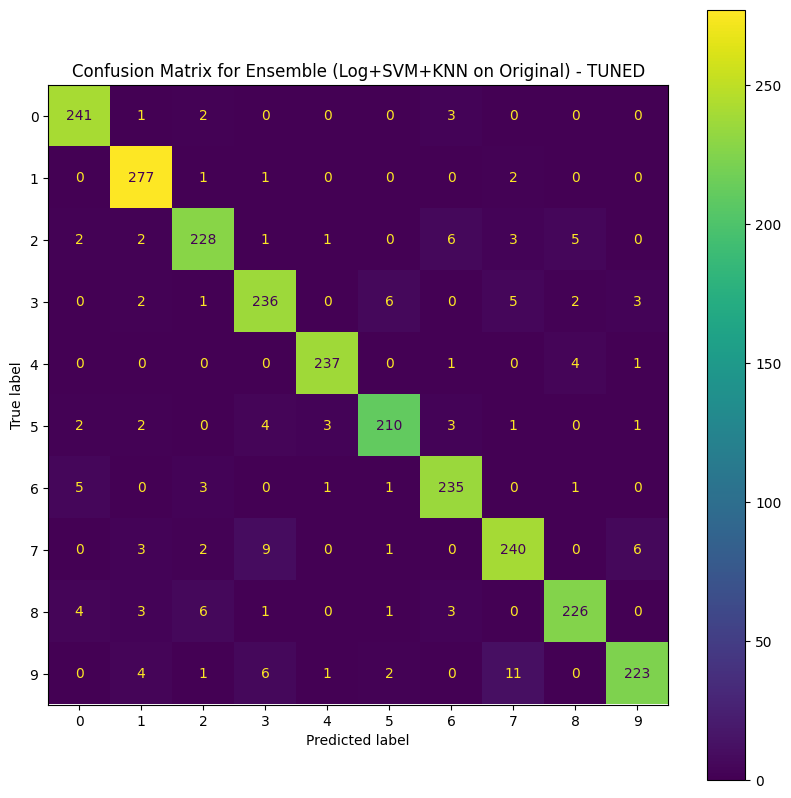

In [47]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import itertools

# --- 1. Import all metrics and models ---
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

# ---
# --- (A) FROM-SCRATCH PREPROCESSING ---
# ---
class MyStandardScaler:
    """ A from-scratch implementation of StandardScaler. """
    def __init__(self): self.mean_, self.std_ = None, None
    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0) + 1e-9 
    def transform(self, X): 
        if self.mean_ is None: raise ValueError("Scaler not fitted")
        return (X - self.mean_) / self.std_
    def fit_transform(self, X): self.fit(X); return self.transform(X)

# ---
# --- (B) FROM-SCRATCH MODELS ---
# ---

class MyKNeighborsClassifier:
    """ From-scratch KNN. Fit() is fast, predict() is very slow. """
    def __init__(self, k=5):
        self.k = k
        self.X_train_, self.y_train_ = None, None
    def fit(self, X, y):
        self.X_train_ = X; self.y_train_ = y
    def predict(self, X_test):
        predictions = []
        for i, x in enumerate(X_test):
            if (i + 1) % 100 == 0:
                print(f"    - KNN predicting sample {i+1}/{X_test.shape[0]}...")
            predictions.append(self._predict_one(x))
        return np.array(predictions)
    def _predict_one(self, x_test):
        # Using optimized L2 (Euclidean) distance squared
        distances = np.sum((self.X_train_ - x_test)**2, axis=1)
        k_nearest_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = self.y_train_[k_nearest_indices]
        return np.bincount(k_nearest_labels).argmax()

class MyGaussianNB:
    """ From-scratch Gaussian Naive Bayes. """
    def __init__(self): self.classes_, self.means_, self.vars_, self.priors_ = None, {}, {}, {}
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        n_samples, n_features = X.shape
        for c in self.classes_:
            X_c = X[y == c]
            self.means_[c] = np.mean(X_c, axis=0)
            self.vars_[c] = np.var(X_c, axis=0) + 1e-9
            self.priors_[c] = X_c.shape[0] / float(n_samples)
    def predict(self, X_test):
        posteriors = np.zeros((X_test.shape[0], len(self.classes_)))
        for idx, c in enumerate(self.classes_):
            prior = np.log(self.priors_[c])
            mean = self.means_[c]; var = self.vars_[c]
            # Handle features with 0 variance (e.g., empty borders)
            # Use log-sum-exp trick for numerical stability
            var_inv = 1 / var
            log_det = np.sum(np.log(var[var > 0])) # Only sum logs of non-zero variance
            
            # Calculate log likelihood
            log_pdf_likelihoods = -0.5 * (np.sum(np.nan_to_num(((X_test - mean)**2) * var_inv, nan=0.0), axis=1) + log_det + X_test.shape[1] * np.log(2 * np.pi))
            
            posteriors[:, idx] = prior + log_pdf_likelihoods
        return self.classes_[np.argmax(posteriors, axis=1)]


class MyTrueMulticlassSVM:
    """ From-scratch 'True' Multiclass SVM (Crammer-Singer). """
    def __init__(self, learning_rate=0.01, lambda_p=0.01, n_iters=1000, batch_size=128):
        self.lr, self.lambda_p, self.n_iters, self.batch_size = learning_rate, lambda_p, n_iters, batch_size
        self.W, self.B, self.classes_, self.n_classes_ = None, None, None, 0
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes_, self.n_classes_ = np.unique(y), len(np.unique(y))
        self.W, self.B = np.zeros((n_features, self.n_classes_)), np.zeros(self.n_classes_)
        class_to_index = {c: i for i, c in enumerate(self.classes_)}
        y_indices = np.array([class_to_index[label] for label in y])
        print(f"    - Training True SVM for {self.n_iters} epochs...")
        for epoch in range(self.n_iters):
            if (epoch + 1) % 250 == 0:
                print(f"    - Epoch {epoch+1}/{self.n_iters}")
            indices = np.arange(n_samples); np.random.shuffle(indices)
            X_shuffled, y_shuffled = X[indices], y_indices[indices]
            for i in range(0, n_samples, self.batch_size):
                X_batch, y_batch = X_shuffled[i:i+self.batch_size], y_shuffled[i:i+self.batch_size]
                batch_n_samples = X_batch.shape[0]
                scores = X_batch @ self.W + self.B
                correct_class_scores = scores[np.arange(batch_n_samples), y_batch].reshape(-1, 1)
                margins = scores - correct_class_scores + 1.0
                margins[np.arange(batch_n_samples), y_batch] = 0
                violating_class_indices = np.argmax(margins, axis=1)
                max_margins = margins[np.arange(batch_n_samples), violating_class_indices]
                missed_mask = max_margins > 0; num_missed = np.sum(missed_mask)
                if num_missed == 0: continue
                X_missed, y_true_missed, y_violating_missed = X_batch[missed_mask], y_batch[missed_mask], violating_class_indices[missed_mask]
                dW, dB = np.zeros_like(self.W), np.zeros_like(self.B)
                np.subtract.at(dW.T, y_true_missed, X_missed); np.add.at(dW.T, y_violating_missed, X_missed)
                np.subtract.at(dB, y_true_missed, 1); np.add.at(dB, y_violating_missed, 1)
                dW, dB = (dW / num_missed) + (self.lambda_p * self.W), dB / num_missed
                self.W -= self.lr * dW; self.B -= self.lr * dB
    def predict(self, X):
        scores = X @ self.W + self.B
        return self.classes_[np.argmax(scores, axis=1)]

class MyMultinomialLogisticRegression:
    """ From-scratch Softmax Regression. """
    def __init__(self, learning_rate=0.01, lambda_p=0.01, n_iters=1000, batch_size=128):
        self.lr, self.lambda_p, self.n_iters, self.batch_size = learning_rate, lambda_p, n_iters, batch_size
        self.W, self.B, self.classes_, self.n_classes_ = None, None, None, 0
    def _softmax(self, x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True)); return e_x / np.sum(e_x, axis=1, keepdims=True)
    def _one_hot(self, y_indices, n_classes):
        one_hot = np.zeros((y_indices.shape[0], n_classes)); one_hot[np.arange(y_indices.shape[0]), y_indices] = 1; return one_hot
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes_, self.n_classes_ = np.unique(y), len(np.unique(y))
        self.W, self.B = np.zeros((n_features, self.n_classes_)), np.zeros(self.n_classes_)
        class_to_index = {c: i for i, c in enumerate(self.classes_)}
        y_indices = np.array([class_to_index[label] for label in y])
        print(f"    - Training Logistic Regression for {self.n_iters} epochs...")
        for epoch in range(self.n_iters):
            if (epoch + 1) % 250 == 0:
                print(f"    - Epoch {epoch+1}/{self.n_iters}")
            indices = np.arange(n_samples); np.random.shuffle(indices)
            X_shuffled, y_shuffled_indices = X[indices], y_indices[indices]
            for i in range(0, n_samples, self.batch_size):
                X_batch, y_batch_indices = X_shuffled[i:i+self.batch_size], y_shuffled_indices[i:i+self.batch_size]
                batch_n_samples = X_batch.shape[0]
                scores = X_batch @ self.W + self.B
                probabilities = self._softmax(scores)
                y_one_hot = self._one_hot(y_batch_indices, self.n_classes_)
                grad_scores = probabilities - y_one_hot
                dW = (X_batch.T @ grad_scores) / batch_n_samples + (self.lambda_p * self.W)
                dB = np.sum(grad_scores, axis=0) / batch_n_samples
                self.W -= self.lr * dW; self.B -= self.lr * dB
    def predict_proba(self, X):
        scores = X @ self.W + self.B; return self._softmax(scores)
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]

class MyVotingClassifier:
    """ A from-scratch ensemble voter. """
    def __init__(self): pass
    def predict(self, list_of_prediction_arrays):
        stacked_preds = np.column_stack(list_of_prediction_arrays)
        return np.apply_along_axis(
            lambda x: np.bincount(x).argmax(), 
            axis=1, 
            arr=stacked_preds.astype(int)
        )
# ---
# --- (C) DATA LOADING & PIPELINE ---
# ---
def load_all_data(base_path):
    """ Loads all 4 required data files. """
    print("Loading all datasets...")
    train_orig_file = base_path + "MNIST_train.csv"
    test_orig_file = base_path + "MNIST_validation.csv"
    
    df_train_orig = pd.read_csv(train_orig_file)
    Xtrain, ytrain = df_train_orig.drop(columns=["label"]).values, df_train_orig["label"].values.astype(int)
    
    df_test_orig = pd.read_csv(test_orig_file)
    Xtest, ytest = df_test_orig.drop(columns=["label"]).values, df_test_orig["label"].values.astype(int)
    
    print("All data loaded.")
    # We only need the original data for this run
    return { "Original": (Xtrain, ytrain, Xtest, ytest) }

# ---
# --- (D) MAIN EXECUTION ---
# ---
if __name__ == "__main__":
    
    # --- 1. Setup ---
    base_path = r"/home/harshvardhan/ml_lab_project/end-semester-project-Programing-Ninja/"
    all_data = load_all_data(base_path)

    # --- 2. Model Configuration ---
    # !!! USING THE "ROUND 2" TUNED PARAMETERS YOU FOUND !!!
    MODEL_CONFIGS = [
        {
            "name": "Logistic on Original (Tuned)",
            "model": MyMultinomialLogisticRegression(learning_rate=0.1, lambda_p=0.01, n_iters=1000),
            "data_key": "Original", "use_scaler": True
        },
        {
            "name": "SVM on Original (Tuned)",
            "model": MyTrueMulticlassSVM(learning_rate=0.01, lambda_p=0.0001, n_iters=1000),
            "data_key": "Original", "use_scaler": True
        },
        {
            "name": "KNN (k=5) on Original (Tuned)",
            "model": MyKNeighborsClassifier(k=5), # k=5 was the winner
            "data_key": "Original", "use_scaler": True,
            "warning": "--- This will be VERY, VERY SLOW ---"
        },
        # We include GNB as a diverse, fast model for the ensemble
        {
            "name": "GNB on Original",
            "model": MyGaussianNB(),
            "data_key": "Original", "use_scaler": False
        },
    ]

    # --- 3. Run Bake-Off ---
    all_results = []
    all_predictions = {} 
    print("\n--- STARTING **TUNED** MODEL BAKE-OFF (Original Data Only) ---")

    for config in MODEL_CONFIGS:
        name = config["name"]
        print(f"\n--- Training: {name} ---")
        if "warning" in config: print(f"!!! {config['warning']} !!!")
        
        Xtrain, ytrain, Xtest, ytest = all_data[config["data_key"]]
        
        if config["use_scaler"]:
            print("    - Fitting scaler...")
            scaler = MyStandardScaler()
            Xtrain_proc = scaler.fit_transform(Xtrain)
            Xtest_proc = scaler.transform(Xtest)
        else:
            Xtrain_proc = Xtrain; Xtest_proc = Xtest
            
        model = config["model"]
        print(f"    - Fitting model ({Xtrain_proc.shape[1]} features)...")
        start_time_train = time.time()
        model.fit(Xtrain_proc, ytrain)
        train_time = time.time() - start_time_train
        
        print("    - Predicting...")
        start_time_pred = time.time()
        ypred = model.predict(Xtest_proc)
        predict_time = time.time() - start_time_pred
        
        accuracy = accuracy_score(ytest, ypred)
        f1 = f1_score(ytest, ypred, average='macro')
        
        all_results.append({
            "name": name, "acc": accuracy, "f1": f1,
            "train_time": train_time, "pred_time": predict_time
        })
        all_predictions[name] = ypred

    # --- 4. Run Tuned Ensemble ---
    print("\n--- Building **Tuned** Ensemble ---")
    voter = MyVotingClassifier()
    
    try:
        # We will vote using our 3 best (and most diverse) models
        ensemble_preds_orig = [
            all_predictions["Logistic on Original (Tuned)"],
            all_predictions["SVM on Original (Tuned)"],
            all_predictions["KNN (k=5) on Original (Tuned)"]
        ]
        ytest_orig = all_data["Original"][3] 

        start_time_pred = time.time()
        ypred_ensemble_orig = voter.predict(ensemble_preds_orig)
        predict_time = time.time() - start_time_pred
        
        accuracy = accuracy_score(ytest_orig, ypred_ensemble_orig)
        f1 = f1_score(ytest_orig, ypred_ensemble_orig, average='macro')
        
        all_results.append({
            "name": "Ensemble (Log+SVM+KNN on Original) - TUNED",
            "acc": accuracy, "f1": f1, "train_time": 0, "pred_time": predict_time
        })
    except KeyError as e:
        print(f"    - Could not run Tuned Original Data ensemble. Missing model: {e}")

    # --- 5. Print Final Leaderboard ---
    all_results.sort(key=lambda x: x["f1"], reverse=True)
    print("\n\n--- FINAL **TUNED** BAKE-OFF LEADERBOARD (Sorted by F1 Score) ---")
    print(f"{'Model':<50} | {'Accuracy':<10} | {'F1 (Macro)':<10} | {'Train (s)':<10} | {'Predict (s)':<10}")
    print("-" * 95)
    for res in all_results:
        print(f"{res['name']:<50} | {res['acc']:<10.4f} | {res['f1']:<10.4f} | {res['train_time']:<10.2f} | {res['pred_time']:<10.2f}")

    # --- 6. Show Confusion Matrix for the Winner ---
    if all_results:
        winner_name = all_results[0]["name"]
        print(f"\n--- Displaying Confusion Matrix for WINNER: {winner_name} ---")
        
        if "Ensemble" in winner_name:
            ypred_winner = ypred_ensemble_orig
            ytest_winner = all_data["Original"][3]
        else:
            ypred_winner = all_predictions[winner_name]
            ytest_winner = all_data["Original"][3]
            
        fig, ax = plt.subplots(figsize=(10, 10))
        ConfusionMatrixDisplay(confusion_matrix(ytest_winner, ypred_winner)).plot(ax=ax)
        plt.title(f'Confusion Matrix for {winner_name}')
        plt.show()

Loading all datasets...
Data loaded.

--- Training Generalist (LogisticRegression on 784 features) ---
    - Training Logistic Generalist for 1000 epochs...
    - Epoch 250/1000
    - Epoch 500/1000
    - Epoch 750/1000
    - Epoch 1000/1000

--- Training All Specialist Models ---
    - Training Specialist for (9 vs 7)...
    - Specialist SVM Epoch 500/1000
    - Specialist SVM Epoch 1000/1000
    - Training Specialist for (7 vs 3)...
    - Specialist SVM Epoch 500/1000
    - Specialist SVM Epoch 1000/1000
    - Training Specialist for (4 vs 9)...
    - Specialist SVM Epoch 500/1000
    - Specialist SVM Epoch 1000/1000

--- Evaluating Pipeline ---
    - Generalist is making predictions...
    - Generalist F1 Score: 0.9365
    - Confusion Detector is finding 'hard' cases...
    - Found 6 confused 9/7 cases. Sending to specialist...
    - Found 4 confused 7/3 cases. Sending to specialist...
    - Found 2 confused 4/9 cases. Sending to specialist...

--- Final Model Comparison ---
Model  

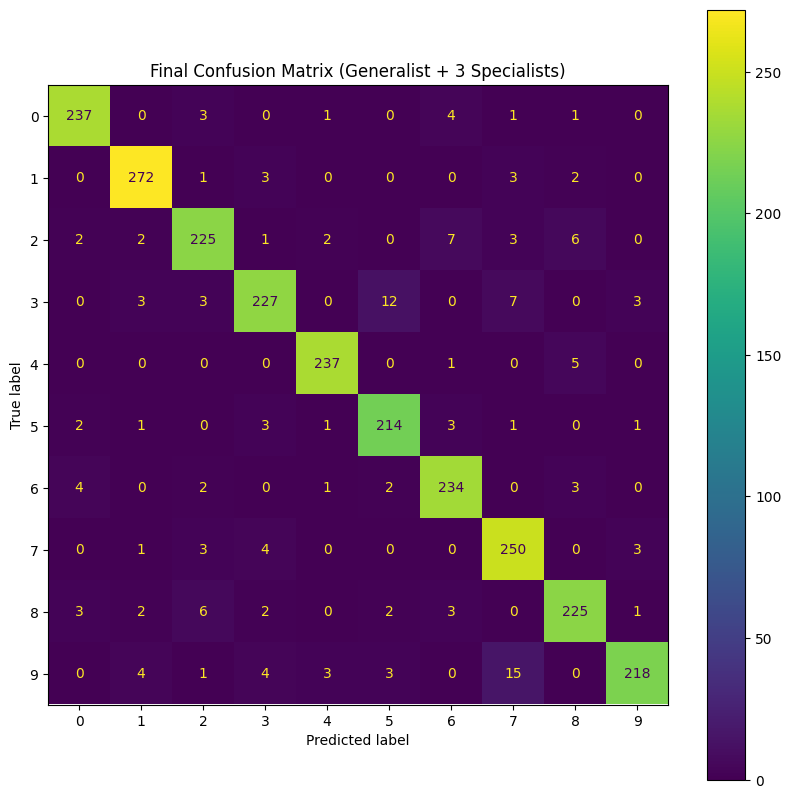

In [53]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt

# We can still use scikit-learn for metrics, just not for the models.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

# ---
# --- (A) FROM-SCRATCH MODELS LIBRARY (All our classes) ---
# ---

class MyStandardScaler:
    """ A from-scratch implementation of StandardScaler. """
    def __init__(self): self.mean_, self.std_ = None, None
    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0) + 1e-9 
    def transform(self, X): 
        if self.mean_ is None: raise ValueError("Scaler not fitted")
        return (X - self.mean_) / self.std_
    def fit_transform(self, X): self.fit(X); return self.transform(X)

class MyMultinomialLogisticRegression:
    """ From-scratch Softmax Regression. This will be our Generalist. """
    def __init__(self, learning_rate=0.01, lambda_p=0.01, n_iters=1000, batch_size=128):
        self.lr, self.lambda_p, self.n_iters, self.batch_size = learning_rate, lambda_p, n_iters, batch_size
        self.W, self.B, self.classes_, self.n_classes_ = None, None, None, 0
    def _softmax(self, x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True)); return e_x / np.sum(e_x, axis=1, keepdims=True)
    def _one_hot(self, y_indices, n_classes):
        one_hot = np.zeros((y_indices.shape[0], n_classes)); one_hot[np.arange(y_indices.shape[0]), y_indices] = 1; return one_hot
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes_, self.n_classes_ = np.unique(y), len(np.unique(y))
        self.W, self.B = np.zeros((n_features, self.n_classes_)), np.zeros(self.n_classes_)
        class_to_index = {c: i for i, c in enumerate(self.classes_)}
        y_indices = np.array([class_to_index[label] for label in y])
        print(f"    - Training Logistic Generalist for {self.n_iters} epochs...")
        for epoch in range(self.n_iters):
            if (epoch + 1) % 250 == 0:
                print(f"    - Epoch {epoch+1}/{self.n_iters}")
            indices = np.arange(n_samples); np.random.shuffle(indices)
            X_shuffled, y_shuffled_indices = X[indices], y_indices[indices]
            for i in range(0, n_samples, self.batch_size):
                X_batch, y_batch_indices = X_shuffled[i:i+self.batch_size], y_shuffled_indices[i:i+self.batch_size]
                batch_n_samples = X_batch.shape[0]
                scores = X_batch @ self.W + self.B
                probabilities = self._softmax(scores)
                y_one_hot = self._one_hot(y_batch_indices, self.n_classes_)
                grad_scores = probabilities - y_one_hot
                dW = (X_batch.T @ grad_scores) / batch_n_samples + (self.lambda_p * self.W)
                dB = np.sum(grad_scores, axis=0) / batch_n_samples
                self.W -= self.lr * dW; self.B -= self.lr * dB
    def predict_proba(self, X):
        scores = X @ self.W + self.B; return self._softmax(scores)
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]

class _BinarySVM:
    """ 
    Our from-scratch Binary SVM. This will be our Specialist.
    We use the best tuned params: lr=0.01, lam=0.0001
    """
    def __init__(self, learning_rate=0.01, lambda_p=0.0001, n_iters=1000, batch_size=64):
        self.lr, self.lambda_p, self.n_iters, self.batch_size = learning_rate, lambda_p, n_iters, batch_size
        self.w, self.b = None, 0
    def fit(self, X, y):
        y_ = np.where(y > 0, 1, -1) # Use > 0 for binary labels
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        for epoch in range(self.n_iters):
            if (epoch + 1) % 500 == 0:
                print(f"    - Specialist SVM Epoch {epoch+1}/{self.n_iters}")
            indices = np.arange(n_samples); np.random.shuffle(indices)
            X_shuffled, y_shuffled = X[indices], y_[indices]
            for i in range(0, n_samples, self.batch_size):
                X_batch, y_batch = X_shuffled[i:i+self.batch_size], y_shuffled[i:i+self.batch_size]
                batch_n_samples = X_batch.shape[0]
                conditions = y_batch * (np.dot(X_batch, self.w) - self.b)
                missed_mask = conditions < 1
                dw_reg = self.lambda_p * self.w
                dw_data = -np.dot(y_batch[missed_mask].T, X_batch[missed_mask])
                num_missed = np.sum(missed_mask)
                if num_missed > 0:
                    dw = (dw_data / num_missed) + dw_reg
                    db_data = -np.sum(y_batch[missed_mask])
                    db = db_data / num_missed
                else:
                    dw, db = dw_reg, 0
                self.w -= self.lr * dw; self.b -= self.lr * db
    def predict(self, X):
        return np.sign(np.dot(X, self.w) - self.b) # Predicts +1 or -1

class PCAModel:
    """ 
    Our from-scratch PCA model.
    We need this to build our "Specialist Features".
    """
    def __init__(self, n_components):
        self.n_components = n_components
        self.mean = None
        self.components = None # Eigenvectors
    def fit(self, X):
        X = np.array(X, dtype=float)
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        cov_matrix = np.cov(X_centered, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        sorted_idx = np.argsort(eigenvalues)[::-1]
        self.components = eigenvectors[:, sorted_idx][:, :self.n_components]
    def predict(self, X):
        if self.mean is None or self.components is None:
            raise ValueError("PCA model has not been fitted yet.")
        X_centered = np.array(X, dtype=float) - self.mean
        return np.dot(X_centered, self.components)

# ---
# --- (B) SPECIALIST MODEL FACTORY ---
# ---

class SpecialistTrainer:
    """ A helper class to build a specialist model for a given pair. """
    def __init__(self, class1, class2, n_components=20):
        self.c1 = class1 # This will be label +1
        self.c2 = class2 # This will be label -1
        self.n_components = n_components
        
        self.pca = PCAModel(n_components=self.n_components)
        # Use the best tuned SVM params
        self.svm = _BinarySVM(learning_rate=0.01, lambda_p=0.0001, n_iters=1000)
        
    def fit(self, X_full, y_full):
        print(f"    - Training Specialist for ({self.c1} vs {self.c2})...")
        # 1. Filter data to only this pair
        pair_mask = (y_full == self.c1) | (y_full == self.c2)
        X_pair = X_full[pair_mask]
        y_pair = y_full[pair_mask]
        
        # 2. Create Specialist Features ("Covariance Insights")
        self.pca.fit(X_pair)
        X_train_specialist = self.pca.predict(X_pair)
        
        # 3. Create specialist labels (+1 for c1, -1 for c2)
        y_train_specialist = np.where(y_pair == self.c1, 1, -1)
        
        # 4. Train the specialist SVM
        self.svm.fit(X_train_specialist, y_train_specialist)
        
    def predict(self, X_to_fix):
        """ Predicts labels for new, unseen data. """
        # 1. Transform pixels into "specialist features"
        X_fix_specialist_features = self.pca.predict(X_to_fix)
        
        # 2. Get specialist's binary prediction (+1 or -1)
        specialist_binary_votes = self.svm.predict(X_fix_specialist_features)
        
        # 3. Convert binary votes back to class labels
        return np.where(specialist_binary_votes == 1, self.c1, self.c2)

# ---
# --- (C) DATA LOADING & PIPELINE ---
# ---

if __name__ == "__main__":
    
    # --- 1. Load All Original Data ---
    base_path = r"/home/harshvardhan/ml_lab_project/end-semester-project-Programing-Ninja/"
    train_orig_file = base_path + "MNIST_train.csv"
    test_orig_file = base_path + "MNIST_validation.csv"
    
    print("Loading all datasets...")
    df_train_orig = pd.read_csv(train_orig_file)
    Xtrain_orig, ytrain_orig = df_train_orig.drop(columns=["label"]).values, df_train_orig["label"].values.astype(int)
    
    df_test_orig = pd.read_csv(test_orig_file)
    Xtest_orig, ytest_orig = df_test_orig.drop(columns=["label"]).values, df_test_orig["label"].values.astype(int)
    print("Data loaded.")

    # --- 2. Train the Generalist Model ---
    print("\n--- Training Generalist (LogisticRegression on 784 features) ---")
    
    # Scale data for the Generalist
    scaler_generalist = MyStandardScaler()
    Xtrain_scaled = scaler_generalist.fit_transform(Xtrain_orig)
    
    # Use our best tuned params for Logistic Regression
    generalist_model = MyMultinomialLogisticRegression(
        learning_rate=0.1, lambda_p=0.01, n_iters=1000
    )
    generalist_model.fit(Xtrain_scaled, ytrain_orig)
    
    # --- 3. Train the Specialist Models ---
    print("\n--- Training All Specialist Models ---")
    
    # Based on your confusion matrix:
    # We set the "True" class (the one on the y-axis) as +1 (c1)
    spec_9_vs_7 = SpecialistTrainer(class1=9, class2=7, n_components=20)
    spec_9_vs_7.fit(Xtrain_orig, ytrain_orig)
    
    spec_7_vs_3 = SpecialistTrainer(class1=7, class2=3, n_components=20)
    spec_7_vs_3.fit(Xtrain_orig, ytrain_orig)
    
    spec_4_vs_9 = SpecialistTrainer(class1=4, class2=9, n_components=20)
    spec_4_vs_9.fit(Xtrain_orig, ytrain_orig)

    # --- 4. Run the Full Evaluation Pipeline ---
    print("\n--- Evaluating Pipeline ---")
    
    # a) Scale the test data for the Generalist
    Xtest_scaled = scaler_generalist.transform(Xtest_orig)
    
    # b) Get Generalist's initial predictions and probabilities
    print("    - Generalist is making predictions...")
    generalist_preds = generalist_model.predict(Xtest_scaled)
    generalist_probs = generalist_model.predict_proba(Xtest_scaled)
    
    # c) Score the Generalist-Only model
    f1_generalist = f1_score(ytest_orig, generalist_preds, average='macro')
    acc_generalist = accuracy_score(ytest_orig, generalist_preds)
    print(f"    - Generalist F1 Score: {f1_generalist:.4f}")
    
    # --- 5. Run the Confusion Detector & Fix with Specialists ---
    print("    - Confusion Detector is finding 'hard' cases...")
    
    # Find the top 2 probabilities and their classes
    top_two_indices = np.argsort(generalist_probs, axis=1)[:, -2:]
    top_two_classes = generalist_model.classes_[top_two_indices]
    top_two_probs = np.sort(generalist_probs, axis=1)[:, -2:]
    
    p_winner = top_two_probs[:, 1]
    p_runner_up = top_two_probs[:, 0]
    
    # Define our confusion threshold
    # If P(winner) - P(runner-up) is less than 0.4, it's a "hard" case
    CONFUSION_MARGIN = 0.1
    is_confused = (p_winner - p_runner_up) < CONFUSION_MARGIN
    
    # Create the final prediction array, starting with the Generalist's guesses
    final_predictions = generalist_preds.copy()
    
    # --- Deploy Specialist 1: (9 vs 7) ---
    is_9_vs_7_pair = ((top_two_classes[:, 0] == 7) & (top_two_classes[:, 1] == 9)) | \
                       ((top_two_classes[:, 0] == 9) & (top_two_classes[:, 1] == 7))
    needs_specialist_mask = is_confused & is_9_vs_7_pair
    X_to_fix = Xtest_orig[needs_specialist_mask]
    
    if X_to_fix.shape[0] > 0:
        print(f"    - Found {X_to_fix.shape[0]} confused 9/7 cases. Sending to specialist...")
        specialist_labels = spec_9_vs_7.predict(X_to_fix)
        final_predictions[needs_specialist_mask] = specialist_labels
    
    # --- Deploy Specialist 2: (7 vs 3) ---
    is_7_vs_3_pair = ((top_two_classes[:, 0] == 3) & (top_two_classes[:, 1] == 7)) | \
                       ((top_two_classes[:, 0] == 7) & (top_two_classes[:, 1] == 3))
    needs_specialist_mask = is_confused & is_7_vs_3_pair
    X_to_fix = Xtest_orig[needs_specialist_mask]
    
    if X_to_fix.shape[0] > 0:
        print(f"    - Found {X_to_fix.shape[0]} confused 7/3 cases. Sending to specialist...")
        specialist_labels = spec_7_vs_3.predict(X_to_fix)
        final_predictions[needs_specialist_mask] = specialist_labels

    # --- Deploy Specialist 3: (4 vs 9) ---
    is_4_vs_9_pair = ((top_two_classes[:, 0] == 4) & (top_two_classes[:, 1] == 9)) | \
                       ((top_two_classes[:, 0] == 9) & (top_two_classes[:, 1] == 4))
    needs_specialist_mask = is_confused & is_4_vs_9_pair
    X_to_fix = Xtest_orig[needs_specialist_mask]
    
    if X_to_fix.shape[0] > 0:
        print(f"    - Found {X_to_fix.shape[0]} confused 4/9 cases. Sending to specialist...")
        specialist_labels = spec_4_vs_9.predict(X_to_fix)
        final_predictions[needs_specialist_mask] = specialist_labels
        
    # --- 6. Final Results ---
    print("\n--- Final Model Comparison ---")
    
    f1_final = f1_score(ytest_orig, final_predictions, average='macro')
    acc_final = accuracy_score(ytest_orig, final_predictions)
    
    print(f"{'Model':<30} | {'Accuracy':<10} | {'F1 (Macro)':<10}")
    print("-" * 55)
    print(f"{'Generalist-Only (Logistic)':<30} | {acc_generalist:<10.4f} | {f1_generalist:<10.4f}")
    print(f"{'Generalist + 3 Specialists':<30} | {acc_final:<10.4f} | {f1_final:<10.4f}")
    
    f1_improvement = f1_final - f1_generalist
    print(f"\nF1 Improvement: {f1_improvement:+.4f}")
    
    # Display the final, improved confusion matrix
    print("\n--- Displaying Final Confusion Matrix ---")
    fig, ax = plt.subplots(figsize=(10, 10))
    ConfusionMatrixDisplay(confusion_matrix(ytest_orig, final_predictions)).plot(ax=ax)
    plt.title(f'Final Confusion Matrix (Generalist + 3 Specialists)')
    plt.show()

Loading all datasets...
All data loaded.
Creating 80/20 train/validation split for tuning...
Fitting scaler on 80% training data...

--- STARTING **FINAL** MODEL BAKE-OFF (with Early Stopping) ---

--- Training: Logistic on Original (Tuned + ES) ---
    - Fitting model (785 features)...
    - Training Logistic Regression for max 1500 epochs (Patience=10)...
    - Predicting on final unseen test set...

--- Training: SVM on Original (Tuned + ES) ---
    - Fitting model (785 features)...
    - Training True SVM for max 1500 epochs (Patience=10)...
    - Predicting on final unseen test set...

--- Training: KNN (k=5) on Original (Tuned) ---
!!! --- This will be VERY, VERY SLOW --- !!!
    - Fitting model (785 features)...
    - Predicting on final unseen test set...
    - KNN predicting sample 100/2499...
    - KNN predicting sample 200/2499...
    - KNN predicting sample 300/2499...
    - KNN predicting sample 400/2499...
    - KNN predicting sample 500/2499...
    - KNN predicting sampl

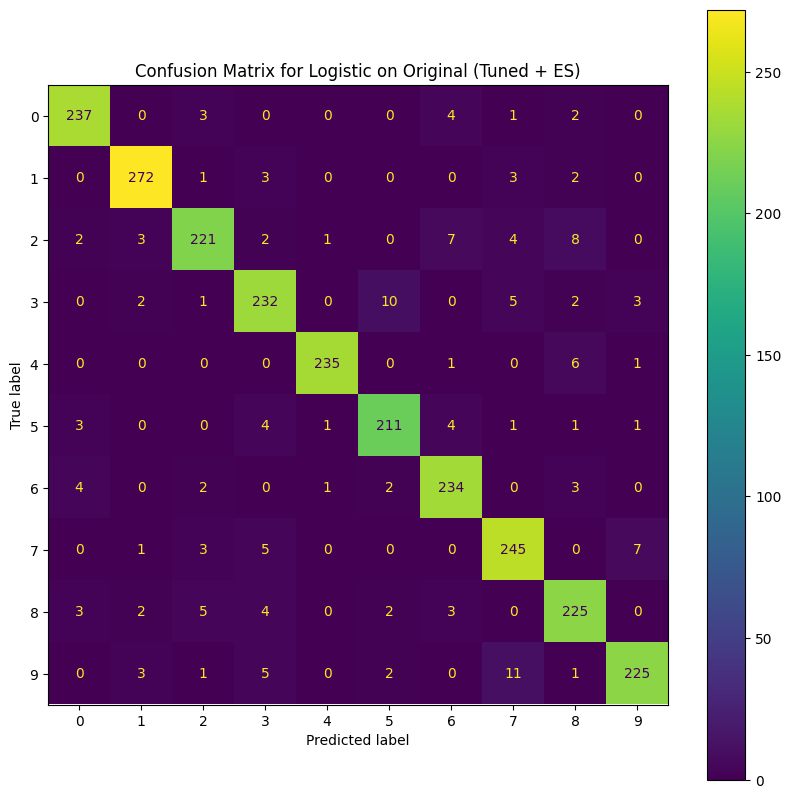

In [54]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split # We need this to create our validation set

# We can still use scikit-learn for metrics, just not for the models.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

# ---
# --- (A) FROM-SCRATCH PREPROCESSING ---
# ---
class MyStandardScaler:
    """ A from-scratch implementation of StandardScaler. """
    def __init__(self): self.mean_, self.std_ = None, None
    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0) + 1e-9 
    def transform(self, X): 
        if self.mean_ is None: raise ValueError("Scaler not fitted")
        return (X - self.mean_) / self.std_
    def fit_transform(self, X): self.fit(X); return self.transform(X)

# ---
# --- (B) FROM-SCRATCH MODELS (WITH EARLY STOPPING) ---
# ---

class MyKNeighborsClassifier:
    """ From-scratch KNN. Fit() is fast, predict() is very slow. """
    def __init__(self, k=5):
        self.k = k
        self.X_train_, self.y_train_ = None, None
    def fit(self, X, y, eval_set=None): # Added eval_set to match signature, but won't use it
        self.X_train_ = X; self.y_train_ = y
    def predict(self, X_test):
        predictions = []
        for i, x in enumerate(X_test):
            if (i + 1) % 100 == 0:
                print(f"    - KNN predicting sample {i+1}/{X_test.shape[0]}...")
            predictions.append(self._predict_one(x))
        return np.array(predictions)
    def _predict_one(self, x_test):
        distances = np.sum((self.X_train_ - x_test)**2, axis=1)
        k_nearest_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = self.y_train_[k_nearest_indices]
        return np.bincount(k_nearest_labels).argmax()

class MyTrueMulticlassSVM:
    """ From-scratch 'True' Multiclass SVM with Early Stopping. """
    def __init__(self, learning_rate=0.01, lambda_p=0.01, n_iters=1000, batch_size=128,
                 early_stopping_patience=10, validation_freq=10):
        
        self.lr, self.lambda_p, self.n_iters, self.batch_size = learning_rate, lambda_p, n_iters, batch_size
        self.patience_ = early_stopping_patience
        self.validation_freq_ = validation_freq
        self.W, self.B, self.classes_, self.n_classes_ = None, None, None, 0
        self.best_W_, self.best_B_, self.best_score_, self.epochs_no_improve_ = None, None, -np.inf, 0

    def fit(self, X, y, eval_set=None):
        n_samples, n_features = X.shape
        self.classes_, self.n_classes_ = np.unique(y), len(np.unique(y))
        self.W, self.B = np.zeros((n_features, self.n_classes_)), np.zeros(self.n_classes_)
        class_to_index = {c: i for i, c in enumerate(self.classes_)}
        y_indices = np.array([class_to_index[label] for label in y])

        print(f"    - Training True SVM for max {self.n_iters} epochs (Patience={self.patience_})...")
        for epoch in range(self.n_iters):
            indices = np.arange(n_samples); np.random.shuffle(indices)
            X_shuffled, y_shuffled = X[indices], y_indices[indices]
            
            for i in range(0, n_samples, self.batch_size):
                # ... (Standard Mini-batch Gradient Descent logic) ...
                X_batch, y_batch = X_shuffled[i:i+self.batch_size], y_shuffled[i:i+self.batch_size]
                batch_n_samples = X_batch.shape[0]
                scores = X_batch @ self.W + self.B
                correct_class_scores = scores[np.arange(batch_n_samples), y_batch].reshape(-1, 1)
                margins = scores - correct_class_scores + 1.0
                margins[np.arange(batch_n_samples), y_batch] = 0
                violating_class_indices = np.argmax(margins, axis=1)
                max_margins = margins[np.arange(batch_n_samples), violating_class_indices]
                missed_mask = max_margins > 0; num_missed = np.sum(missed_mask)
                if num_missed == 0: continue
                X_missed, y_true_missed, y_violating_missed = X_batch[missed_mask], y_batch[missed_mask], violating_class_indices[missed_mask]
                dW, dB = np.zeros_like(self.W), np.zeros_like(self.B)
                np.subtract.at(dW.T, y_true_missed, X_missed); np.add.at(dW.T, y_violating_missed, X_missed)
                np.subtract.at(dB, y_true_missed, 1); np.add.at(dB, y_violating_missed, 1)
                dW, dB = (dW / num_missed) + (self.lambda_p * self.W), dB / num_missed
                self.W -= self.lr * dW; self.B -= self.lr * dB
            
            # --- Early Stopping Check ---
            if eval_set and (epoch + 1) % self.validation_freq_ == 0:
                X_val, y_val = eval_set
                y_val_pred = self.predict(X_val) # Use current weights
                
                # We use accuracy for validation checks
                current_accuracy = np.mean(y_val_pred == y_val)
                
                if current_accuracy > self.best_score_:
                    self.best_score_ = current_accuracy
                    self.epochs_no_improve_ = 0
                    self.best_W_ = self.W.copy() # Save best weights
                    self.best_B_ = self.B.copy()
                    print(f"    - Epoch {epoch+1}: New best val_accuracy: {current_accuracy:.4f}")
                else:
                    self.epochs_no_improve_ += 1
                    print(f"    - Epoch {epoch+1}: No improvement ({self.epochs_no_improve_}/{self.patience_})")
                
                if self.epochs_no_improve_ >= self.patience_:
                    print(f"    - Stopping early at epoch {epoch+1}!")
                    break

        # After loop, restore the best weights found
        if self.best_W_ is not None:
            self.W = self.best_W_
            self.B = self.best_B_

    def predict(self, X):
        scores = X @ self.W + self.B
        return self.classes_[np.argmax(scores, axis=1)]

class MyMultinomialLogisticRegression:
    """ From-scratch Softmax Regression with Early Stopping. """
    def __init__(self, learning_rate=0.01, lambda_p=0.01, n_iters=1000, batch_size=128,
                 early_stopping_patience=10, validation_freq=10):
        
        self.lr, self.lambda_p, self.n_iters, self.batch_size = learning_rate, lambda_p, n_iters, batch_size
        self.patience_ = early_stopping_patience
        self.validation_freq_ = validation_freq
        self.W, self.B, self.classes_, self.n_classes_ = None, None, None, 0
        self.best_W_, self.best_B_, self.best_score_, self.epochs_no_improve_ = None, None, -np.inf, 0

    def _softmax(self, x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True)); return e_x / np.sum(e_x, axis=1, keepdims=True)
    def _one_hot(self, y_indices, n_classes):
        one_hot = np.zeros((y_indices.shape[0], n_classes)); one_hot[np.arange(y_indices.shape[0]), y_indices] = 1; return one_hot
    
    def fit(self, X, y, eval_set=None):
        n_samples, n_features = X.shape
        self.classes_, self.n_classes_ = np.unique(y), len(np.unique(y))
        self.W, self.B = np.zeros((n_features, self.n_classes_)), np.zeros(self.n_classes_)
        class_to_index = {c: i for i, c in enumerate(self.classes_)}
        y_indices = np.array([class_to_index[label] for label in y])

        print(f"    - Training Logistic Regression for max {self.n_iters} epochs (Patience={self.patience_})...")
        for epoch in range(self.n_iters):
            indices = np.arange(n_samples); np.random.shuffle(indices)
            X_shuffled, y_shuffled_indices = X[indices], y_indices[indices]
            
            for i in range(0, n_samples, self.batch_size):
                # ... (Standard Mini-batch Gradient Descent logic) ...
                X_batch, y_batch_indices = X_shuffled[i:i+self.batch_size], y_shuffled_indices[i:i+self.batch_size]
                batch_n_samples = X_batch.shape[0]
                scores = X_batch @ self.W + self.B
                probabilities = self._softmax(scores)
                y_one_hot = self._one_hot(y_batch_indices, self.n_classes_)
                grad_scores = probabilities - y_one_hot
                dW = (X_batch.T @ grad_scores) / batch_n_samples + (self.lambda_p * self.W)
                dB = np.sum(grad_scores, axis=0) / batch_n_samples
                self.W -= self.lr * dW; self.B -= self.lr * dB
            
            # --- Early Stopping Check ---
            if eval_set and (epoch + 1) % self.validation_freq_ == 0:
                X_val, y_val = eval_set
                y_val_pred = self.predict(X_val) # Use current weights
                
                current_accuracy = np.mean(y_val_pred == y_val)
                
                if current_accuracy > self.best_score_:
                    self.best_score_ = current_accuracy
                    self.epochs_no_improve_ = 0
                    self.best_W_ = self.W.copy() # Save best weights
                    self.best_B_ = self.B.copy()
                    print(f"    - Epoch {epoch+1}: New best val_accuracy: {current_accuracy:.4f}")
                else:
                    self.epochs_no_improve_ += 1
                    print(f"    - Epoch {epoch+1}: No improvement ({self.epochs_no_improve_}/{self.patience_})")
                
                if self.epochs_no_improve_ >= self.patience_:
                    print(f"    - Stopping early at epoch {epoch+1}!")
                    break

        # After loop, restore the best weights found
        if self.best_W_ is not None:
            self.W = self.best_W_
            self.B = self.best_B_
            
    def predict_proba(self, X):
        scores = X @ self.W + self.B; return self._softmax(scores)
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]

class MyVotingClassifier:
    """ A from-scratch ensemble voter. """
    def __init__(self): pass
    def predict(self, list_of_prediction_arrays):
        stacked_preds = np.column_stack(list_of_prediction_arrays)
        return np.apply_along_axis(
            lambda x: np.bincount(x).argmax(), 
            axis=1, 
            arr=stacked_preds.astype(int)
        )
# ---
# --- (C) DATA LOADING & PIPELINE ---
# ---
def load_all_data(base_path):
    """ Loads original train and test data. """
    print("Loading all datasets...")
    train_orig_file = base_path + "MNIST_train.csv"
    test_orig_file = base_path + "MNIST_validation.csv"
    
    df_train_orig = pd.read_csv(train_orig_file)
    Xtrain, ytrain = df_train_orig.drop(columns=["label"]).values, df_train_orig["label"].values.astype(int)
    
    df_test_orig = pd.read_csv(test_orig_file)
    Xtest, ytest = df_test_orig.drop(columns=["label"]).values, df_test_orig["label"].values.astype(int)
    
    print("All data loaded.")
    return (Xtrain, ytrain, Xtest, ytest)

# ---
# --- (D) MAIN EXECUTION ---
# ---
if __name__ == "__main__":
    
    # --- 1. Setup ---
    base_path = r"/home/harshvardhan/ml_lab_project/end-semester-project-Programing-Ninja/"
    Xtrain_orig, ytrain_orig, Xtest_orig, ytest_orig = load_all_data(base_path)

    # --- 2. Create Train/Validation Split for Early Stopping ---
    print("Creating 80/20 train/validation split for tuning...")
    X_train_tune, X_val_tune, y_train_tune, y_val_tune = train_test_split(
        Xtrain_orig, ytrain_orig, test_size=0.2, random_state=42, stratify=ytrain_orig
    )

    # --- 3. Scale Data ---
    print("Fitting scaler on 80% training data...")
    scaler = MyStandardScaler()
    X_train_tune_scaled = scaler.fit_transform(X_train_tune)
    X_val_tune_scaled = scaler.transform(X_val_tune)
    X_test_final_scaled = scaler.transform(Xtest_orig) # Scale test set for final eval

    # --- 4. Model Configuration ---
    # We use our best tuned params, but replace n_iters with early stopping
    MODEL_CONFIGS = [
        {
            "name": "Logistic on Original (Tuned + ES)",
            "model": MyMultinomialLogisticRegression(
                learning_rate=0.1, lambda_p=0.01, n_iters=1500, # High max epochs
                early_stopping_patience=10, validation_freq=10 # Stop after 100 epochs (10*10)
            ),
            "use_scaler": True
        },
        {
            "name": "SVM on Original (Tuned + ES)",
            "model": MyTrueMulticlassSVM(
                learning_rate=0.01, lambda_p=0.0001, n_iters=1500, # High max epochs
                early_stopping_patience=10, validation_freq=10
            ),
            "use_scaler": True
        },
        {
            "name": "KNN (k=5) on Original (Tuned)",
            "model": MyKNeighborsClassifier(k=5), 
            "use_scaler": True,
            "warning": "--- This will be VERY, VERY SLOW ---"
        },
    ]

    # --- 5. Run Bake-Off ---
    all_results = []
    all_predictions = {} 
    print("\n--- STARTING **FINAL** MODEL BAKE-OFF (with Early Stopping) ---")

    for config in MODEL_CONFIGS:
        name = config["name"]
        print(f"\n--- Training: {name} ---")
        if "warning" in config: print(f"!!! {config['warning']} !!!")
        
        # We use the scaled 80/20 split for training and validation
        Xtrain_proc = X_train_tune_scaled
        ytrain_proc = y_train_tune
        eval_set_proc = (X_val_tune_scaled, y_val_tune)
        
        # Final test set is always the same
        Xtest_proc = X_test_final_scaled
        ytest_proc = ytest_orig
            
        model = config["model"]
        print(f"    - Fitting model ({Xtrain_proc.shape[1]} features)...")
        start_time_train = time.time()
        
        # Give eval_set to models that support it
        if "early_stopping_patience" in model.__dict__:
            model.fit(Xtrain_proc, ytrain_proc, eval_set=eval_set_proc)
        else:
            model.fit(Xtrain_proc, ytrain_proc) # KNN just fits
            
        train_time = time.time() - start_time_train
        
        print("    - Predicting on final unseen test set...")
        start_time_pred = time.time()
        ypred = model.predict(Xtest_proc)
        predict_time = time.time() - start_time_pred
        
        accuracy = accuracy_score(ytest_proc, ypred)
        f1 = f1_score(ytest_proc, ypred, average='macro')
        
        all_results.append({
            "name": name, "acc": accuracy, "f1": f1,
            "train_time": train_time, "pred_time": predict_time
        })
        all_predictions[name] = ypred

    # --- 6. Run Tuned Ensemble ---
    print("\n--- Building **Final** Ensemble (from ES models) ---")
    voter = MyVotingClassifier()
    
    try:
        ensemble_preds_orig = [
            all_predictions["Logistic on Original (Tuned + ES)"],
            all_predictions["SVM on Original (Tuned + ES)"],
            all_predictions["KNN (k=5) on Original (Tuned)"]
        ]
        ytest_orig = ytest_orig # True labels for the test set

        start_time_pred = time.time()
        ypred_ensemble_orig = voter.predict(ensemble_preds_orig)
        predict_time = time.time() - start_time_pred
        
        accuracy = accuracy_score(ytest_orig, ypred_ensemble_orig)
        f1 = f1_score(ytest_orig, ypred_ensemble_orig, average='macro')
        
        all_results.append({
            "name": "Ensemble (Log+SVM+KNN) - FINAL",
            "acc": accuracy, "f1": f1, "train_time": 0, "pred_time": predict_time
        })
    except KeyError as e:
        print(f"    - Could not run Final Ensemble. Missing model: {e}")

    # --- 7. Print Final Leaderboard ---
    all_results.sort(key=lambda x: x["f1"], reverse=True)
    print("\n\n--- FINAL LEADERBOARD (with Early Stopping) ---")
    print(f"{'Model':<50} | {'Accuracy':<10} | {'F1 (Macro)':<10} | {'Train (s)':<10} | {'Predict (s)':<10}")
    print("-" * 95)
    for res in all_results:
        print(f"{res['name']:<50} | {res['acc']:<10.4f} | {res['f1']:<10.4f} | {res['train_time']:<10.2f} | {res['pred_time']:<10.2f}")

    # --- 8. Show Confusion Matrix for the Winner ---
    if all_results:
        winner_name = all_results[0]["name"]
        print(f"\n--- Displaying Confusion Matrix for WINNER: {winner_name} ---")
        
        if "Ensemble" in winner_name:
            ypred_winner = ypred_ensemble_orig
        else:
            ypred_winner = all_predictions[winner_name]
            
        ytest_winner = ytest_orig
            
        fig, ax = plt.subplots(figsize=(10, 10))
        ConfusionMatrixDisplay(confusion_matrix(ytest_winner, ypred_winner)).plot(ax=ax)
        plt.title(f'Confusion Matrix for {winner_name}')
        plt.show()

Loading all datasets...
All data loaded.
Creating 80/20 train/validation split for tuning...
Fitting scaler on 80% training data...

--- STARTING **ASYMMETRIC** MODEL BAKE-OFF ---

--- Training: Logistic on Original (Tuned + ES) ---
    - Training Logistic Regression for max 1500 epochs (Patience=10)...
    - Epoch 10: New best val_accuracy: 0.9295
    - Epoch 20: New best val_accuracy: 0.9305
    - Epoch 30: New best val_accuracy: 0.9310
    - Epoch 40: No improvement (1/10)
    - Epoch 50: No improvement (2/10)
    - Epoch 60: No improvement (3/10)
    - Epoch 70: New best val_accuracy: 0.9315
    - Epoch 80: No improvement (1/10)
    - Epoch 90: No improvement (2/10)
    - Epoch 100: No improvement (3/10)
    - Epoch 110: New best val_accuracy: 0.9335
    - Epoch 120: No improvement (1/10)
    - Epoch 130: No improvement (2/10)
    - Epoch 140: No improvement (3/10)
    - Epoch 150: No improvement (4/10)
    - Epoch 160: No improvement (5/10)
    - Epoch 170: New best val_accuracy: 

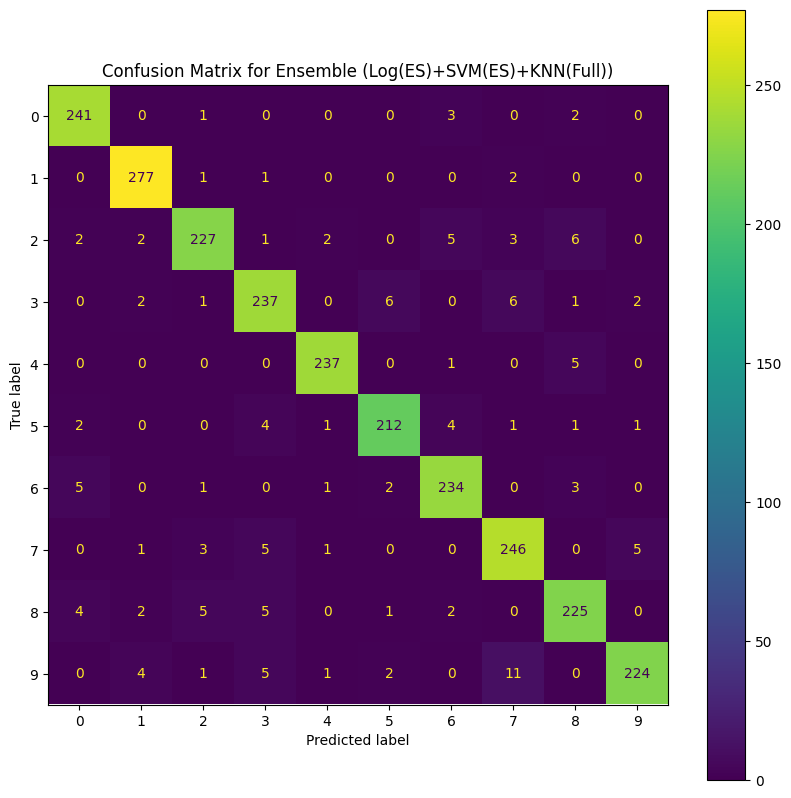

In [55]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split # We need this to create our validation set

# We can still use scikit-learn for metrics, just not for the models.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

# ---
# --- (A) FROM-SCRATCH PREPROCESSING ---
# ---
class MyStandardScaler:
    """ A from-scratch implementation of StandardScaler. """
    def __init__(self): self.mean_, self.std_ = None, None
    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0) + 1e-9 
    def transform(self, X): 
        if self.mean_ is None: raise ValueError("Scaler not fitted")
        return (X - self.mean_) / self.std_
    def fit_transform(self, X): self.fit(X); return self.transform(X)

# ---
# --- (B) FROM-SCRATCH MODELS (WITH EARLY STOPPING) ---
# ---

class MyKNeighborsClassifier:
    """ From-scratch KNN. """
    def __init__(self, k=5):
        self.k = k
        self.X_train_, self.y_train_ = None, None
    def fit(self, X, y, eval_set=None): # Added eval_set to match signature
        self.X_train_ = X; self.y_train_ = y
    def predict(self, X_test):
        predictions = []
        for i, x in enumerate(X_test):
            if (i + 1) % 100 == 0:
                print(f"    - KNN predicting sample {i+1}/{X_test.shape[0]}...")
            predictions.append(self._predict_one(x))
        return np.array(predictions)
    def _predict_one(self, x_test):
        distances = np.sum((self.X_train_ - x_test)**2, axis=1)
        k_nearest_indices = np.argsort(distances)[:self.k]
        k_nearest_labels = self.y_train_[k_nearest_indices]
        return np.bincount(k_nearest_labels).argmax()

class MyTrueMulticlassSVM:
    """ From-scratch 'True' Multiclass SVM with Early Stopping. """
    def __init__(self, learning_rate=0.01, lambda_p=0.01, n_iters=1000, batch_size=128,
                 early_stopping_patience=10, validation_freq=10):
        
        self.lr, self.lambda_p, self.n_iters, self.batch_size = learning_rate, lambda_p, n_iters, batch_size
        self.patience_ = early_stopping_patience
        self.validation_freq_ = validation_freq
        self.W, self.B, self.classes_, self.n_classes_ = None, None, None, 0
        self.best_W_, self.best_B_, self.best_score_, self.epochs_no_improve_ = None, None, -np.inf, 0

    def fit(self, X, y, eval_set=None):
        if eval_set is None:
            raise ValueError("MyTrueMulticlassSVM requires an 'eval_set' for early stopping.")
        
        n_samples, n_features = X.shape
        self.classes_, self.n_classes_ = np.unique(y), len(np.unique(y))
        self.W, self.B = np.zeros((n_features, self.n_classes_)), np.zeros(self.n_classes_)
        class_to_index = {c: i for i, c in enumerate(self.classes_)}
        y_indices = np.array([class_to_index[label] for label in y])

        print(f"    - Training True SVM for max {self.n_iters} epochs (Patience={self.patience_})...")
        for epoch in range(self.n_iters):
            indices = np.arange(n_samples); np.random.shuffle(indices)
            X_shuffled, y_shuffled = X[indices], y_indices[indices]
            
            for i in range(0, n_samples, self.batch_size):
                X_batch, y_batch = X_shuffled[i:i+self.batch_size], y_shuffled[i:i+self.batch_size]
                batch_n_samples = X_batch.shape[0]
                scores = X_batch @ self.W + self.B
                correct_class_scores = scores[np.arange(batch_n_samples), y_batch].reshape(-1, 1)
                margins = scores - correct_class_scores + 1.0
                margins[np.arange(batch_n_samples), y_batch] = 0
                violating_class_indices = np.argmax(margins, axis=1)
                max_margins = margins[np.arange(batch_n_samples), violating_class_indices]
                missed_mask = max_margins > 0; num_missed = np.sum(missed_mask)
                if num_missed == 0: continue
                X_missed, y_true_missed, y_violating_missed = X_batch[missed_mask], y_batch[missed_mask], violating_class_indices[missed_mask]
                dW, dB = np.zeros_like(self.W), np.zeros_like(self.B)
                np.subtract.at(dW.T, y_true_missed, X_missed); np.add.at(dW.T, y_violating_missed, X_missed)
                np.subtract.at(dB, y_true_missed, 1); np.add.at(dB, y_violating_missed, 1)
                dW, dB = (dW / num_missed) + (self.lambda_p * self.W), dB / num_missed
                self.W -= self.lr * dW; self.B -= self.lr * dB
            
            # --- Early Stopping Check ---
            if (epoch + 1) % self.validation_freq_ == 0:
                X_val, y_val = eval_set
                y_val_pred = self.predict(X_val) # Use current weights
                current_accuracy = np.mean(y_val_pred == y_val)
                
                if current_accuracy > self.best_score_:
                    self.best_score_ = current_accuracy
                    self.epochs_no_improve_ = 0
                    self.best_W_ = self.W.copy(); self.best_B_ = self.B.copy()
                    print(f"    - Epoch {epoch+1}: New best val_accuracy: {current_accuracy:.4f}")
                else:
                    self.epochs_no_improve_ += 1
                    print(f"    - Epoch {epoch+1}: No improvement ({self.epochs_no_improve_}/{self.patience_})")
                
                if self.epochs_no_improve_ >= self.patience_:
                    print(f"    - Stopping early at epoch {epoch+1}!")
                    break

        if self.best_W_ is not None:
            self.W, self.B = self.best_W_, self.best_B_

    def predict(self, X):
        scores = X @ self.W + self.B
        return self.classes_[np.argmax(scores, axis=1)]

class MyMultinomialLogisticRegression:
    """ From-scratch Softmax Regression with Early Stopping. """
    def __init__(self, learning_rate=0.01, lambda_p=0.01, n_iters=1000, batch_size=128,
                 early_stopping_patience=10, validation_freq=10):
        
        self.lr, self.lambda_p, self.n_iters, self.batch_size = learning_rate, lambda_p, n_iters, batch_size
        self.patience_ = early_stopping_patience
        self.validation_freq_ = validation_freq
        self.W, self.B, self.classes_, self.n_classes_ = None, None, None, 0
        self.best_W_, self.best_B_, self.best_score_, self.epochs_no_improve_ = None, None, -np.inf, 0

    def _softmax(self, x):
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True)); return e_x / np.sum(e_x, axis=1, keepdims=True)
    def _one_hot(self, y_indices, n_classes):
        one_hot = np.zeros((y_indices.shape[0], n_classes)); one_hot[np.arange(y_indices.shape[0]), y_indices] = 1; return one_hot
    
    def fit(self, X, y, eval_set=None):
        if eval_set is None:
            raise ValueError("MyMultinomialLogisticRegression requires an 'eval_set' for early stopping.")
            
        n_samples, n_features = X.shape
        self.classes_, self.n_classes_ = np.unique(y), len(np.unique(y))
        self.W, self.B = np.zeros((n_features, self.n_classes_)), np.zeros(self.n_classes_)
        class_to_index = {c: i for i, c in enumerate(self.classes_)}
        y_indices = np.array([class_to_index[label] for label in y])

        print(f"    - Training Logistic Regression for max {self.n_iters} epochs (Patience={self.patience_})...")
        for epoch in range(self.n_iters):
            indices = np.arange(n_samples); np.random.shuffle(indices)
            X_shuffled, y_shuffled_indices = X[indices], y_indices[indices]
            
            for i in range(0, n_samples, self.batch_size):
                X_batch, y_batch_indices = X_shuffled[i:i+self.batch_size], y_shuffled_indices[i:i+self.batch_size]
                batch_n_samples = X_batch.shape[0]
                scores = X_batch @ self.W + self.B
                probabilities = self._softmax(scores)
                y_one_hot = self._one_hot(y_batch_indices, self.n_classes_)
                grad_scores = probabilities - y_one_hot
                dW = (X_batch.T @ grad_scores) / batch_n_samples + (self.lambda_p * self.W)
                dB = np.sum(grad_scores, axis=0) / batch_n_samples
                self.W -= self.lr * dW; self.B -= self.lr * dB
            
            # --- Early Stopping Check ---
            if (epoch + 1) % self.validation_freq_ == 0:
                X_val, y_val = eval_set
                y_val_pred = self.predict(X_val) # Use current weights
                current_accuracy = np.mean(y_val_pred == y_val)
                
                if current_accuracy > self.best_score_:
                    self.best_score_ = current_accuracy
                    self.epochs_no_improve_ = 0
                    self.best_W_ = self.W.copy(); self.best_B_ = self.B.copy()
                    print(f"    - Epoch {epoch+1}: New best val_accuracy: {current_accuracy:.4f}")
                else:
                    self.epochs_no_improve_ += 1
                    print(f"    - Epoch {epoch+1}: No improvement ({self.epochs_no_improve_}/{self.patience_})")
                
                if self.epochs_no_improve_ >= self.patience_:
                    print(f"    - Stopping early at epoch {epoch+1}!")
                    break

        if self.best_W_ is not None:
            self.W, self.B = self.best_W_, self.best_B_
            
    def predict_proba(self, X):
        scores = X @ self.W + self.B; return self._softmax(scores)
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), axis=1)]

class MyVotingClassifier:
    """ A from-scratch ensemble voter. """
    def __init__(self): pass
    def predict(self, list_of_prediction_arrays):
        stacked_preds = np.column_stack(list_of_prediction_arrays)
        return np.apply_along_axis(
            lambda x: np.bincount(x).argmax(), 
            axis=1, 
            arr=stacked_preds.astype(int)
        )
# ---
# --- (C) DATA LOADING & PIPELINE ---
# ---
def load_all_data(base_path):
    """ Loads original train and test data. """
    print("Loading all datasets...")
    train_orig_file = base_path + "MNIST_train.csv"
    test_orig_file = base_path + "MNIST_validation.csv"
    
    df_train_orig = pd.read_csv(train_orig_file)
    Xtrain, ytrain = df_train_orig.drop(columns=["label"]).values, df_train_orig["label"].values.astype(int)
    
    df_test_orig = pd.read_csv(test_orig_file)
    Xtest, ytest = df_test_orig.drop(columns=["label"]).values, df_test_orig["label"].values.astype(int)
    
    print("All data loaded.")
    return (Xtrain, ytrain, Xtest, ytest)

# ---
# --- (D) MAIN EXECUTION ---
# ---
if __name__ == "__main__":
    
    # --- 1. Setup ---
    base_path = r"/home/harshvardhan/ml_lab_project/end-semester-project-Programing-Ninja/"
    Xtrain_orig, ytrain_orig, Xtest_orig, ytest_orig = load_all_data(base_path)

    # --- 2. Create Train/Validation Split for Early Stopping ---
    print("Creating 80/20 train/validation split for tuning...")
    X_train_tune, X_val_tune, y_train_tune, y_val_tune = train_test_split(
        Xtrain_orig, ytrain_orig, test_size=0.2, random_state=42, stratify=ytrain_orig
    )

    # --- 3. Scale Data ---
    # We create ONE scaler, fit it on the 80% split, and use it for everything.
    # This is the correct, standard practice.
    print("Fitting scaler on 80% training data...")
    scaler = MyStandardScaler()
    scaler.fit(X_train_tune)
    
    # Scale all datasets
    X_train_tune_scaled = scaler.transform(X_train_tune)
    X_val_tune_scaled = scaler.transform(X_val_tune)
    X_train_orig_scaled = scaler.transform(Xtrain_orig) # For KNN
    X_test_final_scaled = scaler.transform(Xtest_orig) # For final test

    # --- 4. Asymmetric Model Training ---
    all_results = []
    all_predictions = {} 
    print("\n--- STARTING **ASYMMETRIC** MODEL BAKE-OFF ---")

    # --- Model 1: LogisticRegression (Iterative) ---
    print("\n--- Training: Logistic on Original (Tuned + ES) ---")
    log_model = MyMultinomialLogisticRegression(
        learning_rate=0.1, lambda_p=0.01, n_iters=1500, # High max epochs
        early_stopping_patience=10, validation_freq=10
    )
    start_time_train = time.time()
    # Fit on 80%, validate on 20%
    log_model.fit(X_train_tune_scaled, y_train_tune, eval_set=(X_val_tune_scaled, y_val_tune))
    train_time = time.time() - start_time_train
    
    print("    - Predicting on final unseen test set...")
    start_time_pred = time.time()
    ypred_log = log_model.predict(X_test_final_scaled)
    predict_time = time.time() - start_time_pred
    
    acc = accuracy_score(ytest_orig, ypred_log); f1 = f1_score(ytest_orig, ypred_log, average='macro')
    all_results.append({"name": "Logistic (ES)", "acc": acc, "f1": f1, "train_time": train_time, "pred_time": predict_time})
    all_predictions["Logistic"] = ypred_log

    # --- Model 2: SVM (Iterative) ---
    print("\n--- Training: SVM on Original (Tuned + ES) ---")
    svm_model = MyTrueMulticlassSVM(
        learning_rate=0.01, lambda_p=0.0001, n_iters=1500, # High max epochs
        early_stopping_patience=10, validation_freq=10
    )
    start_time_train = time.time()
    # Fit on 80%, validate on 20%
    svm_model.fit(X_train_tune_scaled, y_train_tune, eval_set=(X_val_tune_scaled, y_val_tune))
    train_time = time.time() - start_time_train
    
    print("    - Predicting on final unseen test set...")
    start_time_pred = time.time()
    ypred_svm = svm_model.predict(X_test_final_scaled)
    predict_time = time.time() - start_time_pred
    
    acc = accuracy_score(ytest_orig, ypred_svm); f1 = f1_score(ytest_orig, ypred_svm, average='macro')
    all_results.append({"name": "SVM (ES)", "acc": acc, "f1": f1, "train_time": train_time, "pred_time": predict_time})
    all_predictions["SVM"] = ypred_svm

    # --- Model 3: KNN (Lazy) ---
    print("\n--- Training: KNN (k=5) on Original (Tuned) ---")
    print("    - (This will be VERY, VERY SLOW during prediction) -")
    knn_model = MyKNeighborsClassifier(k=5)
    
    start_time_train = time.time()
    # Fit on 100% of the (scaled) original training data
    knn_model.fit(X_train_orig_scaled, ytrain_orig)
    train_time = time.time() - start_time_train
    
    print("    - Predicting on final unseen test set...")
    start_time_pred = time.time()
    ypred_knn = knn_model.predict(X_test_final_scaled)
    predict_time = time.time() - start_time_pred
    
    acc = accuracy_score(ytest_orig, ypred_knn); f1 = f1_score(ytest_orig, ypred_knn, average='macro')
    all_results.append({"name": "KNN (k=5, Full Data)", "acc": acc, "f1": f1, "train_time": train_time, "pred_time": predict_time})
    all_predictions["KNN"] = ypred_knn

    # --- 5. Run Final Ensemble ---
    print("\n--- Building **Final Asymmetric** Ensemble ---")
    voter = MyVotingClassifier()
    
    ensemble_preds_orig = [
        all_predictions["Logistic"],
        all_predictions["SVM"],
        all_predictions["KNN"]
    ]
    
    start_time_pred = time.time()
    ypred_ensemble_orig = voter.predict(ensemble_preds_orig)
    predict_time = time.time() - start_time_pred
    
    accuracy = accuracy_score(ytest_orig, ypred_ensemble_orig)
    f1 = f1_score(ytest_orig, ypred_ensemble_orig, average='macro')
    
    all_results.append({
        "name": "Ensemble (Log(ES)+SVM(ES)+KNN(Full))",
        "acc": accuracy, "f1": f1, "train_time": 0, "pred_time": predict_time
    })

    # --- 6. Print Final Leaderboard ---
    all_results.sort(key=lambda x: x["f1"], reverse=True)
    print("\n\n--- FINAL ASYMMETRIC BAKE-OFF LEADERBOARD (Sorted by F1 Score) ---")
    print(f"{'Model':<50} | {'Accuracy':<10} | {'F1 (Macro)':<10} | {'Train (s)':<10} | {'Predict (s)':<10}")
    print("-" * 95)
    for res in all_results:
        print(f"{res['name']:<50} | {res['acc']:<10.4f} | {res['f1']:<10.4f} | {res['train_time']:<10.2f} | {res['pred_time']:<10.2f}")

    # --- 7. Show Confusion Matrix for the Winner ---
    if all_results:
        winner_name = all_results[0]["name"]
        print(f"\n--- Displaying Confusion Matrix for WINNER: {winner_name} ---")
        
        if "Ensemble" in winner_name:
            ypred_winner = ypred_ensemble_orig
        else:
            # Re-map simplified name to full prediction key
            pred_key_map = {
                "Logistic (ES)": "Logistic",
                "SVM (ES)": "SVM",
                "KNN (k=5, Full Data)": "KNN"
            }
            ypred_winner = all_predictions[pred_key_map[winner_name]]
            
        ytest_winner = ytest_orig
            
        fig, ax = plt.subplots(figsize=(10, 10))
        ConfusionMatrixDisplay(confusion_matrix(ytest_winner, ypred_winner)).plot(ax=ax)
        plt.title(f'Confusion Matrix for {winner_name}')
        plt.show()